In [ ]:
#!pip install pytorch-lightning --quiet
#!pip install transformers --quiet
#!pip install accelerate --quiet
#!pip install pytorch-forecasting --quiet
#!pip install arch --quiet
#!pip install zarr --quiet
#!pip install pandas==2.2.3 --quiet
#!pip install xarray --quiet
#!pip install h5py -- quiet

In [ ]:
# --- Standard Library Imports ---
import os
import gc
import math
import copy
import random
import re
import zarr
import time
import subprocess
import pickle
import heapq
from functools import partial
from itertools import combinations, count, product
from datetime import datetime
from scipy.stats import loguniform
from pandas.tseries.offsets import DateOffset
import glob
import xgboost as xgb

# --- Data Handling & Numerical Operations ---
import numpy as np
import pandas as pd

# --- PyTorch & PyTorch Lightning (for TFT) ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

# --- Scikit-learn (CPU-based) ---
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.feature_selection import RFECV
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from scipy.stats import truncnorm
from scipy.stats import norm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM



# --- Parallel Processing ---
from joblib import Parallel, delayed, parallel_backend

# --- Plotting & Visualization ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap

# --- Other Utilities ---
import boto3 # For AWS S3 interaction
from scipy.optimize import differential_evolution
import scipy.stats as stats
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import truncnorm


# Seed & device
SEED = 42
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/najo1o11/najo1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Define the paths to your CSV files (WSL-compatible)
csv_path_eir  = "/mnt/d/Colab/Summer Project/Final/New Project/df_eir4_final.csv"
file_path_met = "/mnt/d/Colab/Summer Project/Final/New Project/df_met_final.csv"

# Read CSVs into DataFrames
df_eir = pd.read_csv(csv_path_eir)
df_met = pd.read_csv(file_path_met)

In [ ]:
df_eir

DateTime  IE Generation  IE Demand  IE Wind Availability  \
0       2014-01-01 00:00:00        2752.48    2898.72               1053.11   
1       2014-01-01 00:15:00        2733.59    2868.97               1021.59   
2       2014-01-01 00:30:00        2686.17    2826.42                972.06   
3       2014-01-01 00:45:00        2657.56    2786.94                985.81   
4       2014-01-01 01:00:00        2584.65    2723.94                958.63   
...                     ...            ...        ...                   ...   
397239  2025-04-30 22:45:00        2793.06    3729.58                293.64   
397240  2025-04-30 23:00:00        2701.46    3659.91                301.51   
397241  2025-04-30 23:15:00        2609.66    3584.72                311.83   
397242  2025-04-30 23:30:00        2656.05    3508.22                294.79   
397243  2025-04-30 23:45:00        2664.68    3444.59                276.36   

        IE Wind Generation    SNSP  interconnection  
0                  1020.23  0.4579         285.0000  
1                   995.07  0.4505         285.0000  
2                   932.71  0.4383         285.0000  
3                   959.06  0.4447         285.0000  
4                   920.82  0.4429         285.0000  
...                    ...     ...              ...  
397239              235.55  0.2763         493.2283  
397240              244.82  0.2806         481.4779  
397241              253.29  0.2877         539.7085  
397242              234.60  0.2812         494.0692  
397243              217.27  0.2773         458.4696  

[397244 rows x 7 columns]

In [ ]:
df_eir.columns

Index(['DateTime', 'IE Generation', 'IE Demand', 'IE Wind Availability',
       'IE Wind Generation', 'SNSP', 'interconnection'],
      dtype='object')

In [ ]:
df_met

date  NW_temp   NW_wdsp  NW_wddir  NE_temp   NE_wdsp  \
0       2014-01-01 00:00:00     4.92  11.76827  185.6941     4.75  12.31187   
1       2014-01-01 00:15:00     4.99  11.13026  185.5634     4.77  12.27351   
2       2014-01-01 00:30:00     4.98  11.65589  185.9691     4.76  12.10519   
3       2014-01-01 00:45:00     4.92  11.46710  185.5288     4.74  12.57654   
4       2014-01-01 01:00:00     4.68  12.78372  183.0950     4.23  10.42067   
...                     ...      ...       ...       ...      ...       ...   
397243  2025-04-30 22:45:00    12.84   5.62626  343.4930    12.62   4.79627   
397244  2025-04-30 23:00:00    11.99   3.91097  331.1030    11.42   4.32189   
397245  2025-04-30 23:15:00    11.93   3.65012  331.8281    11.49   4.43552   
397246  2025-04-30 23:30:00    11.94   3.61666  331.3379    11.42   4.51077   
397247  2025-04-30 23:45:00    11.91   3.60927  331.9177    11.45   4.50215   

        NE_wddir  SW_temp   SW_wdsp  SW_wddir  SE_temp   SE_wdsp  SE_wddir  
0       180.9850     6.79  13.34184  197.5041     5.62  11.82582  194.1166  
1       180.4965     6.75  13.68342  197.5874     5.65  11.23969  194.1401  
2       180.1353     6.77  13.88252  197.7414     5.61  11.76227  194.5882  
3       180.7657     6.78  13.21318  197.6124     5.67  11.45572  194.3019  
4       181.3148     6.67  13.38193  189.7843     5.94  13.60537  187.9590  
...          ...      ...       ...       ...      ...       ...       ...  
397243  181.2508    13.08   4.99804   41.3431    13.55   5.33499  110.7636  
397244  242.2021    12.53   3.08051   55.0713    12.45   3.58344  352.1103  
397245  242.9817    12.59   3.72916   55.5349    12.43   3.27176  352.7597  
397246  242.4279    12.59   3.82637   55.2264    12.41   3.60163  352.7198  
397247  242.3341    12.51   3.27436   55.8601    12.42   3.69846  352.2445  

[397248 rows x 13 columns]

In [ ]:
df_met.columns

Index(['date', 'NW_temp', 'NW_wdsp', 'NW_wddir', 'NE_temp', 'NE_wdsp',
       'NE_wddir', 'SW_temp', 'SW_wdsp', 'SW_wddir', 'SE_temp', 'SE_wdsp',
       'SE_wddir'],
      dtype='object')

In [ ]:
# Merge grid and meteorology data
df_features = df_eir.join(df_met, how='left')

# Remove the 'date' column from df_features
df_features = df_features.drop(columns=['date'])

df_features

DateTime  IE Generation  IE Demand  IE Wind Availability  \
0       2014-01-01 00:00:00        2752.48    2898.72               1053.11   
1       2014-01-01 00:15:00        2733.59    2868.97               1021.59   
2       2014-01-01 00:30:00        2686.17    2826.42                972.06   
3       2014-01-01 00:45:00        2657.56    2786.94                985.81   
4       2014-01-01 01:00:00        2584.65    2723.94                958.63   
...                     ...            ...        ...                   ...   
397239  2025-04-30 22:45:00        2793.06    3729.58                293.64   
397240  2025-04-30 23:00:00        2701.46    3659.91                301.51   
397241  2025-04-30 23:15:00        2609.66    3584.72                311.83   
397242  2025-04-30 23:30:00        2656.05    3508.22                294.79   
397243  2025-04-30 23:45:00        2664.68    3444.59                276.36   

        IE Wind Generation    SNSP  interconnection  NW_temp   NW_wdsp  \
0                  1020.23  0.4579         285.0000     4.92  11.76827   
1                   995.07  0.4505         285.0000     4.99  11.13026   
2                   932.71  0.4383         285.0000     4.98  11.65589   
3                   959.06  0.4447         285.0000     4.92  11.46710   
4                   920.82  0.4429         285.0000     4.68  12.78372   
...                    ...     ...              ...      ...       ...   
397239              235.55  0.2763         493.2283    13.91   5.72776   
397240              244.82  0.2806         481.4779    12.82   5.46090   
397241              253.29  0.2877         539.7085    12.83   5.54175   
397242              234.60  0.2812         494.0692    12.80   5.30220   
397243              217.27  0.2773         458.4696    12.84   5.62626   

        NW_wddir  NE_temp   NE_wdsp  NE_wddir  SW_temp   SW_wdsp  SW_wddir  \
0       185.6941     4.75  12.31187  180.9850     6.79  13.34184  197.5041   
1       185.5634     4.77  12.27351  180.4965     6.75  13.68342  197.5874   
2       185.9691     4.76  12.10519  180.1353     6.77  13.88252  197.7414   
3       185.5288     4.74  12.57654  180.7657     6.78  13.21318  197.6124   
4       183.0950     4.23  10.42067  181.3148     6.67  13.38193  189.7843   
...          ...      ...       ...       ...      ...       ...       ...   
397239  333.8041    13.91   5.12810  171.4281    14.42   6.11409   71.9651   
397240  343.2643    12.63   4.08157  181.7638    13.06   4.68742   41.8171   
397241  343.9887    12.69   4.10644  181.5209    13.09   4.70559   41.8753   
397242  343.5183    12.68   4.47666  181.0784    13.02   4.46818   41.4496   
397243  343.4930    12.62   4.79627  181.2508    13.08   4.99804   41.3431   

        SE_temp   SE_wdsp  SE_wddir  
0          5.62  11.82582  194.1166  
1          5.65  11.23969  194.1401  
2          5.61  11.76227  194.5882  
3          5.67  11.45572  194.3019  
4          5.94  13.60537  187.9590  
...         ...       ...       ...  
397239    14.46   5.65387  117.1473  
397240    13.59   5.07615  110.2740  
397241    13.51   5.91819  110.7325  
397242    13.53   5.19841  110.1437  
397243    13.55   5.33499  110.7636  

[397244 rows x 19 columns]

In [ ]:
df_features.columns

Index(['DateTime', 'IE Generation', 'IE Demand', 'IE Wind Availability',
       'IE Wind Generation', 'SNSP', 'interconnection', 'NW_temp', 'NW_wdsp',
       'NW_wddir', 'NE_temp', 'NE_wdsp', 'NE_wddir', 'SW_temp', 'SW_wdsp',
       'SW_wddir', 'SE_temp', 'SE_wdsp', 'SE_wddir'],
      dtype='object')

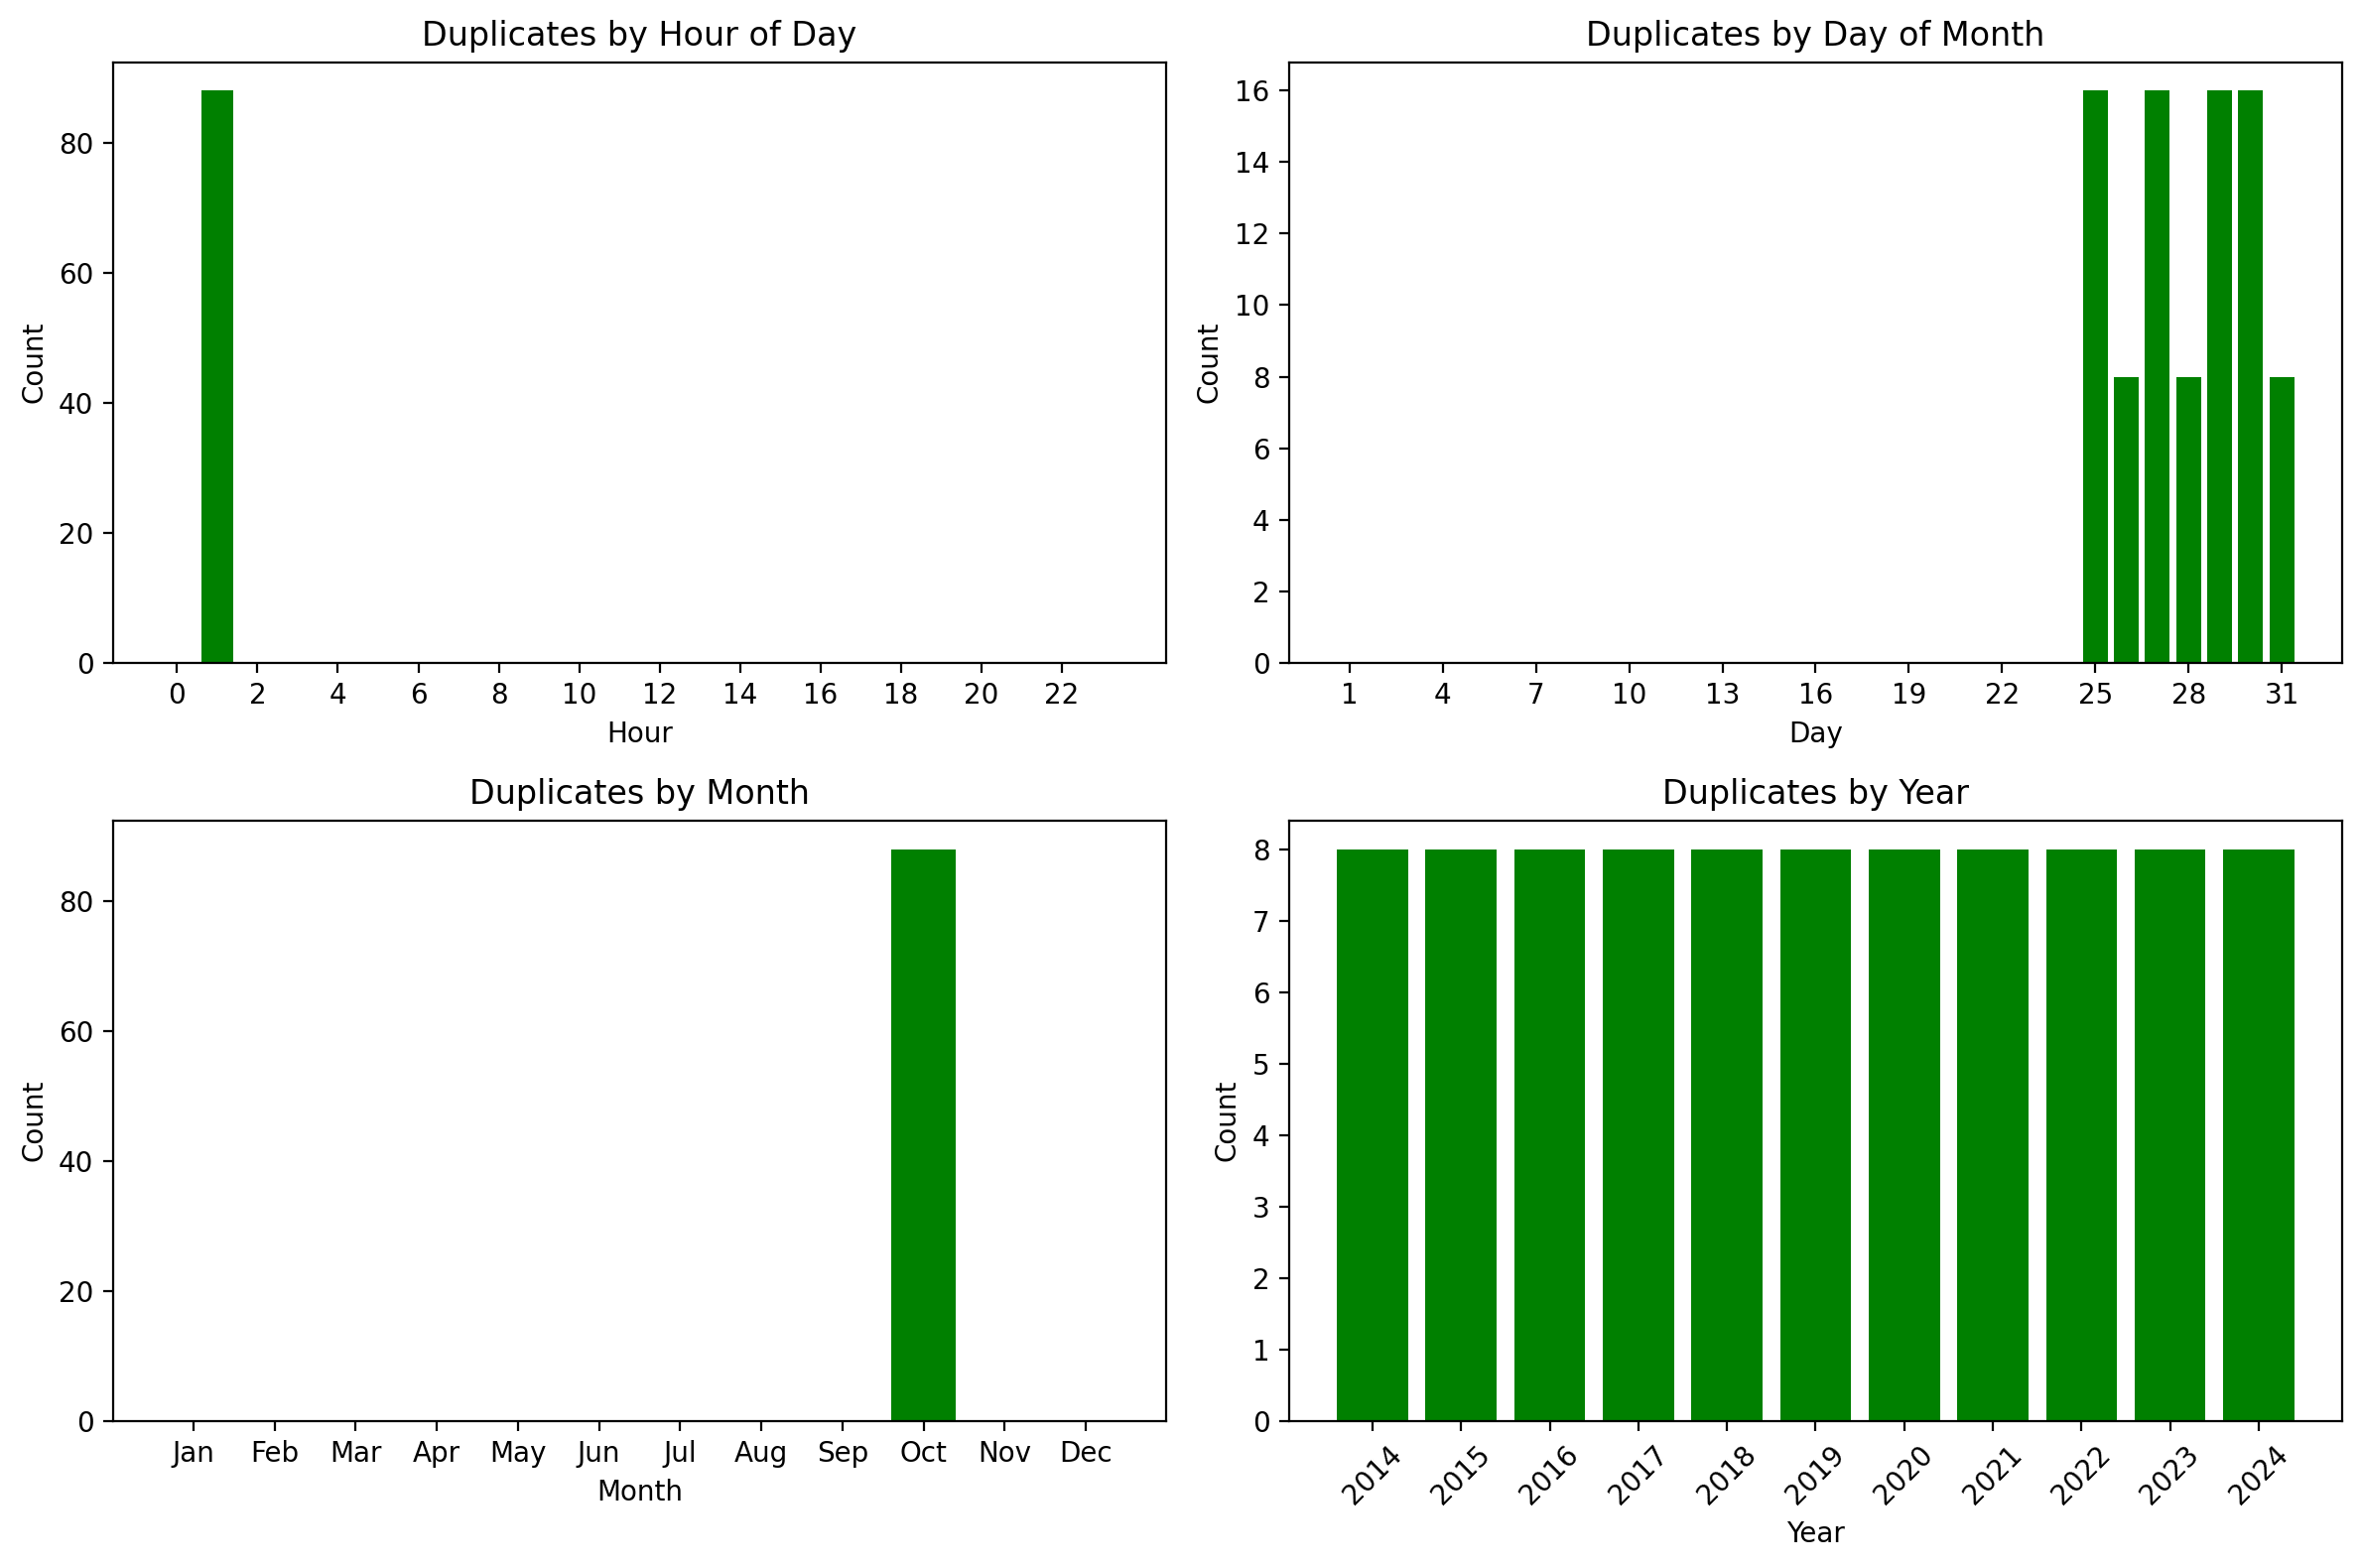

In [ ]:
# Code Cell: Plot Duplicate Timestamp Counts by Hour, Day, Month, and Year

import pandas as pd
import matplotlib.pyplot as plt

# 0) Prepare DataFrame
df = df_features.copy()
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

# 1) Identify duplicates
dup_mask = df.index.duplicated(keep=False)
dups = df[dup_mask].copy()

# 2) Aggregate counts
# a) By hour of day
hour_counts = dups.groupby(dups.index.hour).size().reindex(range(24), fill_value=0)

# b) By day of month (1–31)
day_counts = dups.groupby(dups.index.day).size().reindex(range(1,32), fill_value=0)

# c) By month (1–12)
month_counts = dups.groupby(dups.index.month).size().reindex(range(1,13), fill_value=0)

# d) By year
year_counts = dups.groupby(dups.index.year).size()

# 3) Plot in a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=200)

# Hour
axes[0,0].bar(hour_counts.index, hour_counts.values, color='green')
axes[0,0].set_title('Duplicates by Hour of Day')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Count')
axes[0,0].set_xticks(range(0,24,2))

# Day
axes[0,1].bar(day_counts.index, day_counts.values, color='green')
axes[0,1].set_title('Duplicates by Day of Month')
axes[0,1].set_xlabel('Day')
axes[0,1].set_ylabel('Count')
axes[0,1].set_xticks(range(1,32,3))

# Month
axes[1,0].bar(month_counts.index, month_counts.values, color='green')
axes[1,0].set_title('Duplicates by Month')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Count')
axes[1,0].set_xticks(range(1,13))
axes[1,0].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

# Year
axes[1,1].bar(year_counts.index.astype(str), year_counts.values, color='green')
axes[1,1].set_title('Duplicates by Year')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Count')
plt.setp(axes[1,1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# 1. Print the number of NaNs per column
nan_counts = df_features.isna().sum()
print("NaN counts per column:\n", nan_counts)

NaN counts per column:
 DateTime                0
IE Generation           0
IE Demand               0
IE Wind Availability    0
IE Wind Generation      0
SNSP                    0
interconnection         0
NW_temp                 0
NW_wdsp                 0
NW_wddir                0
NE_temp                 0
NE_wdsp                 0
NE_wddir                0
SW_temp                 0
SW_wdsp                 0
SW_wddir                0
SE_temp                 0
SE_wdsp                 0
SE_wddir                0
dtype: int64


In [ ]:
# Compute Net-load and add as a new column in df_features

# Simple net-load based on actual wind generation
df_features['Net_load'] = df_features['IE Demand'] - df_features['IE Wind Generation']

# Verify the new column
print(df_features[['IE Demand', 'IE Wind Generation', 'Net_load']].head())

   IE Demand  IE Wind Generation  Net_load
0    2898.72             1020.23   1878.49
1    2868.97              995.07   1873.90
2    2826.42              932.71   1893.71
3    2786.94              959.06   1827.88
4    2723.94              920.82   1803.12


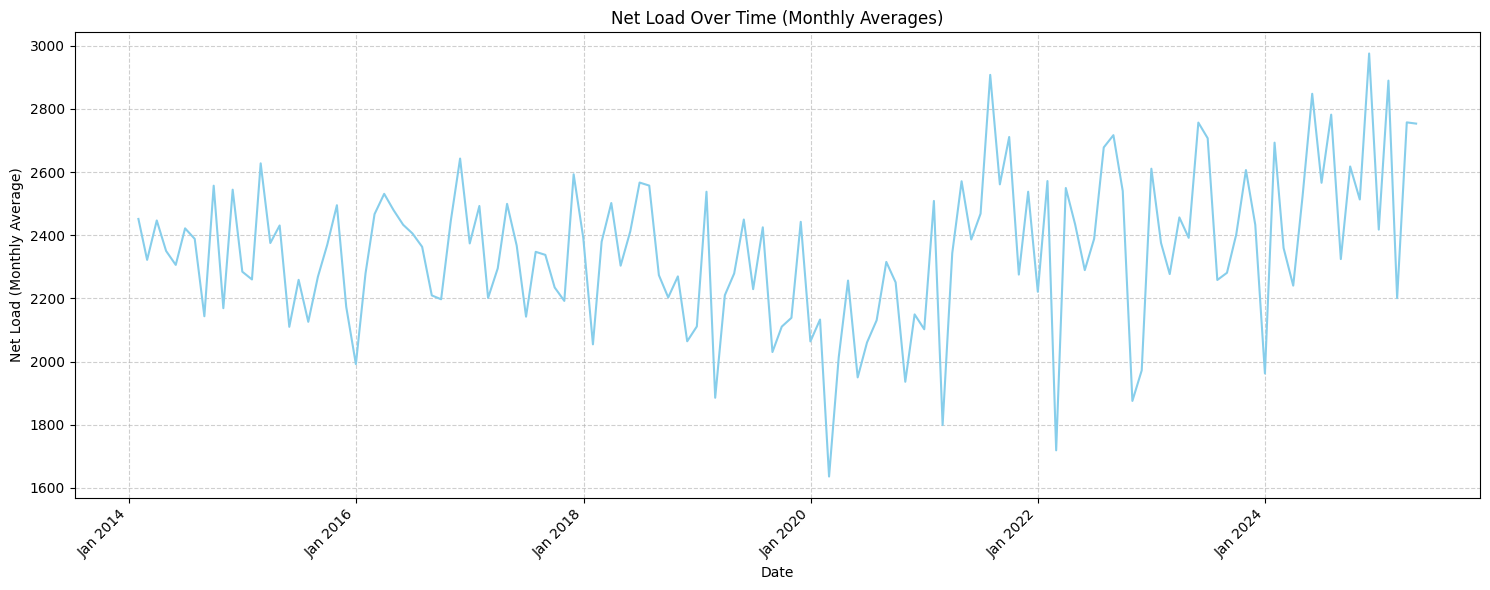

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a copy of the DataFrame with only the required columns
df_features_copy = df_features[['DateTime', 'Net_load']].copy()

# Convert the 'DateTime' column to datetime objects
df_features_copy['DateTime'] = pd.to_datetime(df_features_copy['DateTime'])

# Set the 'DateTime' column as the index
df_features_resampled = df_features_copy.set_index('DateTime')

# Resample the data to a 'M' (month-end) frequency, taking the mean of 'Net_load'
df_monthly_avg = df_features_resampled['Net_load'].resample('ME').mean()

# Create the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the resampled data
ax.plot(df_monthly_avg.index, df_monthly_avg.values, color='skyblue')

# Clear any existing formatters/locators first
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Add labels and title
ax.set_title('Net Load Over Time (Monthly Averages)')
ax.set_xlabel('Date')
ax.set_ylabel('Net Load (Monthly Average)')

# Rotate the labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Grid and layout
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

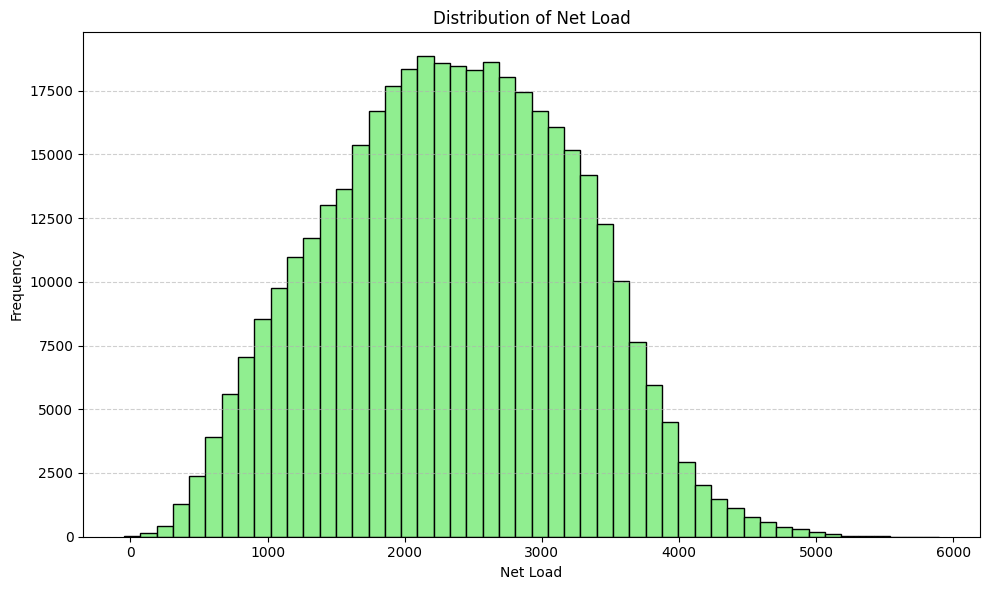

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_features['Net_load'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribution of Net Load')
plt.xlabel('Net Load')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

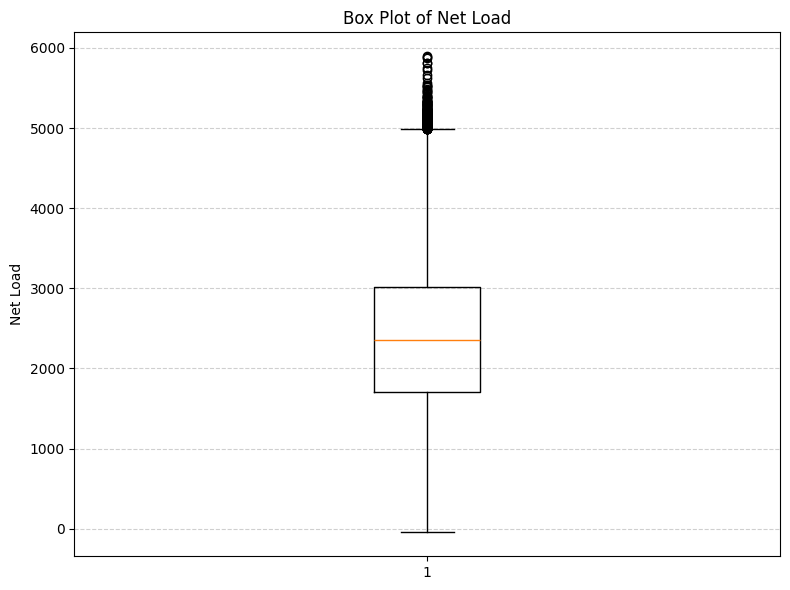

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.boxplot(df_features['Net_load'])
plt.title('Box Plot of Net Load')
plt.ylabel('Net Load')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Code Cell: Identify and print duplicate timestamps in the index of df_features

# Boolean mask of duplicated index entries (marking all but the first occurrence)
dup_mask = df_features[['DateTime']].duplicated(keep=False)

# Extract and display the duplicated timestamps and corresponding rows
duplicates = df_features[dup_mask]
print(f"Found {duplicates.shape[0]} rows with duplicate timestamps:")

Found 88 rows with duplicate timestamps:


In [ ]:
duplicates.head(20)

DateTime  IE Generation  IE Demand  IE Wind Availability  \
28608  2014-10-26 01:00:00        2482.68    2210.79               1605.05   
28609  2014-10-26 01:00:00        2579.79    2377.76               1658.46   
28610  2014-10-26 01:15:00        2526.61    2333.24               1669.83   
28611  2014-10-26 01:15:00        2520.86    2176.89               1618.10   
28612  2014-10-26 01:30:00        2555.94    2291.33               1682.54   
28613  2014-10-26 01:30:00        2478.66    2135.26               1630.32   
28614  2014-10-26 01:45:00        2503.68    2228.51               1645.32   
28615  2014-10-26 01:45:00        2446.04    2102.92               1632.08   
63552  2015-10-25 01:00:00        2515.35    2396.74                518.17   
63553  2015-10-25 01:00:00        2483.45    2231.55                546.10   
63554  2015-10-25 01:15:00        2471.51    2347.84                510.93   
63555  2015-10-25 01:15:00        2462.71    2203.49                546.42   
63556  2015-10-25 01:30:00        2433.16    2167.48                561.17   
63557  2015-10-25 01:30:00        2453.96    2305.05                535.40   
63558  2015-10-25 01:45:00        2476.48    2149.98                581.99   
63559  2015-10-25 01:45:00        2513.64    2271.06                550.70   
99168  2016-10-30 01:00:00        2794.45    2497.49                700.96   
99169  2016-10-30 01:00:00        2710.60    2332.15                540.40   
99170  2016-10-30 01:15:00        2776.81    2451.96                634.68   
99171  2016-10-30 01:15:00        2666.71    2298.40                519.20   

       IE Wind Generation    SNSP  interconnection  NW_temp   NW_wdsp  \
28608             1331.10  0.5011           -280.0    11.46  16.67094   
28609             1344.66  0.4990           -280.0    11.49  16.77514   
28610             1333.18  0.5069           -280.0    11.45  16.68467   
28611             1310.51  0.4885           -280.0    11.42  16.17379   
28612             1346.76  0.4971           -280.0    11.04  15.84704   
28613             1283.98  0.4864           -280.0    11.02  15.06979   
28614             1335.14  0.5010           -280.0    11.06  15.08352   
28615             1269.85  0.4879           -280.0    11.09  15.76867   
63552              516.69  0.1974             35.0     6.06   7.40287   
63553              542.95  0.2217             35.0     6.01   7.69141   
63554              507.41  0.1959            -36.0     6.05   7.74271   
63555              537.83  0.2221            -36.0     6.07   7.80291   
63556              554.76  0.2288            -83.0     6.06   7.55800   
63557              528.51  0.2064            -83.0     6.09   7.07773   
63558              575.54  0.2302           -108.0     6.07   7.81156   
63559              547.18  0.2195           -108.0     6.03   7.84936   
99168              687.60  0.2209              0.0    10.49   7.06744   
99169              533.22  0.1822              0.0    10.47   7.12838   
99170              628.04  0.2047              0.0    10.46   7.19521   
99171              513.24  0.1823              0.0    10.49   7.18952   

       NW_wddir  NE_temp   NE_wdsp  NE_wddir  SW_temp   SW_wdsp  SW_wddir  \
28608  221.7687    11.50  17.20330  221.8578    12.39  16.19758  218.1086   
28609  221.8543    11.51  17.53693  221.3626    12.39  16.53964  218.6508   
28610  221.1372    11.56  17.49363  221.3123    12.39  16.71723  218.9234   
28611  221.0217    11.53  17.69366  221.9296    12.30  16.75635  218.5672   
28612  218.9743    11.54  16.32019  221.9188    12.22  17.59148  224.6939   
28613  218.6884    11.59  16.90610  221.3240    12.28  17.81822  224.7523   
28614  218.5735    11.54  16.26669  221.6783    12.26  17.59379  224.5672   
28615  218.2388    11.55  16.46947  221.6437    12.28  17.94102  224.8865   
63552  234.7322     5.56   9.18806  220.5627     8.85  10.78702  234.3756   
63553  234.0560     5.54   9.23753  220.8623     8.81  10.88034  234.1541  

In [ ]:
# Create df_features1 with only the 'DateTime' column
df_features1 = df_features[['DateTime']].copy()

In [ ]:
df_features1

DateTime
0       2014-01-01 00:00:00
1       2014-01-01 00:15:00
2       2014-01-01 00:30:00
3       2014-01-01 00:45:00
4       2014-01-01 01:00:00
...                     ...
397239  2025-04-30 22:45:00
397240  2025-04-30 23:00:00
397241  2025-04-30 23:15:00
397242  2025-04-30 23:30:00
397243  2025-04-30 23:45:00

[397244 rows x 1 columns]

In [ ]:
# Step 1: Ensure 'DateTime' column is in datetime format and the DataFrame is sorted by 'DateTime' and reset its index.
df_features1['DateTime'] = pd.to_datetime(df_features1['DateTime'])
df_features1 = df_features1.sort_values(by='DateTime').reset_index(drop=True)

# Step 2: Initialize the new column 'DateTime1'
df_features1['DateTime1'] = pd.NaT

# Step 3: Initialize the current_expected_timestamp
if not df_features1.empty:
    current_expected_timestamp = df_features1.loc[0, 'DateTime']
else:
    # Handle the case of an empty DataFrame to prevent errors
    current_expected_timestamp = pd.NaT # No need to proceed if df is empty

# Define the 15-minute time delta
fifteen_minutes = pd.Timedelta(minutes=15)

# Step 4: Loop through the DataFrame to apply the sequential logic
for i in range(len(df_features1)):
    original_datetime = df_features1.loc[i, 'DateTime']

    # Logic:
    # If the original_datetime for the current row is *ahead* of
    # our `current_expected_timestamp` (meaning there was a gap),
    # we reset `current_expected_timestamp` to align with this new original_datetime.
    if original_datetime > current_expected_timestamp:
        current_expected_timestamp = original_datetime

    # Assign the determined `current_expected_timestamp` to DateTime1 for the current row.
    df_features1.loc[i, 'DateTime1'] = current_expected_timestamp

    # Increment `current_expected_timestamp` by 15 minutes for the next iteration.
    # This ensures that subsequent rows (including original duplicates) get unique
    # values at 15-minute intervals.
    current_expected_timestamp += fifteen_minutes

In [ ]:
# Display the first 20 rows of the DataFrame with the new DateTime1 column
df_features1

DateTime           DateTime1
0      2014-01-01 00:00:00 2014-01-01 00:00:00
1      2014-01-01 00:15:00 2014-01-01 00:15:00
2      2014-01-01 00:30:00 2014-01-01 00:30:00
3      2014-01-01 00:45:00 2014-01-01 00:45:00
4      2014-01-01 01:00:00 2014-01-01 01:00:00
...                    ...                 ...
397239 2025-04-30 22:45:00 2025-04-30 22:45:00
397240 2025-04-30 23:00:00 2025-04-30 23:00:00
397241 2025-04-30 23:15:00 2025-04-30 23:15:00
397242 2025-04-30 23:30:00 2025-04-30 23:30:00
397243 2025-04-30 23:45:00 2025-04-30 23:45:00

[397244 rows x 2 columns]

In [ ]:
# Code Cell: Identify and print duplicate timestamps in the 'DateTime' column in df_features1

# Boolean mask of duplicated index entries (marking all but the first occurrence)
dup_mask1 = df_features1[['DateTime']].duplicated(keep=False)

# Extract and display the duplicated timestamps and corresponding rows
duplicates1 = df_features1[dup_mask1]
print(f"Found {duplicates1.shape[0]} rows with duplicate timestamps:")

Found 88 rows with duplicate timestamps:


In [ ]:
# Code Cell: Identify and print duplicate timestamps in the 'DateTime1' column in df_features1

# Boolean mask of duplicated index entries (marking all but the first occurrence)
dup_mask2 = df_features1[['DateTime1']].duplicated(keep=False)

# Extract and display the duplicated timestamps and corresponding rows
duplicates2 = df_features1[dup_mask2]
print(f"Found {duplicates2.shape[0]} rows with duplicate timestamps:")

Found 0 rows with duplicate timestamps:


In [ ]:
# Verify that 'DateTime' column in df_features has no duplicates and is indeed at 15-minute intervals
print("Verification:")
print(f"Are there any duplicates in 'DateTime'? {df_features['DateTime'].duplicated().any()}")
print(f"Number of unique values in 'DateTime': {df_features['DateTime'].nunique()}")
print(f"Total number of rows: {len(df_features)}")

Verification:
Are there any duplicates in 'DateTime'? False
Number of unique values in 'DateTime': 397244
Total number of rows: 397244


In [ ]:
df_features = df_features.set_index("DateTime")
df_features.index = pd.to_datetime(df_features.index)

In [ ]:
df_features

IE Generation  IE Demand  IE Wind Availability  \
DateTime                                                              
2014-01-01 00:00:00        2752.48    2898.72               1053.11   
2014-01-01 00:15:00        2733.59    2868.97               1021.59   
2014-01-01 00:30:00        2686.17    2826.42                972.06   
2014-01-01 00:45:00        2657.56    2786.94                985.81   
2014-01-01 01:00:00        2584.65    2723.94                958.63   
...                            ...        ...                   ...   
2025-04-30 22:45:00        2793.06    3729.58                293.64   
2025-04-30 23:00:00        2701.46    3659.91                301.51   
2025-04-30 23:15:00        2609.66    3584.72                311.83   
2025-04-30 23:30:00        2656.05    3508.22                294.79   
2025-04-30 23:45:00        2664.68    3444.59                276.36   

                     IE Wind Generation    SNSP  interconnection  NW_temp  \
DateTime                                                                    
2014-01-01 00:00:00             1020.23  0.4579         285.0000     4.92   
2014-01-01 00:15:00              995.07  0.4505         285.0000     4.99   
2014-01-01 00:30:00              932.71  0.4383         285.0000     4.98   
2014-01-01 00:45:00              959.06  0.4447         285.0000     4.92   
2014-01-01 01:00:00              920.82  0.4429         285.0000     4.68   
...                                 ...     ...              ...      ...   
2025-04-30 22:45:00              235.55  0.2763         493.2283    13.91   
2025-04-30 23:00:00              244.82  0.2806         481.4779    12.82   
2025-04-30 23:15:00              253.29  0.2877         539.7085    12.83   
2025-04-30 23:30:00              234.60  0.2812         494.0692    12.80   
2025-04-30 23:45:00              217.27  0.2773         458.4696    12.84   

                      NW_wdsp  NW_wddir  NE_temp   NE_wdsp  NE_wddir  SW_temp  \
DateTime                                                                        
2014-01-01 00:00:00  11.76827  185.6941     4.75  12.31187  180.9850     6.79   
2014-01-01 00:15:00  11.13026  185.5634     4.77  12.27351  180.4965     6.75   
2014-01-01 00:30:00  11.65589  185.9691     4.76  12.10519  180.1353     6.77   
2014-01-01 00:45:00  11.46710  185.5288     4.74  12.57654  180.7657     6.78   
2014-01-01 01:00:00  12.78372  183.0950     4.23  10.42067  181.3148     6.67   
...                       ...       ...      ...       ...       ...      ...   
2025-04-30 22:45:00   5.72776  333.8041    13.91   5.12810  171.4281    14.42   
2025-04-30 23:00:00   5.46090  343.2643    12.63   4.08157  181.7638    13.06   
2025-04-30 23:15:00   5.54175  343.9887    12.69   4.10644  181.5209    13.09   
2025-04-30 23:30:00   5.30220  343.5183    12.68   4.47666  181.0784    13.02   
2025-04-30 23:45:00   5.62626  343.4930    12.62   4.79627  181.2508    13.08   

                      SW_wdsp  SW_wddir  SE_temp   SE_wdsp  SE_wddir  Net_load  
DateTime                                                                        
2014-01-01 00:00:00  13.34184  197.5041     5.62  11.82582  194.1166   1878.49  
2014-01-01 00:15:00  13.68342  197.5874     5.65  11.23969  194.1401   1873.90  
2014-01-01 00:30:00  13.88252  197.7414     5.61  11.76227  194.5882   1893.71  
2014-01-01 00:45:00  13.21318  197.6124     5.67  11.45572  194.3019   1827.88  
2014-01-01 01:00:00  13.38193  189.7843     5.94  13.60537  187.9590   1803.12  
...                       ...       ...      ...       ...       ...       ...  
2025-04-30 22:45:00   6.11409   71.9651    14.46   5.65387  117.1473   3494.03  
2025-04-30 23:00:00   4.68742   41.8171    13.59   5.07615  110.2740   3415.09  
2025-04-30 23:15:00   4.70559   41.8753    13.51   5.91819  110.7325   3331.43  
2025-04-30 23:30:00   4.46818   41.4496    13.53   5.19841  110.1437   3273.62  
2025-04-30 23:45:00   4.99804   41.3431    13.55   5.33499  110.7636 

In [ ]:
# Code Cell: Persistence Benchmark (1-hour ahead)

def persistence_forecast(series: pd.Series, horizon: int = 4) -> pd.Series:
    """
    Returns a Series of persistence forecasts for the given horizon steps ahead.
    series: time-indexed Series of actual wind generation
    horizon: number of 15-min steps ahead (4 → 1 hour)
    """
    return series.shift(horizon).rename("persistence_forecast")

# Apply to your wind generation column
df_features["pers_1h"] = persistence_forecast(df_features["IE Wind Generation"], horizon=4)

In [ ]:
# Code Cell: Full in‐sample ARIMA‐GARCH 1h Benchmarks (only 4 NaNs)

# 0. Ensure regular 15-min index
df_features = df_features.asfreq("15min")

# 1. Fit ARIMA on 2014–2022
train = df_features["IE Wind Generation"]["2014":"2022"]
arima_res = ARIMA(train, order=(2,1,2)).fit()

# 2. In‐sample one-step-ahead ARIMA mean forecasts
#    get_prediction by default gives one-step forecasts at each point
insamp = arima_res.get_prediction(start="2014-01-01", end="2025-04-30")
# Align so that the forecast for t actually lives at t (i.e. shift by 0 because get_prediction is already one-step)
df_features["arima_mean_1h"] = insamp.predicted_mean

# 3. Fit GARCH on the ARIMA residuals
resids = arima_res.resid.dropna()
garch_res = arch_model(resids, vol="Garch", p=1, q=1).fit(disp="off")

# 4. In‐sample GARCH variance (from the fitted model)
#    conditional_volatility is the in-sample σ_t; square it to get variance
df_features.loc[resids.index, "garch_var_1h"] = garch_res.conditional_volatility**2

# 5. Out-of-sample GARCH variance (on hold-out) via lightweight loop
holdout = df_features.loc["2023":"2025-04-30"]
garch_out = []
hist = resids.copy()
for ts in holdout.index:
    # forecast σ² at t using history up to t–1
    var_h = garch_res.forecast(horizon=1, reindex=False).variance.iloc[-1, 0]
    garch_out.append(var_h)
    # update history with the new residual
    new_res = df_features.at[ts, "IE Wind Generation"] - df_features.at[ts, "arima_mean_1h"]
    hist.loc[ts] = new_res
df_features.loc[holdout.index, "garch_var_1h"] = garch_out

# 6. Final combined point‐forecast
df_features["arima_garch_1h"] = df_features["arima_mean_1h"]

# Verify NaNs
print(df_features[["arima_mean_1h","garch_var_1h","arima_garch_1h"]].isna().sum())

arima_mean_1h     95
garch_var_1h       4
arima_garch_1h    95
dtype: int64


In [ ]:
# 1. Print the number of NaNs per column
nan_counts = df_features.isna().sum()
print("NaN counts per column:\n", nan_counts)

NaN counts per column:
 IE Generation            4
IE Demand                4
IE Wind Availability     4
IE Wind Generation       4
SNSP                     4
interconnection          4
NW_temp                  4
NW_wdsp                  4
NW_wddir                 4
NE_temp                  4
NE_wdsp                  4
NE_wddir                 4
SW_temp                  4
SW_wdsp                  4
SW_wddir                 4
SE_temp                  4
SE_wdsp                  4
SE_wddir                 4
Net_load                 4
pers_1h                  8
arima_mean_1h           95
garch_var_1h             4
arima_garch_1h          95
dtype: int64


In [ ]:
# Code Cell: Display timestamps where pers_1h is NaN

# Extract the index values where the 1-hour persistence forecast is NaN
nan_timestamps = df_features.index[df_features["pers_1h"].isna()]

# Display these timestamps
print("Timestamps with NaN in pers_1h:")
for ts in nan_timestamps:
    print(ts)

Timestamps with NaN in pers_1h:
2014-01-01 00:00:00
2014-01-01 00:15:00
2014-01-01 00:30:00
2014-01-01 00:45:00
2014-03-30 01:00:00
2014-03-30 01:15:00
2014-03-30 01:30:00
2014-03-30 01:45:00


In [ ]:
# Code Cell: Display timestamps and NaN status for arima_mean_1h and arima_garch_1h

# Filter rows where either arima_mean_1h or arima_garch_1h is NaN
nan_rows = df_features[
    df_features["arima_mean_1h"].isna() | df_features["arima_garch_1h"].isna()
][["arima_mean_1h", "arima_garch_1h"]]

# Display the index and corresponding NaN columns
print("Rows with NaNs in arima_mean_1h or arima_garch_1h:")
print(nan_rows)

Rows with NaNs in arima_mean_1h or arima_garch_1h:
                     arima_mean_1h  arima_garch_1h
DateTime                                          
2025-04-30 00:15:00            NaN             NaN
2025-04-30 00:30:00            NaN             NaN
2025-04-30 00:45:00            NaN             NaN
2025-04-30 01:00:00            NaN             NaN
2025-04-30 01:15:00            NaN             NaN
...                            ...             ...
2025-04-30 22:45:00            NaN             NaN
2025-04-30 23:00:00            NaN             NaN
2025-04-30 23:15:00            NaN             NaN
2025-04-30 23:30:00            NaN             NaN
2025-04-30 23:45:00            NaN             NaN

[95 rows x 2 columns]


In [ ]:
nan_rows

arima_mean_1h  arima_garch_1h
DateTime                                          
2025-04-30 00:15:00            NaN             NaN
2025-04-30 00:30:00            NaN             NaN
2025-04-30 00:45:00            NaN             NaN
2025-04-30 01:00:00            NaN             NaN
2025-04-30 01:15:00            NaN             NaN
...                            ...             ...
2025-04-30 22:45:00            NaN             NaN
2025-04-30 23:00:00            NaN             NaN
2025-04-30 23:15:00            NaN             NaN
2025-04-30 23:30:00            NaN             NaN
2025-04-30 23:45:00            NaN             NaN

[95 rows x 2 columns]

In [ ]:
# Code Cell: Drop rows with NaN in both arima_mean_1h and pers_1h

df_features = df_features.dropna(subset=["arima_mean_1h", "pers_1h"], how="any")

In [ ]:
# 1. Print the number of NaNs per column
nan_counts = df_features.isna().sum()
print("NaN counts per column:\n", nan_counts)

NaN counts per column:
 IE Generation           0
IE Demand               0
IE Wind Availability    0
IE Wind Generation      0
SNSP                    0
interconnection         0
NW_temp                 0
NW_wdsp                 0
NW_wddir                0
NE_temp                 0
NE_wdsp                 0
NE_wddir                0
SW_temp                 0
SW_wdsp                 0
SW_wddir                0
SE_temp                 0
SE_wdsp                 0
SE_wddir                0
Net_load                0
pers_1h                 0
arima_mean_1h           0
garch_var_1h            0
arima_garch_1h          0
dtype: int64


In [ ]:
# Code Cell: Truncated‐Normal Exponential‐Smoothing Benchmark (1-hour ahead)
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import pandas as pd

# 2. Split into train (2014–2022) and hold-out (2023–2025-04-30)
train   = df_features["IE Wind Generation"]["2014":"2022"]
holdout = df_features["IE Wind Generation"]["2023":"2025-04-30"]

# 3. Fit Simple Exp Smoothing by hand: fix α and skip MLE
ses_model = SimpleExpSmoothing(
    train,
    initialization_method="legacy-heuristic"  # robust initial level heuristic
).fit(
    smoothing_level=0.2,   # fixed α (tune via CV on 2014–22)
    optimized=False        # skip optimization to avoid NaNs
)

# 4. In-sample one-step-ahead mean forecasts
insamp_pred = ses_model.predict(start=train.index[0], end=train.index[-1])
df_features.loc[train.index, "exp_mean_1h"] = insamp_pred.values

# 5. Out-of-sample mean forecasts
out_of_samp = ses_model.forecast(steps=len(holdout))
df_features.loc[holdout.index, "exp_mean_1h"] = out_of_samp.values

# 6. Compute variance via EWMA on residuals (using fixed α)
resids     = train - insamp_pred
alpha      = ses_model.model.params["smoothing_level"]
exp_var    = pd.Series(index=train.index, dtype=float)
exp_var.iloc[0] = resids.var()

for i in range(1, len(resids)):
    exp_var.iloc[i] = alpha * resids.iloc[i-1]**2 + (1 - alpha) * exp_var.iloc[i-1]
df_features.loc[train.index, "exp_var_1h"] = exp_var.values

# 7. Extend variance forecast into hold-out
prev_sigma2 = exp_var.iloc[-1]
exp_var_out = []

for idx in holdout.index:
    actual = df_features.at[idx, "IE Wind Generation"]
    mu     = df_features.at[idx, "exp_mean_1h"]
    sigma2 = alpha * (actual - mu)**2 + (1 - alpha) * prev_sigma2
    exp_var_out.append(sigma2)
    prev_sigma2 = sigma2

df_features.loc[holdout.index, "exp_var_1h"] = exp_var_out

# 8. Quick check
print("NaNs in exp_mean_1h and exp_var_1h:",
      df_features[["exp_mean_1h", "exp_var_1h"]].isna().sum())

c:\Users\m1029\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\m1029\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\m1029\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


NaNs in exp_mean_1h and exp_var_1h: exp_mean_1h    0
exp_var_1h     0
dtype: int64


In [ ]:
# 1. Print the number of NaNs per column
nan_counts = df_features.isna().sum()
print("NaN counts per column:\n", nan_counts)

NaN counts per column:
 IE Generation           0
IE Demand               0
IE Wind Availability    0
IE Wind Generation      0
SNSP                    0
interconnection         0
NW_temp                 0
NW_wdsp                 0
NW_wddir                0
NE_temp                 0
NE_wdsp                 0
NE_wddir                0
SW_temp                 0
SW_wdsp                 0
SW_wddir                0
SE_temp                 0
SE_wdsp                 0
SE_wddir                0
Net_load                0
pers_1h                 0
arima_mean_1h           0
garch_var_1h            0
arima_garch_1h          0
exp_mean_1h             0
exp_var_1h              0
dtype: int64


In [ ]:
# Code Cell: Compute net-load residuals for each benchmark

# Forecasted net-load = actual demand − forecasted wind
# Actual net-load = demand − actual wind  (already in df_features["Net_load"])

df_features["resid_pers"]  = (df_features["IE Demand"] - df_features["pers_1h"])  - df_features["Net_load"]
df_features["resid_arima"] = (df_features["IE Demand"] - df_features["arima_garch_1h"]) - df_features["Net_load"]
df_features["resid_exp"]   = (df_features["IE Demand"] - df_features["exp_mean_1h"]) - df_features["Net_load"]

# Quick sanity check
print(df_features[["resid_pers", "resid_arima", "resid_exp"]].isna().sum())

resid_pers     0
resid_arima    0
resid_exp      0
dtype: int64


In [ ]:
print(df_features[["resid_pers", "resid_arima", "resid_exp"]].head(10))

                     resid_pers  resid_arima  resid_exp
DateTime                                               
2014-01-01 01:00:00      -99.41   -41.301816   0.000000
2014-01-01 01:15:00      -64.42    30.928381   9.830000
2014-01-01 01:30:00      -50.53   -47.934579 -40.606000
2014-01-01 01:45:00      -36.16    63.860639   8.235200
2014-01-01 02:00:00       -1.33   -13.157925   3.178160
2014-01-01 02:15:00       13.01    30.955062  26.712528
2014-01-01 02:30:00       62.28    -7.357069  22.170022
2014-01-01 02:45:00       23.74     2.652176  19.916018
2014-01-01 03:00:00      -20.05   -49.511199 -31.267186
2014-01-01 03:15:00      -14.79    45.314676   4.416251


In [ ]:
# Code Cell: Summary of forecasting metrics (in‐sample & hold‐out)

# 1. Masks
train_mask   = df_features.index <  "2023-01-01"
holdout_mask = df_features.index >= "2023-01-01"

# 2. Actuals
y_train = df_features.loc[train_mask, "IE Wind Generation"]
y_test  = df_features.loc[holdout_mask, "IE Wind Generation"]

# 3. Forecast dictionaries
forecasts = {
    "Persistence":   ("pers_1h",    None),  # no variance
    "ARIMA-GARCH":   ("arima_garch_1h", "garch_var_1h"),
    "Exp-Smoothing": ("exp_mean_1h",    "exp_var_1h"),
}

# 4. Precompute z values
from scipy.stats import norm
z80, z95 = norm.ppf(0.90), norm.ppf(0.975)

# 5. Collect metrics
rows = []
for name, (col_mean, col_var) in forecasts.items():
    for period, y_true, df in [
        ("InSample", y_train, df_features.loc[train_mask]),
        ("HoldOut",  y_test,  df_features.loc[holdout_mask]),
    ]:
        y_pred = df[col_mean]
        mae  = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        # coverage
        if col_var is not None:
            sigma = np.sqrt(df[col_var])
            cov80 = np.mean((y_true >= (y_pred - z80*sigma)) & (y_true <= (y_pred + z80*sigma)))
            cov95 = np.mean((y_true >= (y_pred - z95*sigma)) & (y_true <= (y_pred + z95*sigma)))
        else:
            cov80 = cov95 = np.nan
        rows.append({
            "Method": name,
            "Period": period,
            "MAE": mae,
            "RMSE": rmse,
            "Cov_80%": cov80,
            "Cov_95%": cov95,
        })

df_forecast_metrics = pd.DataFrame(rows).set_index(["Method","Period"])
print(df_forecast_metrics)

                               MAE         RMSE   Cov_80%   Cov_95%
Method        Period                                               
Persistence   InSample   75.594784   109.605270       NaN       NaN
              HoldOut   102.117073   142.769775       NaN       NaN
ARIMA-GARCH   InSample   23.022044    33.747287  0.821058  0.941745
              HoldOut   921.825008  1216.451927  0.057916  0.087646
Exp-Smoothing InSample   77.023023   110.639367  0.774104  0.954640
              HoldOut   927.267554  1223.698451  0.947488  0.999975


In [ ]:
# 1. Masks
train_mask   = df_features.index <  "2023-01-01"
holdout_mask = df_features.index >= "2023-01-01"

# 2. Actuals
y_train = df_features.loc[train_mask, "IE Wind Generation"]
y_test  = df_features.loc[holdout_mask, "IE Wind Generation"]

# df_features3

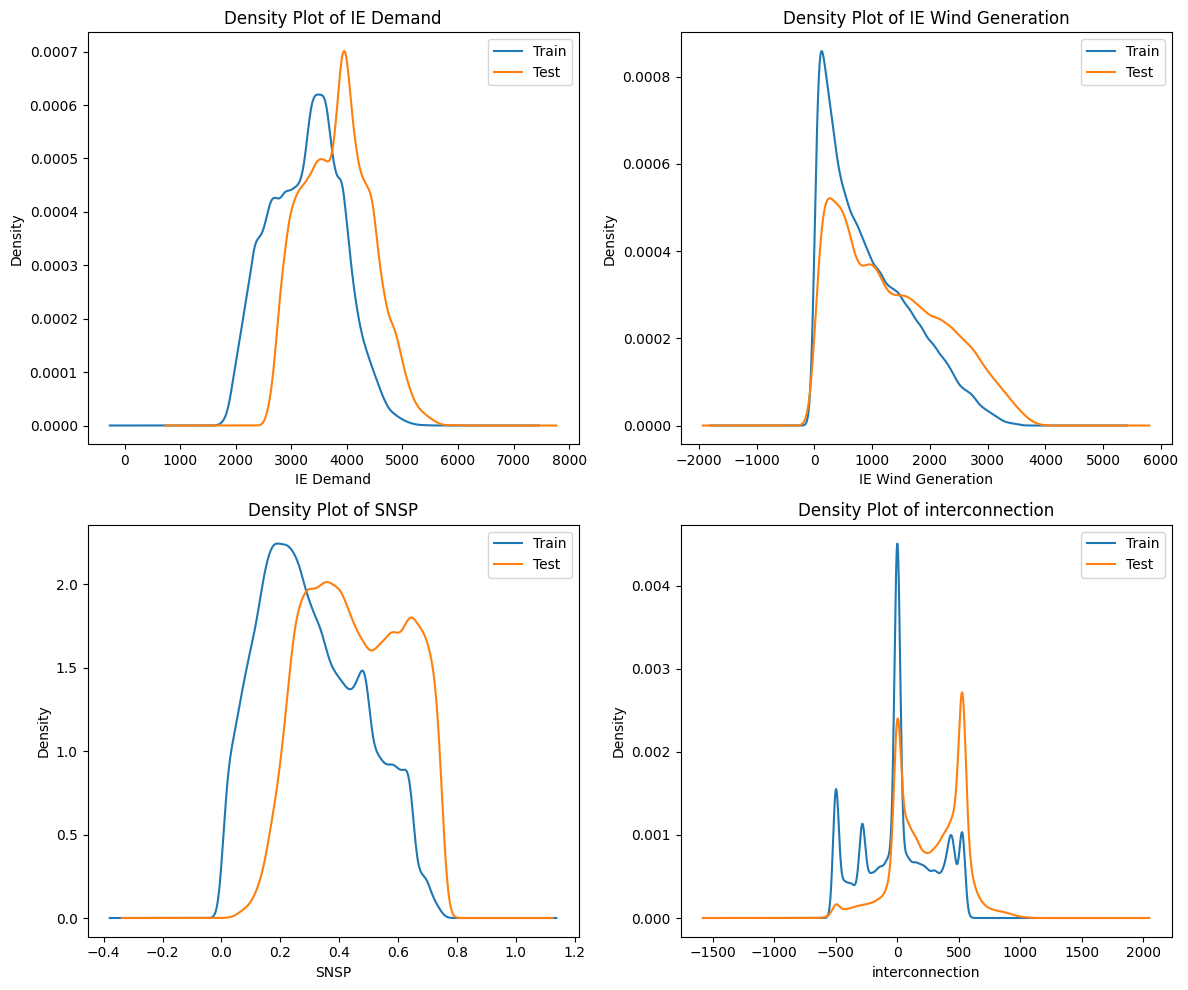

In [ ]:
import matplotlib.pyplot as plt

# Columns to plot
columns = [
    'IE Demand', 'IE Wind Generation',
    'SNSP', 'Net_load'
]

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, col in zip(axes, columns):
    # Plot train density
    df_features.loc[train_mask, col].plot(
        kind='density', ax=ax, label='Train'
    )
    # Plot test density
    df_features.loc[holdout_mask, col].plot(
        kind='density', ax=ax, label='Test'
    )
    ax.set_title(f'Density Plot of {col}')
    ax.set_xlabel(col)
    ax.legend()

plt.tight_layout()
plt.show()

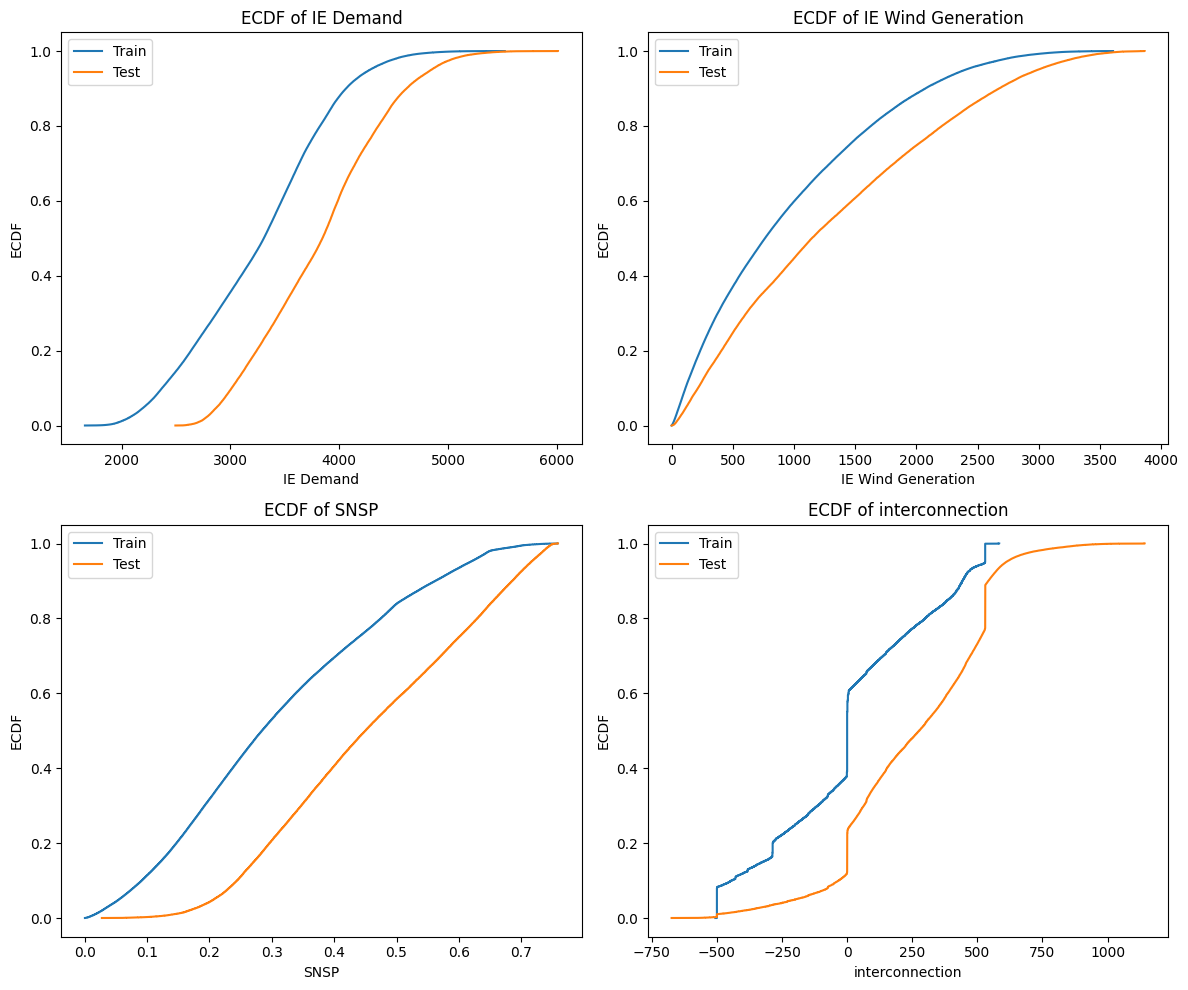

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Net Load
# Columns to plot
columns = [
    'IE Demand', 'IE Wind Generation',
    'SNSP', 'Net_load'
]

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, col in zip(axes, columns):
    # Train ECDF
    train_vals = np.sort(df_features.loc[train_mask, col].values)
    train_ecdf = np.arange(1, len(train_vals) + 1) / len(train_vals)
    ax.step(train_vals, train_ecdf, where='post', label='Train')

    # Test ECDF
    test_vals = np.sort(df_features.loc[holdout_mask, col].values)
    test_ecdf = np.arange(1, len(test_vals) + 1) / len(test_vals)
    ax.step(test_vals, test_ecdf, where='post', label='Test')

    ax.set_title(f'ECDF of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('ECDF')
    ax.legend()

plt.tight_layout()
plt.show()

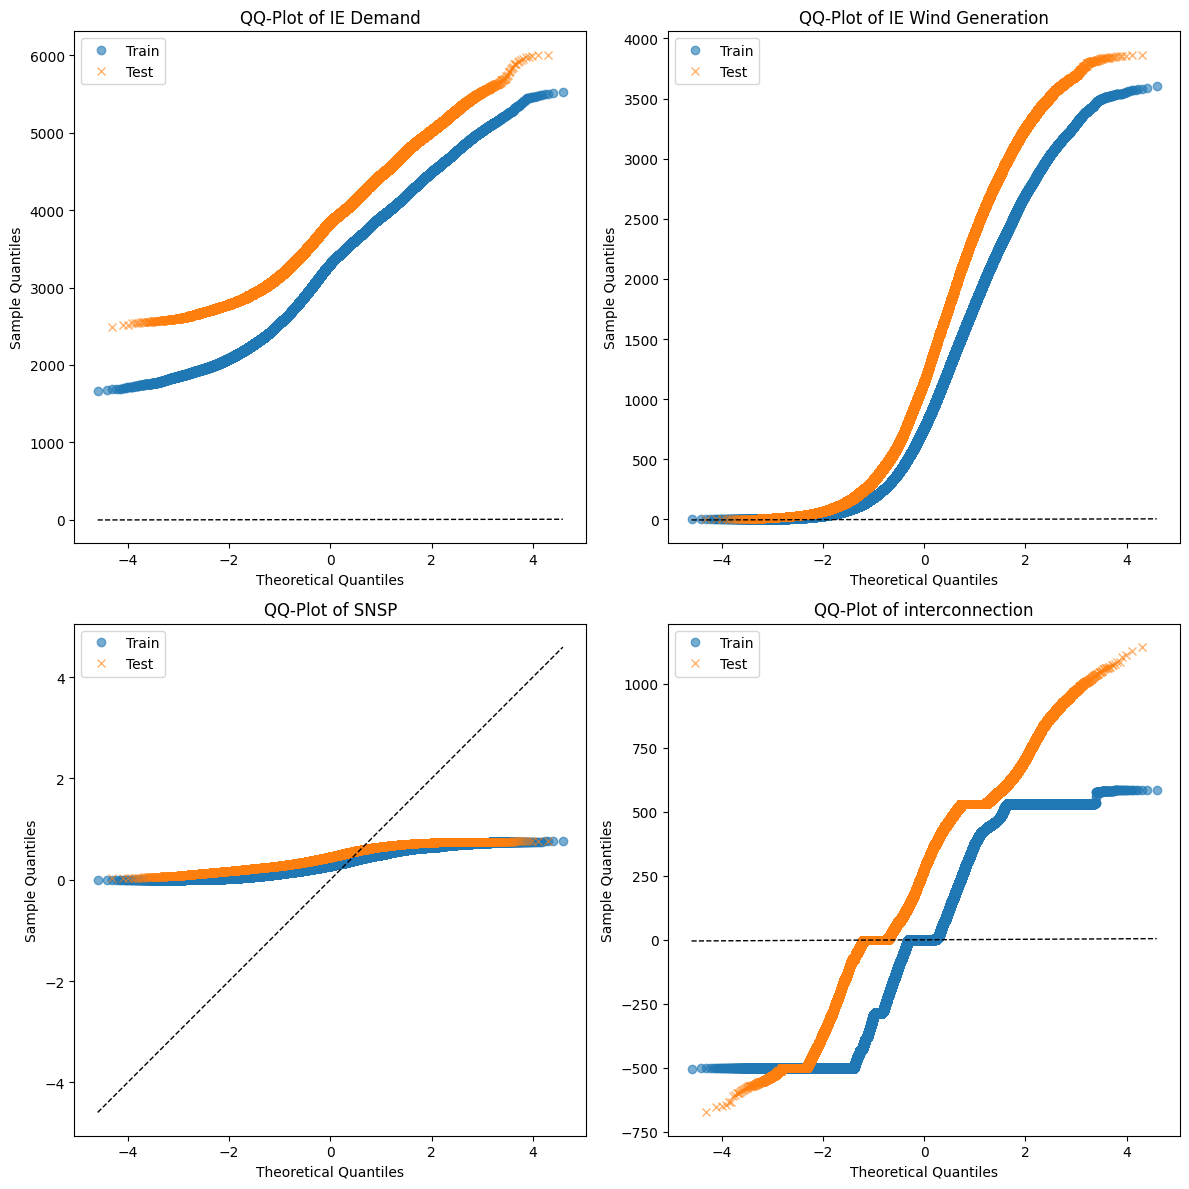

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Columns to plot
columns = [
    'IE Demand', 'IE Wind Generation',
    'SNSP', 'Net_load'
]

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for ax, col in zip(axes, columns):
    # Extract train and test samples
    train_vals = df_features.loc[train_mask, col].dropna().values
    test_vals  = df_features.loc[holdout_mask, col].dropna().values

    # QQ‐plot for Train (fit=False returns only the quantiles)
    osm_train, osr_train = stats.probplot(train_vals, dist="norm", fit=False, plot=None)
    ax.plot(osm_train, osr_train, 'o', label='Train', alpha=0.6)

    # QQ‐plot for Test
    osm_test, osr_test = stats.probplot(test_vals, dist="norm", fit=False, plot=None)
    ax.plot(osm_test, osr_test, 'x', label='Test', alpha=0.6)

    # Plot the 45-degree reference line
    min_val = min(osm_train.min(), osm_test.min())
    max_val = max(osm_train.max(), osm_test.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

    ax.set_title(f'QQ‐Plot of {col}')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')
    ax.legend()

plt.tight_layout()
plt.show()

# LSTM Network

In [ ]:
bench_cols = ["pers_1h","arima_mean_1h","garch_var_1h",
              "arima_garch_1h","exp_mean_1h","exp_var_1h",
              "resid_pers","resid_arima","resid_exp"]
model_df = df_features.drop(columns=bench_cols)

In [ ]:
# Create lag features
for lag in range(1, 5):
    model_df[f"wind_lag_{lag}"] = model_df["IE Wind Generation"].shift(lag)

# Rolling 1-hour (4×15min) stats
model_df["wind_roll1h_mean"] = model_df["IE Wind Generation"].rolling(4).mean()
model_df["wind_roll1h_std"]  = model_df["IE Wind Generation"].rolling(4).std()

# Calendar features
model_df["hour"]    = model_df.index.hour
model_df["weekday"] = model_df.index.weekday

# Quadrant meteorology
model_df["windspd_N"]  = model_df["NW_wdsp"]
model_df["windspd_E"]  = model_df["NE_wdsp"]
model_df["windspd_S"]  = model_df["SW_wdsp"]
model_df["windspd_SE"] = model_df["SE_wdsp"]

model_df["temp_N"]  = model_df["NW_temp"]
model_df["temp_E"]  = model_df["NE_temp"]
model_df["temp_S"]  = model_df["SW_temp"]
model_df["temp_SE"] = model_df["SE_temp"]

In [ ]:
nan_counts1 = model_df.isna().sum()
columns_with_nan_names = nan_counts1[nan_counts1 > 0].index.tolist()
df_subset_with_nans = model_df[columns_with_nan_names]
print("Subset of DataFrame with columns containing NaN values:")
df_subset_with_nans

Subset of DataFrame with columns containing NaN values:


wind_lag_1  wind_lag_2  wind_lag_3  wind_lag_4  \
DateTime                                                              
2014-01-01 01:00:00         NaN         NaN         NaN         NaN   
2014-01-01 01:15:00      920.82         NaN         NaN         NaN   
2014-01-01 01:30:00      930.65      920.82         NaN         NaN   
2014-01-01 01:45:00      882.18      930.65      920.82         NaN   
2014-01-01 02:00:00      922.90      882.18      930.65      920.82   
...                         ...         ...         ...         ...   
2025-04-29 23:00:00      805.60      827.51      822.32      816.14   
2025-04-29 23:15:00      802.19      805.60      827.51      822.32   
2025-04-29 23:30:00      776.80      802.19      805.60      827.51   
2025-04-29 23:45:00      799.07      776.80      802.19      805.60   
2025-04-30 00:00:00      801.59      799.07      776.80      802.19   

                     wind_roll1h_mean  wind_roll1h_std  
DateTime                                                
2014-01-01 01:00:00               NaN              NaN  
2014-01-01 01:15:00               NaN              NaN  
2014-01-01 01:30:00               NaN              NaN  
2014-01-01 01:45:00          914.1375        21.720817  
2014-01-01 02:00:00          913.8050        21.594235  
...                               ...              ...  
2025-04-29 23:00:00          814.4050        12.397883  
2025-04-29 23:15:00          803.0250        20.773330  
2025-04-29 23:30:00          795.9150        13.019371  
2025-04-29 23:45:00          794.9125        12.150425  
2025-04-30 00:00:00          801.4775        21.152647  

[397145 rows x 6 columns]

In [ ]:
# Code Cell: Backfill NaNs in lagged and rolling‐stat columns

# 1. List columns to backfill
cols_to_bfill = [
    "wind_lag_1", "wind_lag_2", "wind_lag_3", "wind_lag_4",
    "wind_roll1h_mean", "wind_roll1h_std"
]

# 2. Apply backward fill on those columns
model_df[cols_to_bfill] = model_df[cols_to_bfill].bfill()

# 3. Verify no more NaNs
print("NaNs after backfill:\n", model_df[cols_to_bfill].isna().sum())

NaNs after backfill:
 wind_lag_1          0
wind_lag_2          0
wind_lag_3          0
wind_lag_4          0
wind_roll1h_mean    0
wind_roll1h_std     0
dtype: int64


In [ ]:
# Code Cell: Reindexing to a full 15-minute grid (naive) without FutureWarning

import pandas as pd

# 1. Create a new copy
df_model1 = model_df.copy()

# 2. Build a naive 15-minute grid from min to max
full_idx = pd.date_range(
    start=df_model1.index.min(),
    end=df_model1.index.max(),
    freq='15min'   # no tz argument => naive timestamps
)

# 3. Reindex onto that grid
df_model1 = df_model1.reindex(full_idx)

# 4. Print count of NaNs in a representative column
nan_count = df_model1['IE Wind Generation'].isna().sum()
print(f"Number of NaNs in 'IE Wind Generation' after reindexing: {nan_count}")

Number of NaNs in 'IE Wind Generation' after reindexing: 4


In [ ]:
# Code Cell: Custom missing‐value filling strategy

import pandas as pd

# 1. Make a copy
df_filled = df_model1.copy()

# 2. Define meteorological and other columns
meteo_cols = [
    'NW_temp','NW_wdsp','NW_wddir',
    'NE_temp','NE_wdsp','NE_wddir',
    'SW_temp','SW_wdsp','SW_wddir',
    'SE_temp','SE_wdsp','SE_wddir',
    'windspd_N','windspd_E','windspd_S','windspd_SE',
    'temp_N','temp_E','temp_S','temp_SE'
]
other_cols = [c for c in df_filled.columns if c not in meteo_cols]

# 3. For meteorological variables: simple interpolation
df_filled[meteo_cols] = df_filled[meteo_cols].interpolate(method='time')

# 4. For the other columns:
#    a) backfill the first 20 rows
df_filled.loc[df_filled.index[:20], other_cols] = \
    df_filled.loc[df_filled.index[:20], other_cols].bfill()

#    b) now handle the rest by group‐wise logic
for col in other_cols:
    is_na = df_filled[col].isna()
    # identify contiguous NaN groups
    grp = (is_na != is_na.shift()).cumsum()  # group id for runs
    for group_id, sub in df_filled.groupby(grp):
        if not is_na.loc[sub.index[0]]:
            continue  # skip non-NaN runs
        run_len = len(sub)
        start, end = sub.index[0], sub.index[-1]
        if run_len <= 8:
            # forward‐fill short runs
            df_filled.loc[start:end, col] = df_filled[col].ffill().loc[start:end]
        else:
            # interpolate longer runs
            df_filled.loc[start:end, col] = df_filled[col].interpolate().loc[start:end]

# 5. Quick check: count remaining NaNs in any one column
print("Remaining NaNs in 'IE Wind Generation':",
      df_filled['IE Wind Generation'].isna().sum())

Remaining NaNs in 'IE Wind Generation': 0


In [ ]:
# 1. Print the number of NaNs per column
nan_counts2 = df_filled.isna().sum()
print("NaN counts per column:\n", nan_counts2)

NaN counts per column:
 IE Generation           0
IE Demand               0
IE Wind Availability    0
IE Wind Generation      0
SNSP                    0
interconnection         0
NW_temp                 0
NW_wdsp                 0
NW_wddir                0
NE_temp                 0
NE_wdsp                 0
NE_wddir                0
SW_temp                 0
SW_wdsp                 0
SW_wddir                0
SE_temp                 0
SE_wdsp                 0
SE_wddir                0
Net_load                0
wind_lag_1              0
wind_lag_2              0
wind_lag_3              0
wind_lag_4              0
wind_roll1h_mean        0
wind_roll1h_std         0
hour                    0
weekday                 0
windspd_N               0
windspd_E               0
windspd_S               0
windspd_SE              0
temp_N                  0
temp_E                  0
temp_S                  0
temp_SE                 0
dtype: int64


In [ ]:
df_filled.index.rename("DateTime", inplace=True)

In [ ]:
# Code Cell: Generate walk‐forward CV splits and drop samples too-close to edges or missing 1-hour targets (using df_filled)

import pandas as pd
from pandas.tseries.offsets import DateOffset

# 1. Define parameters
df_start    = pd.Timestamp("2014-01-01 00:00:00")
test_start  = pd.Timestamp("2024-08-01 00:00:00")
val_horizon = DateOffset(years=1)
step        = pd.Timedelta(minutes=15)
horizon     = 4 * step  # one-hour ahead
seq_len     = 16        # your sequence length

# 2. Build CV folds
folds = []
train_start = df_start
train_end   = train_start + DateOffset(years=2) - step  # initial 2-year train

while True:
    val_start        = train_end + step
    tentative_val_end = val_start + val_horizon - step
    # Cap last validation at one step before test_start
    val_end = min(tentative_val_end, test_start - step)
    folds.append({
        "train_start": train_start,
        "train_end":   train_end,
        "val_start":   val_start,
        "val_end":     val_end
    })
    if val_end >= test_start - step:
        break
    train_end = val_end  # expand training window

# 3. Convert folds to index lists, filter out indices too-close to edges, and drop missing targets
splits = []
min_ts = df_filled.index.min()
max_ts = df_filled.index.max()

for f in folds:
    all_train = df_filled.loc[f["train_start"]:f["train_end"]].index
    all_val   = df_filled.loc[f["val_start"]:  f["val_end"]  ].index

    # Only keep idx where:
    #  - we can build a full seq_len window behind it
    #  - and the horizon-ahead target exists
    train_idx = [
        idx for idx in all_train
        if (idx - seq_len*step) >= min_ts and (idx + horizon) <= max_ts
    ]
    val_idx = [
        idx for idx in all_val
        if (idx - seq_len*step) >= min_ts and (idx + horizon) <= max_ts
    ]

    splits.append((pd.DatetimeIndex(train_idx), pd.DatetimeIndex(val_idx)))

# 4. Define final test index (no filtering needed here)
test_idx = df_filled.loc[test_start:].index

# 5. Report
print(f"Generated {len(splits)} folds.")
for i, (tr, vl) in enumerate(splits, 1):
    print(f"Fold {i}: train {len(tr)} samples, val {len(vl)} samples")
print(f"Test period → {test_start.date()} to {max_ts.date()}, samples: {len(test_idx)}")

Generated 9 folds.
Fold 1: train 70060 samples, val 35136 samples
Fold 2: train 105196 samples, val 35040 samples
Fold 3: train 140236 samples, val 35040 samples
Fold 4: train 175276 samples, val 35040 samples
Fold 5: train 210316 samples, val 35136 samples
Fold 6: train 245452 samples, val 35040 samples
Fold 7: train 280492 samples, val 35040 samples
Fold 8: train 315532 samples, val 35040 samples
Fold 9: train 350572 samples, val 20448 samples
Test period → 2024-08-01 to 2025-04-30, samples: 26113


In [ ]:
# Code Cell: Define Bayesian LSTM with Monte Carlo Dropout

import torch
import torch.nn as nn
import pytorch_lightning as pl

class MCDropoutLSTM(pl.LightningModule):
    def __init__(
        self,
        input_size: int,
        hidden_size: int = 64,
        num_layers: int = 2,
        dropout: float = 0.2,
        lr: float = 1e-3
    ):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.criterion = nn.MSELoss()
        self.lr = lr

    def forward(self, x):
        # keep dropout active at inference time
        self.lstm.train(self.training)
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out).squeeze(-1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        # log only per‐epoch
        self.log("train_loss_epoch", loss,
                 on_step=False, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        # log only per‐epoch
        self.log("val_loss_epoch", loss,
                 on_step=False, on_epoch=True, prog_bar=False)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [ ]:
# MC-dropout sampling for uncertainty estimation

def mc_dropout_predict(model: MCDropoutLSTM, x: torch.Tensor, n_samples: int = 50):
    """
    Given a batch x, run the model n_samples times with dropout active,
    returning mean and std over the predictions.
    """
    model.eval()
    preds = []
    for _ in range(n_samples):
        # Force dropout on at inference
        for m in model.modules():
            if isinstance(m, nn.Dropout):
                m.train()
        preds.append(model(x).detach().cpu().numpy())
    preds = np.stack(preds, axis=0)  # (n_samples, batch)
    mean = preds.mean(axis=0)
    std  = preds.std(axis=0)
    return mean, std

In [ ]:
# Code Cell: Train MCDropoutLSTM on each walk-forward fold with logging and saving results

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.loggers import CSVLogger
import numpy as np
import pandas as pd
from datetime import datetime
import os

# 1. Hyperparameters
seq_len    = 16              # 4 hours @ 15-min steps
batch_size = 64
n_epochs   = 20
horizon    = 4 * step        # one-hour ahead
out_dir    = r"D:\Colab\Summer Project\Final\New Project\training"
os.makedirs(out_dir, exist_ok=True)

# 2. Loop over folds
for fold_i, (train_idx, val_idx) in enumerate(splits, start=1):
    # --- Prepare raw windows and targets ---
    X_train_raw, y_train = [], []
    for idx in train_idx[seq_len:]:
        window = df_filled.loc[idx - seq_len*step : idx - step].values
        target = idx + horizon
        X_train_raw.append(window)
        y_train.append(df_filled.at[target, "IE Wind Generation"])
    X_val_raw, y_val = [], []
    for idx in val_idx[seq_len:]:
        window = df_filled.loc[idx - seq_len*step : idx - step].values
        target = idx + horizon
        X_val_raw.append(window)
        y_val.append(df_filled.at[target, "IE Wind Generation"])

    # --- Stack into numpy arrays ---
    X_train_np = np.stack(X_train_raw)
    X_val_np   = np.stack(X_val_raw)

    # --- Per-fold normalization ---
    n_train, _, n_feats = X_train_np.shape
    scaler = StandardScaler()
    X_train_flat = X_train_np.reshape(-1, n_feats)
    scaler.fit(X_train_flat)
    X_train_np = scaler.transform(X_train_flat).reshape(n_train, seq_len, n_feats)
    n_val = X_val_np.shape[0]
    X_val_flat  = X_val_np.reshape(-1, n_feats)
    X_val_np    = scaler.transform(X_val_flat).reshape(n_val, seq_len, n_feats)

    # --- Convert to tensors ---
    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    y_train = torch.tensor(y_train,    dtype=torch.float32)
    X_val   = torch.tensor(X_val_np,   dtype=torch.float32)
    y_val   = torch.tensor(y_val,      dtype=torch.float32)

    # --- Build DataLoaders ---
    train_ds = TensorDataset(X_train, y_train)
    val_ds   = TensorDataset(X_val,   y_val)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size,             num_workers=4, persistent_workers=True)

    # --- Initialize CSV logger for this fold ---
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    logger = CSVLogger(
        save_dir=out_dir,
        name=f"fold{fold_i}_log_{timestamp}"
    )

    # --- Initialize model ---
    input_size = X_train.shape[-1]
    model = MCDropoutLSTM(input_size=input_size)

    # --- Trainer with logging enabled ---
    trainer = pl.Trainer(
        max_epochs=n_epochs,
        logger=logger,
        enable_checkpointing=False,
        enable_progress_bar=False,
        devices=1,
        accelerator="gpu"
    )

    # --- Fit ---
    trainer.fit(model, train_loader, val_loader)

    # --- After training: predictions, residuals, MC intervals ---
    model.eval()
    y_pred = []
    y_std  = []
    with torch.no_grad():
        # iterate in one batch to collect dropout samples
        X_val_batch = X_val.to(model.device)
        mean_preds, std_preds = mc_dropout_predict(model, X_val_batch, n_samples=50)
        y_pred = mean_preds
        y_std  = std_preds

    residuals = y_val.numpy() - y_pred

    # --- Save results to disk ---
    results_df = pd.DataFrame({
        "y_true":     y_val.numpy(),
        "y_pred":     y_pred,
        "residual":   residuals,
        "pred_std":   y_std
    }, index=val_idx[seq_len:])

    fname = os.path.join(out_dir, f"fold{fold_i}_results_{timestamp}.csv")
    results_df.to_csv(fname, index_label="timestamp")

    print(f"Fold {fold_i} done. RMSE: {np.sqrt(mean_squared_error(y_val.numpy(), y_pred)):.3f}")
    print(f"Logs & results saved under '{out_dir}'\n")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 59.1 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


Fold 1 done. RMSE: 199.298
Logs & results saved under 'D:\Colab\Summer Project\Final\New Project\training'



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 59.1 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


Fold 2 done. RMSE: 153.971
Logs & results saved under 'D:\Colab\Summer Project\Final\New Project\training'



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 59.1 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


Fold 3 done. RMSE: 182.467
Logs & results saved under 'D:\Colab\Summer Project\Final\New Project\training'



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 59.1 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


Fold 4 done. RMSE: 137.641
Logs & results saved under 'D:\Colab\Summer Project\Final\New Project\training'



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 59.1 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


Fold 5 done. RMSE: 163.669
Logs & results saved under 'D:\Colab\Summer Project\Final\New Project\training'



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 59.1 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


Fold 6 done. RMSE: 135.435
Logs & results saved under 'D:\Colab\Summer Project\Final\New Project\training'



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 59.1 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


Fold 7 done. RMSE: 140.335
Logs & results saved under 'D:\Colab\Summer Project\Final\New Project\training'



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 59.1 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


Fold 8 done. RMSE: 144.577
Logs & results saved under 'D:\Colab\Summer Project\Final\New Project\training'



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 59.1 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
59.2 K    Trainable params
0         Non-trainable params
59.2 K    Total params
0.237     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


Fold 9 done. RMSE: 147.644
Logs & results saved under 'D:\Colab\Summer Project\Final\New Project\training'



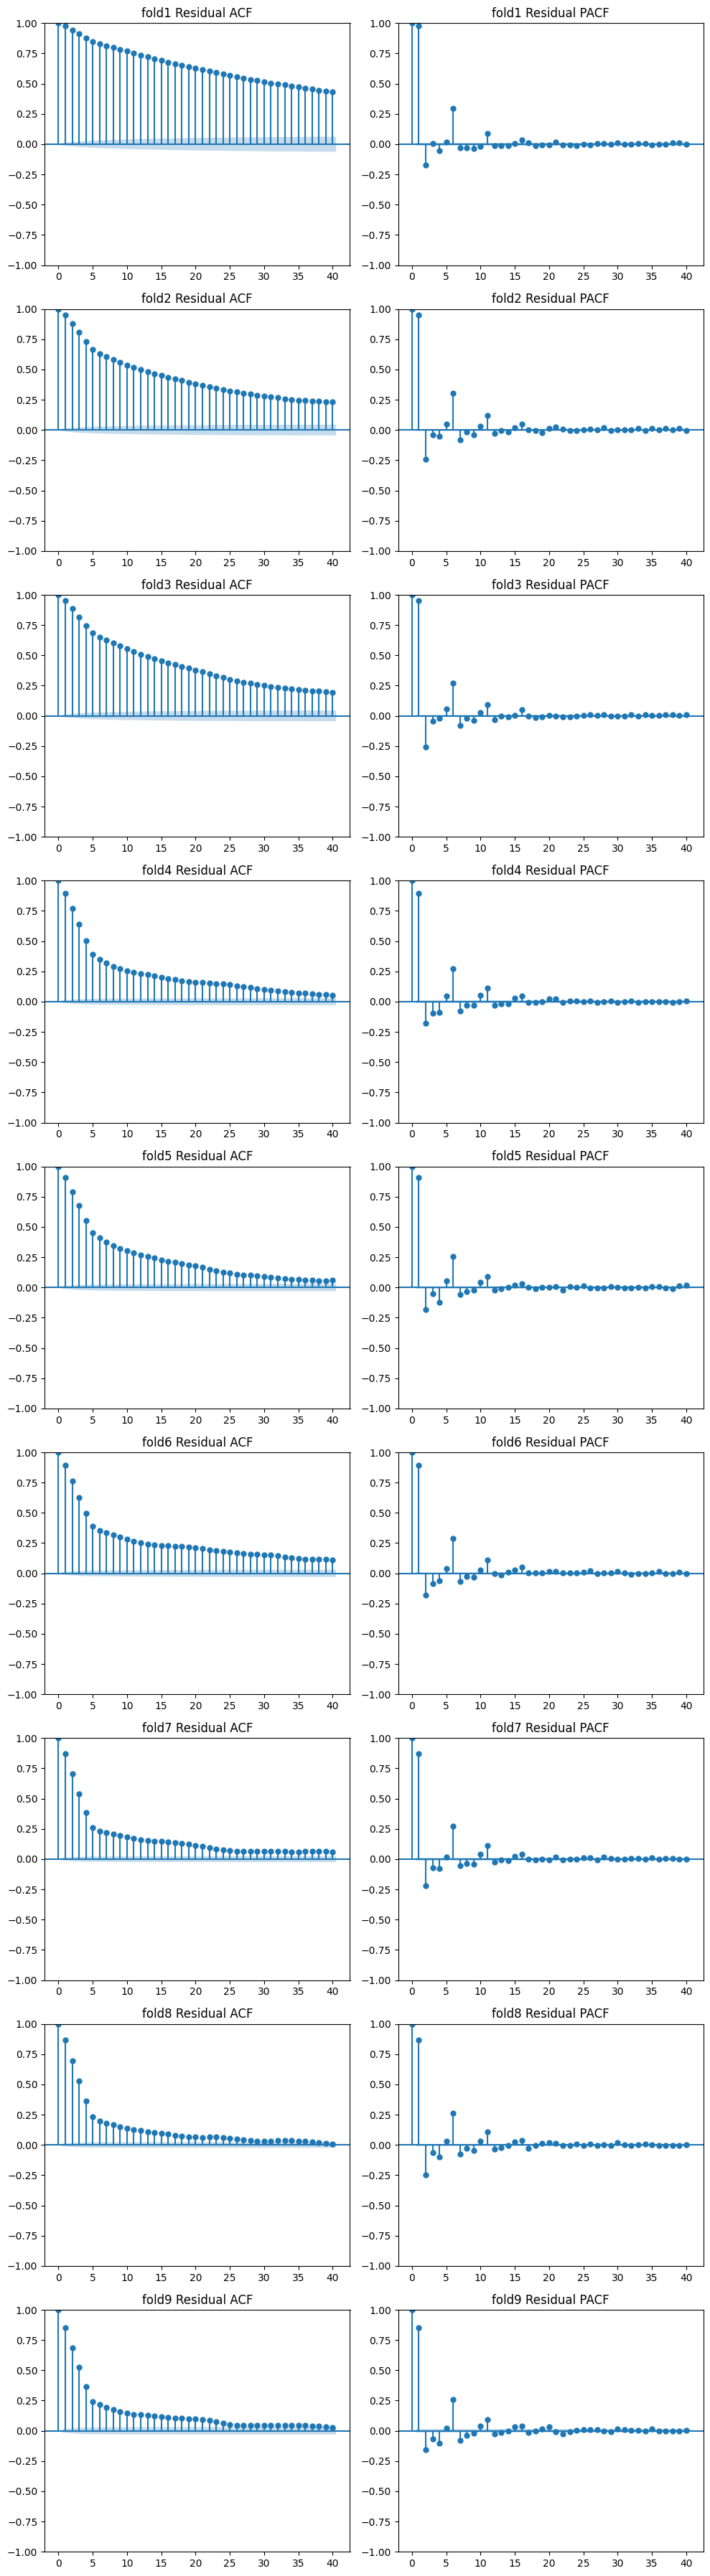

In [ ]:
# Code Cell: Compute and plot ACF/PACF of one-hour residuals per fold

import os, glob
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math

# directory where fold results are saved
results_dir = r"D:\Colab\Summer Project\Final\New Project\training"

# find each fold's results CSV (foldX_results_*.csv), pick latest
fold_patterns = sorted(glob.glob(os.path.join(results_dir, "fold*_results_*.csv")))
# group by fold prefix
fold_files = {}
for path in fold_patterns:
    fold = os.path.basename(path).split("_")[0]  # 'fold1', 'fold2', ...
    fold_files.setdefault(fold, []).append(path)

# determine number of folds
folds = sorted(fold_files.keys())
n = len(folds)

# prepare subplots: two columns (ACF, PACF), rows = number of folds
fig, axes = plt.subplots(n, 2, figsize=(10, 4*n))
if n == 1:
    axes = axes.reshape(1,2)

for i, fold in enumerate(folds):
    # pick latest file by lex sort
    latest = sorted(fold_files[fold])[-1]
    df = pd.read_csv(latest, index_col="timestamp", parse_dates=True)
    resid = df["residual"]

    ax_acf = axes[i, 0]
    ax_pacf = axes[i, 1]

    plot_acf(resid, lags=40, ax=ax_acf, title=f"{fold} Residual ACF")
    plot_pacf(resid, lags=40, ax=ax_pacf, title=f"{fold} Residual PACF")

plt.tight_layout()
plt.show()

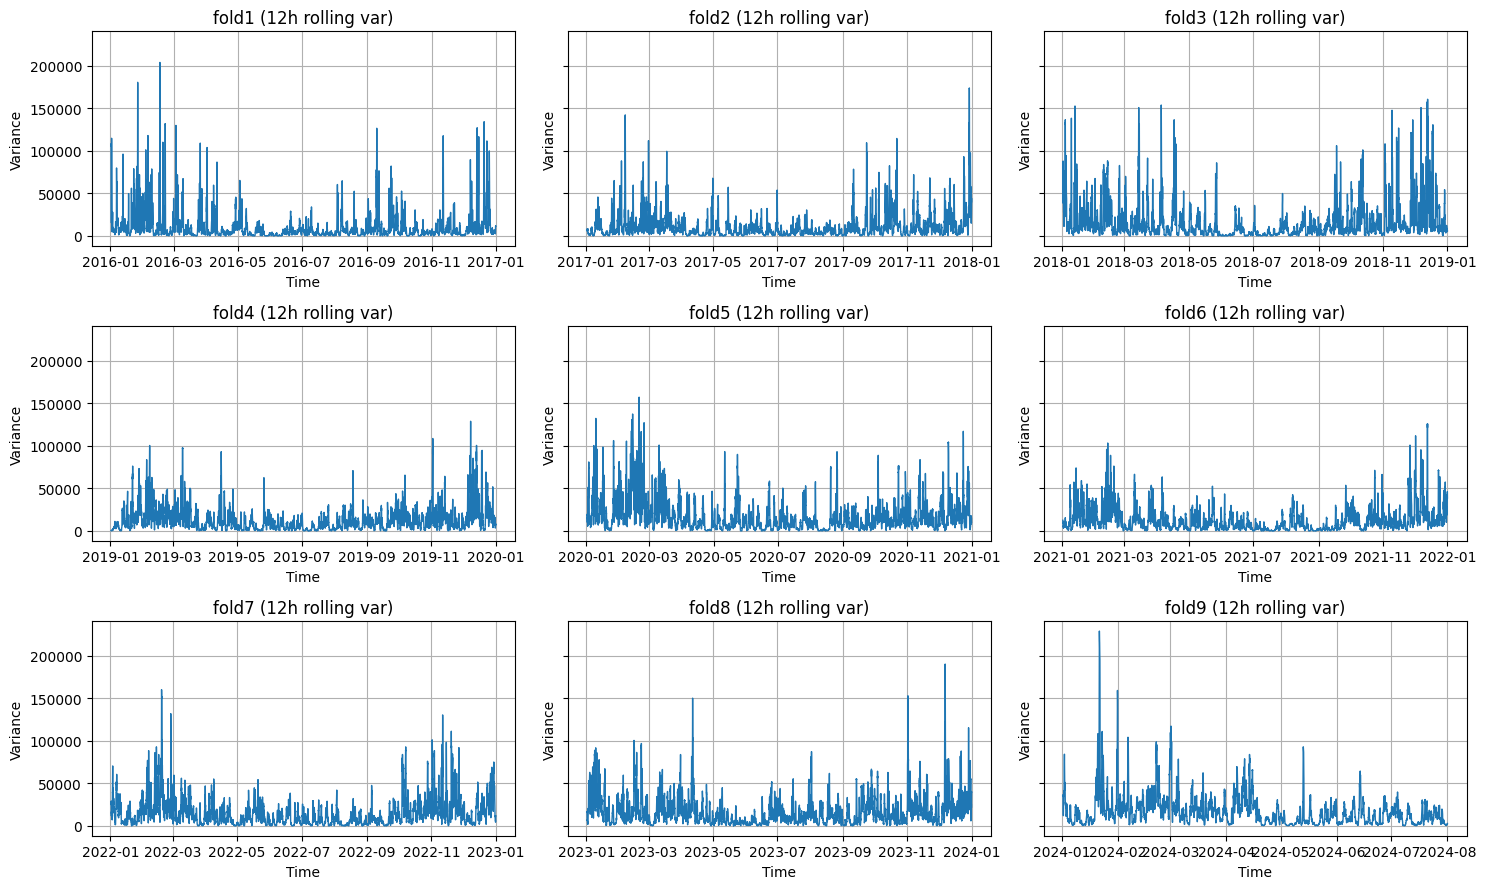

In [ ]:
# Code Cell: Plot 12-hour rolling variance of residuals for each fold

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import math

# 1. Location of results CSVs
res_root = r"D:\Colab\Summer Project\Final\New Project\training"
pattern  = os.path.join(res_root, "fold*_results_*.csv")
res_files = sorted(glob.glob(pattern))

# 2. Compute grid size
n_files = len(res_files)
cols    = 3
rows    = math.ceil(n_files / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3*rows), sharex=False, sharey=True)
axes = axes.flatten()

# 3. Rolling window in number of samples (12h at 15min → 48 points)
window_size = 12 * 4

for ax, fpath in zip(axes, res_files):
    # load residuals
    df = pd.read_csv(fpath, index_col="timestamp", parse_dates=True)
    # compute rolling variance
    roll_var = df["residual"].rolling(window=window_size).var()

    # plot
    fold_name = os.path.basename(fpath).split("_results_")[0]
    ax.plot(roll_var.index, roll_var.values, lw=1)
    ax.set_title(f"{fold_name} (12h rolling var)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Variance")
    ax.grid(True)

# hide unused subplots
for ax in axes[n_files:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

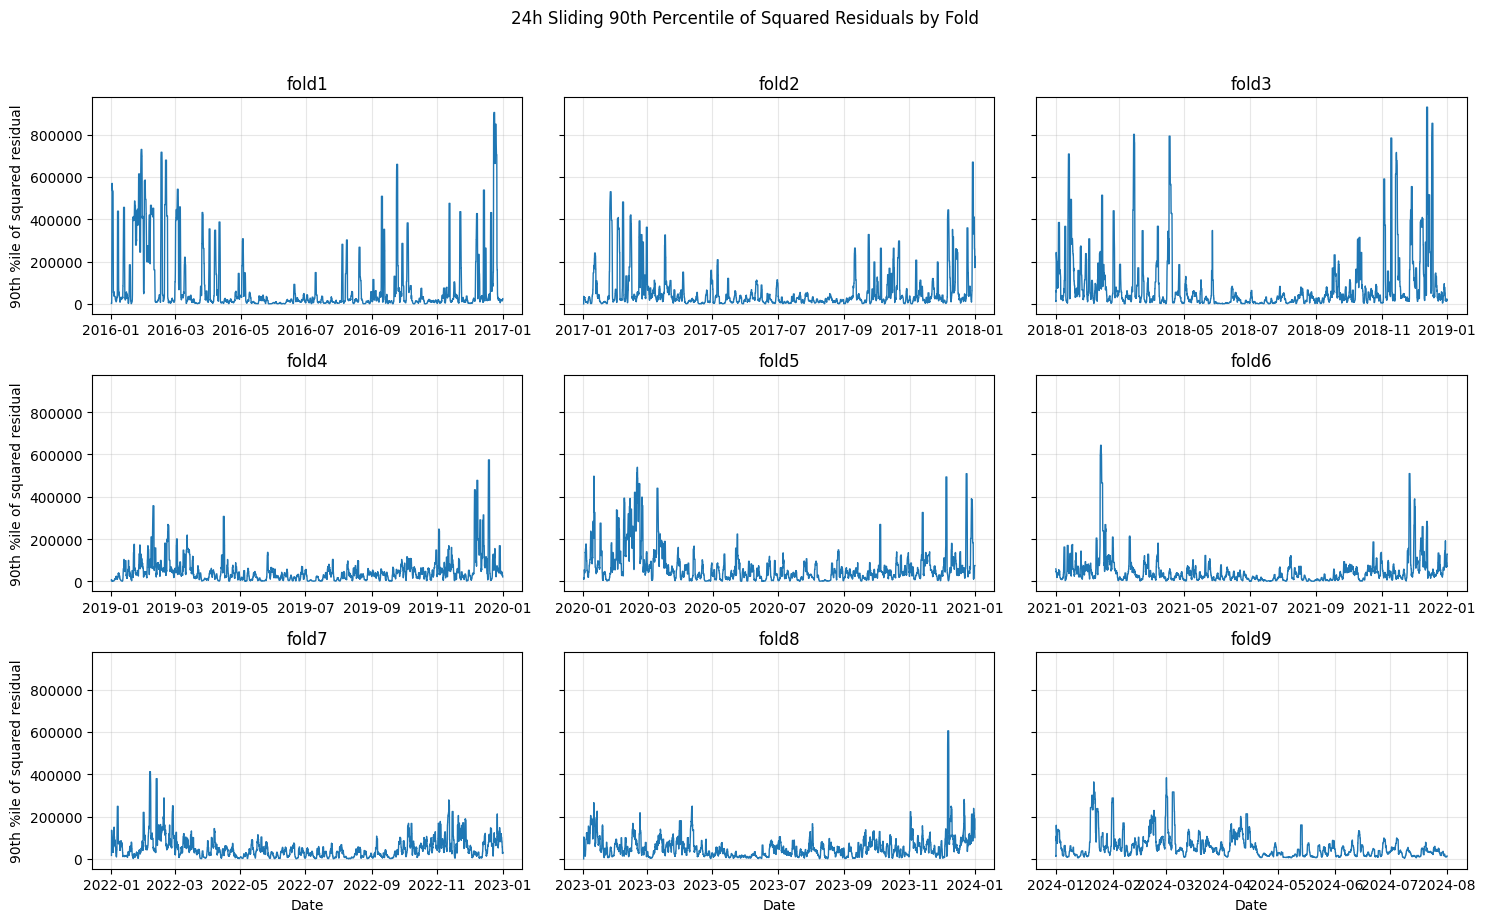

In [ ]:
# Code Cell: 24 h sliding 90th‐percentile of squared residuals by fold

import os, glob, math
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters ---
res_dir      = r"D:\Colab\Summer Project\Final\New Project\training"
freq_minutes = 15
window_hours = 24
window_size  = (60 // freq_minutes) * window_hours  # 4 × 24 = 96 points

# --- Gather each fold’s results CSV ---
pattern   = os.path.join(res_dir, "fold*_results_*.csv")
res_files = sorted(glob.glob(pattern))
n_folds   = len(res_files)

# --- Grid layout ---
cols = 3
rows = math.ceil(n_folds / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3*rows), sharey=True)
axes = axes.flatten()

for ax, res_path in zip(axes, res_files):
    fold_name = os.path.basename(res_path).split("_results_")[0]
    df_res    = pd.read_csv(res_path, index_col="timestamp", parse_dates=True)
    sqr_resid = df_res["residual"]**2

    # rolling 90th percentile
    q90 = sqr_resid.rolling(window=window_size, min_periods=1).quantile(0.9)

    ax.plot(q90.index, q90.values, lw=1)
    ax.set_title(fold_name)
    ax.grid(alpha=0.3)
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Date")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("90th %ile of squared residual")

# hide any empty subplots
for ax in axes[n_folds:]:
    ax.set_visible(False)

fig.suptitle("24h Sliding 90th Percentile of Squared Residuals by Fold", y=1.02)
plt.tight_layout()
plt.show()

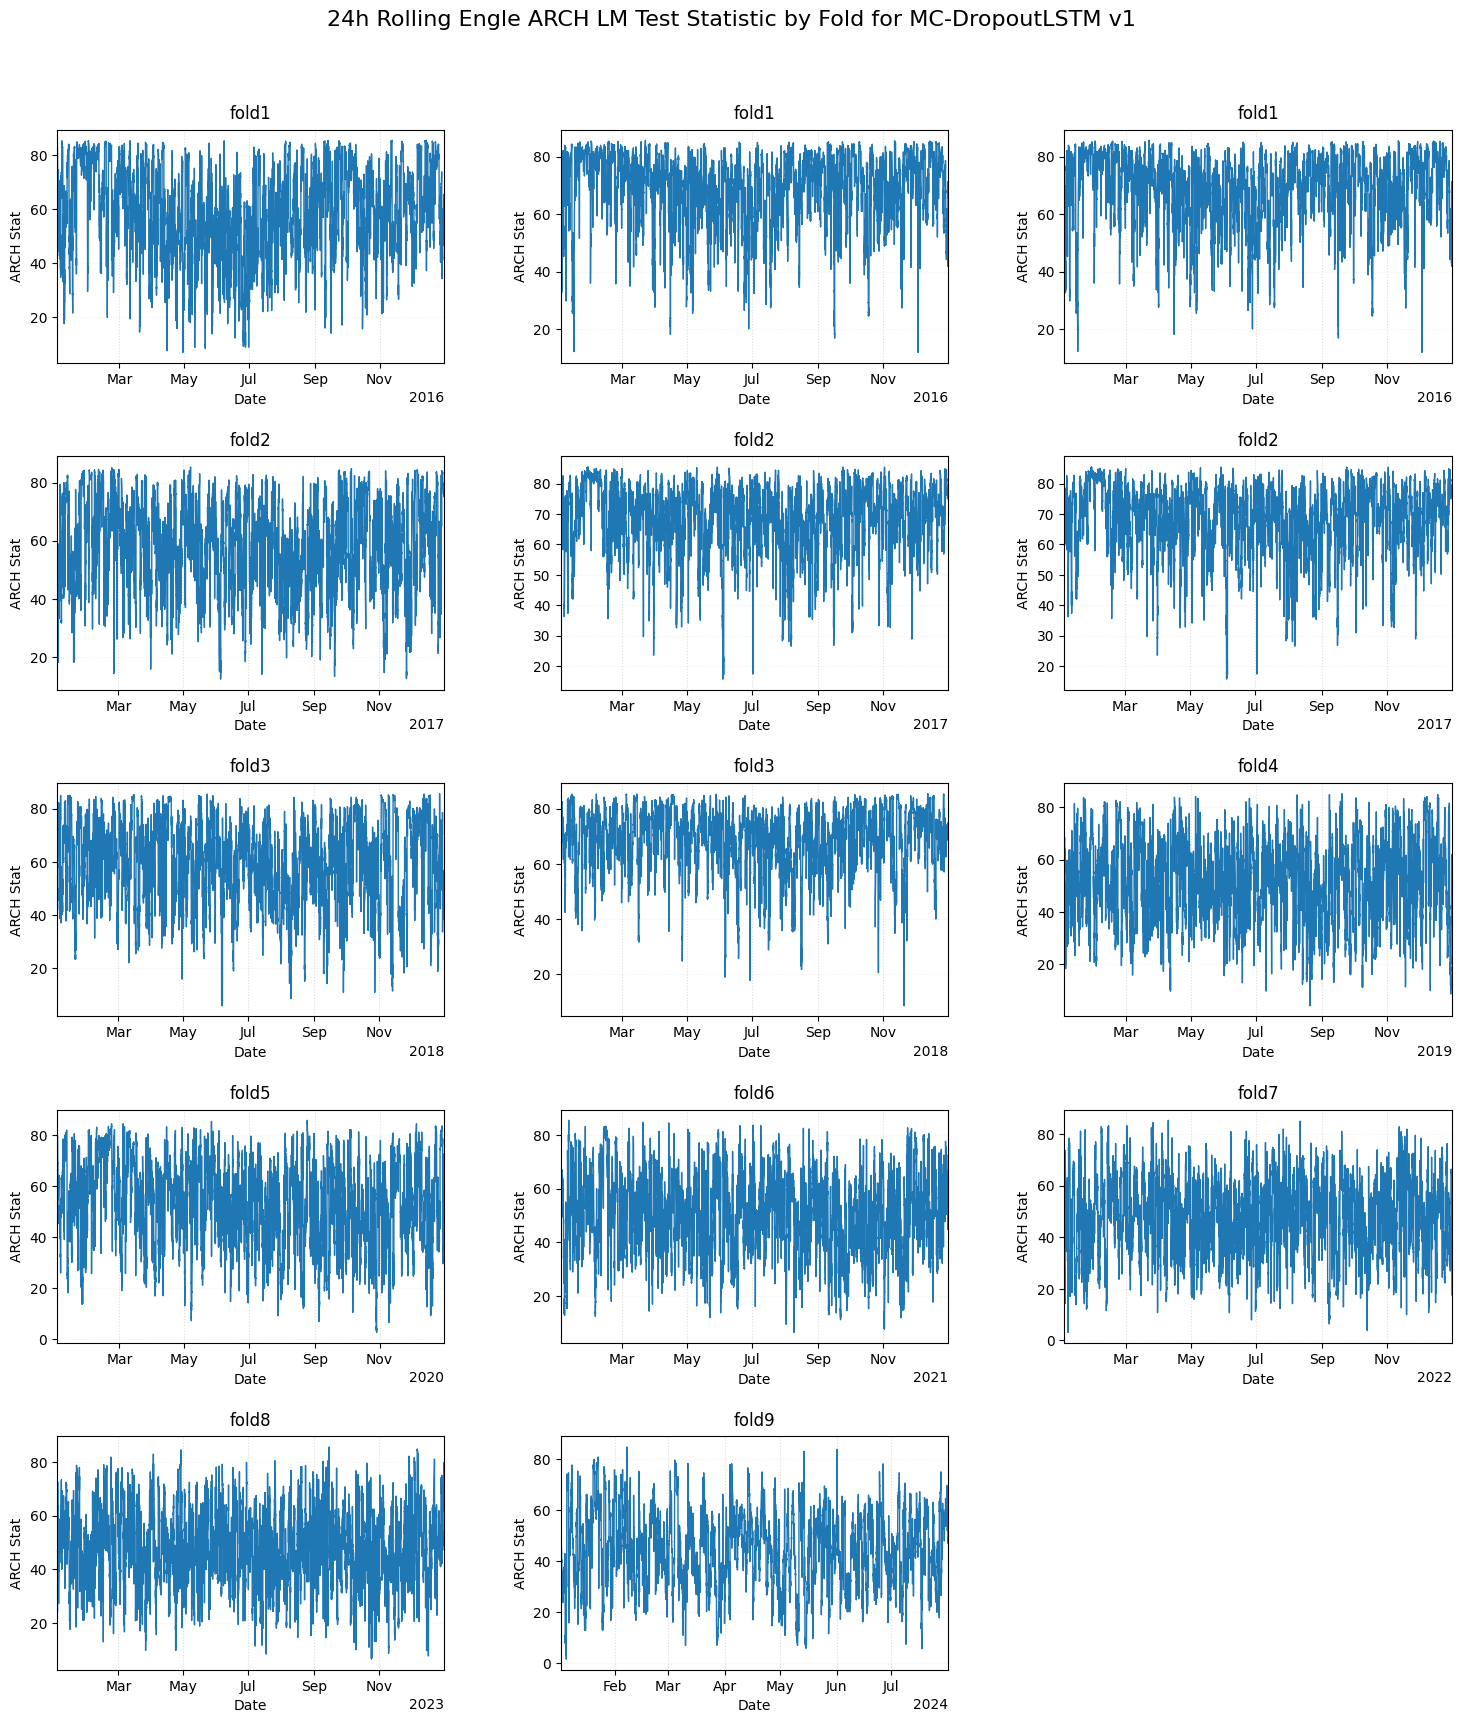

In [ ]:
# Code Cell: Rolling Engle’s ARCH test statistic with adjusted title spacing
# Axes styling/labels now match a1 (independent limits + YYYY-MM ticks on every subplot)

import os
import glob
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.stats.diagnostic import het_arch
from matplotlib.gridspec import GridSpec

# --- Parameters ---
res_dir = "/mnt/d/Colab/Summer Project/Final/New Project/training"
window_hours  = 24                # rolling window length in hours
freq_minutes  = 15                # data frequency
window_size   = window_hours * 60 // freq_minutes  # e.g. 24*60/15 = 96 points

# --- Find each fold’s results CSV ---
pattern   = os.path.join(res_dir, "fold*_results_*.csv")
res_files = sorted(glob.glob(pattern))
n_folds   = len(res_files)

# --- Set up figure with GridSpec for better spacing ---
cols = 3
rows = math.ceil(n_folds / cols)
fig = plt.figure(constrained_layout=False, figsize=(18, 4 * rows))
gs  = GridSpec(rows, cols, figure=fig, hspace=0.4, wspace=0.3)
fig.subplots_adjust(top=0.88)  # leave room for supertitle

# --- Compute and plot ---
for idx, res_path in enumerate(res_files):
    # Load residuals
    fold_name = os.path.basename(res_path).split("_results_")[0]
    df_res    = pd.read_csv(res_path, index_col="timestamp", parse_dates=True)
    resid     = df_res["residual"]

    # Rolling ARCH test
    stats = []
    times = resid.index[window_size:]
    for i in range(window_size, len(resid)):
        stat, pval, _, _ = het_arch(resid.iloc[i-window_size : i])
        stats.append(stat)
    arch_series = pd.Series(stats, index=times)

    # Select subplot
    r, c = divmod(idx, cols)
    ax = fig.add_subplot(gs[r, c])
    ax.plot(arch_series.index, arch_series.values, lw=1)
    ax.set_title(fold_name, fontsize=12, pad=8)

    # ---- Make axes look like a1 ----
    if not arch_series.empty:
        # Independent x/y limits per subplot
        ax.set_xlim(arch_series.index.min(), arch_series.index.max())
        y0, y1 = arch_series.min(), arch_series.max()
        pad = 0.05 * (y1 - y0) if y1 > y0 else 1.0
        ax.set_ylim(y0 - pad, y1 + pad)

        # Date ticks & formatter (readable YYYY-MM)
        locator = mdates.AutoDateLocator(minticks=5, maxticks=8)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

        # Light grids
        ax.grid(True, axis='x', linestyle=':', alpha=0.45)
        ax.grid(True, axis='y', linestyle=':', alpha=0.15)
    else:
        ax.text(0.5, 0.5, "No rolling data", ha='center', va='center', transform=ax.transAxes)

    # Labels on every subplot (same as a1)
    ax.set_xlabel("Date")
    ax.set_ylabel("ARCH Stat")
    ax.tick_params(axis='x', labelrotation=0)

# Hide any unused subplots
for empty in range(n_folds, rows * cols):
    r, c = divmod(empty, cols)
    fig.add_subplot(gs[r, c]).set_visible(False)

# Supertitle with adjusted vertical position
fig.suptitle(f"{window_hours}h Rolling Engle ARCH LM Test Statistic by Fold for MC-DropoutLSTM v1",
             fontsize=16, y=0.94)
plt.show()

In [ ]:
# Code Cell: Rolling Engle’s ARCH test statistic with adjusted title spacing

import os
import glob
import math
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_arch
from matplotlib.gridspec import GridSpec

# --- Parameters ---
res_dir       = r"D:\Colab\Summer Project\Final\New Project\training"
window_hours  = 24                # rolling window length in hours
freq_minutes  = 15                # data frequency
window_size   = window_hours * 60 // freq_minutes  # e.g. 24*60/15 = 96 points

# --- Find each fold’s results CSV ---
pattern   = os.path.join(res_dir, "fold*_results_*.csv")
res_files = sorted(glob.glob(pattern))
n_folds   = len(res_files)

# --- Set up figure with GridSpec for better spacing ---
cols = 3
rows = math.ceil(n_folds / cols)
fig = plt.figure(constrained_layout=False, figsize=(18, 4 * rows))
gs  = GridSpec(rows, cols, figure=fig, hspace=0.4, wspace=0.3)
fig.subplots_adjust(top=0.88)  # leave room for supertitle

# --- Compute and plot ---
for idx, res_path in enumerate(res_files):
    # Load residuals
    fold_name = os.path.basename(res_path).split("_results_")[0]
    df_res    = pd.read_csv(res_path, index_col="timestamp", parse_dates=True)
    resid     = df_res["residual"]

    # Rolling ARCH test
    stats = []
    times = resid.index[window_size:]
    for i in range(window_size, len(resid)):
        stat, pval, _, _ = het_arch(resid.iloc[i-window_size : i])
        stats.append(stat)
    arch_series = pd.Series(stats, index=times)

    # Select subplot
    r, c = divmod(idx, cols)
    ax = fig.add_subplot(gs[r, c])
    ax.plot(arch_series.index, arch_series.values, lw=1)
    ax.set_title(fold_name, fontsize=12, pad=8)
    ax.grid(alpha=0.3)

    # Only outer axes get labels
    if r == rows - 1:
        ax.set_xlabel("Date")
    if c == 0:
        ax.set_ylabel("ARCH Stat")

# Hide any unused subplots
for empty in range(n_folds, rows * cols):
    r, c = divmod(empty, cols)
    fig.add_subplot(gs[r, c]).set_visible(False)

# Supertitle with adjusted vertical position
fig.suptitle(f"{window_hours}h Rolling Engle ARCH Test Statistic by Fold for MC-DropoutLSTM v1",
             fontsize=16, y=0.94)
plt.show()

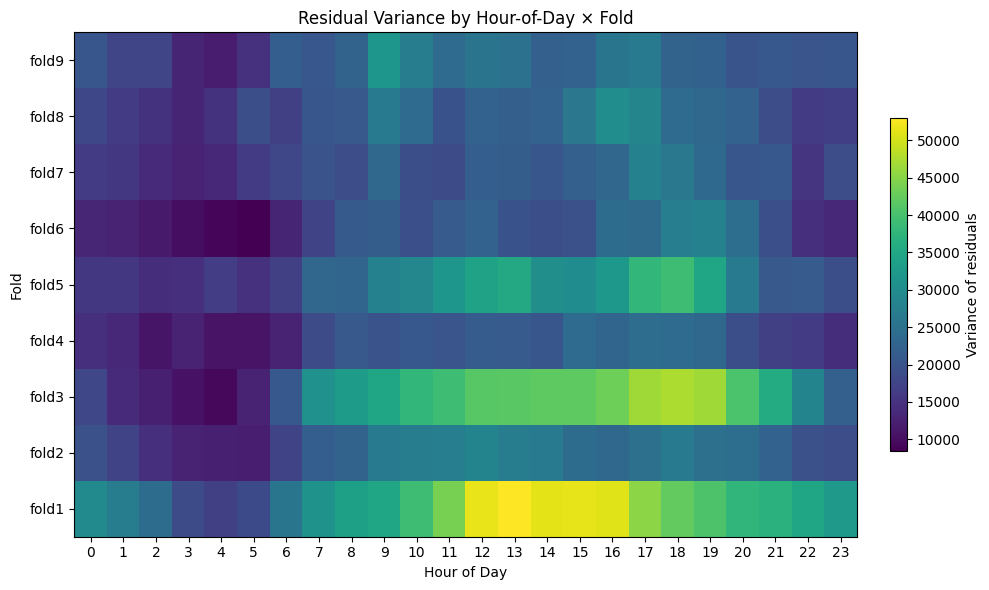

In [ ]:
# Code Cell: Heatmap of residual-variance by hour-of-day × fold

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Directory containing your per-fold results CSVs
res_dir   = r"D:\Colab\Summer Project\Final\New Project\training"
pattern   = os.path.join(res_dir, "fold*_results_*.csv")
res_files = sorted(glob.glob(pattern))

# 1. Compute residual variance for each fold by hour of day
hourly_var = {}
for res_path in res_files:
    # Derive fold label
    fold_name = os.path.basename(res_path).split("_results_")[0]
    # Load residuals
    df = pd.read_csv(res_path, parse_dates=["timestamp"], index_col="timestamp")
    df["hour"] = df.index.hour
    # Compute variance per hour (0–23)
    hourly_var[fold_name] = df.groupby("hour")["residual"].var()

# 2. Build DataFrame: rows=hour (0-23), cols=folds
df_hourly_var = pd.DataFrame(hourly_var)
df_hourly_var = df_hourly_var.reindex(range(24))  # ensure hours 0..23

# 3. Plot heatmap
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    df_hourly_var.T.values,
    aspect="auto",
    origin="lower",
    interpolation="none",
    cmap="viridis"
)

# Configure axes
ax.set_xticks(np.arange(24))
ax.set_xticklabels(df_hourly_var.index, rotation=0)
ax.set_yticks(np.arange(len(df_hourly_var.columns)))
ax.set_yticklabels(df_hourly_var.columns)
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Fold")
ax.set_title("Residual Variance by Hour-of-Day × Fold")

# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.04)
cbar.set_label("Variance of residuals")

plt.tight_layout()
plt.show()

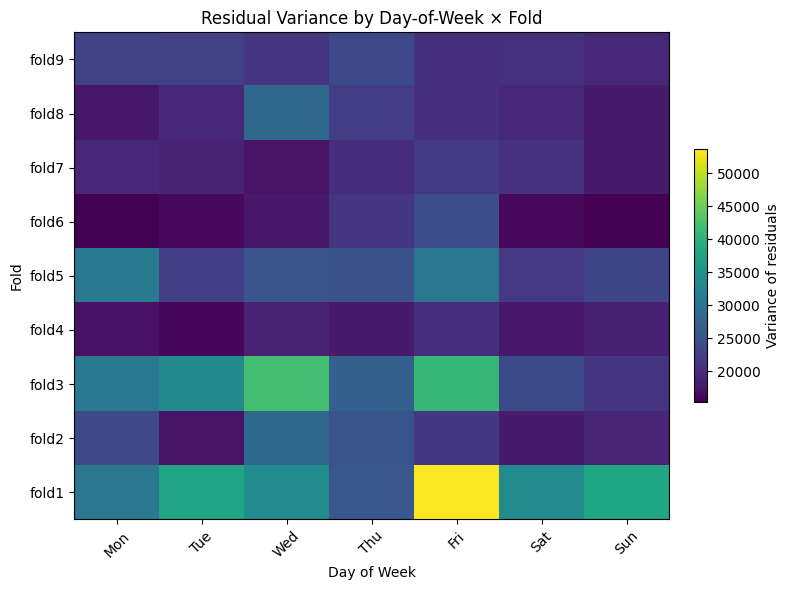

In [ ]:
# Code Cell: Heatmap of residual-variance by day-of-week × fold

import os
import glob
import calendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Directory containing your per-fold results CSVs
res_dir   = r"D:\Colab\Summer Project\Final\New Project\training"
pattern   = os.path.join(res_dir, "fold*_results_*.csv")
res_files = sorted(glob.glob(pattern))

# 1. Compute residual variance for each fold by day-of-week (0=Mon ... 6=Sun)
weekly_var = {}
for res_path in res_files:
    # Derive fold label
    fold_name = os.path.basename(res_path).split("_results_")[0]
    # Load residuals
    df = pd.read_csv(res_path, parse_dates=["timestamp"], index_col="timestamp")
    df["dow"] = df.index.dayofweek
    # Compute variance per day-of-week
    weekly_var[fold_name] = df.groupby("dow")["residual"].var()

# 2. Build DataFrame: rows=day-of-week (0-6), cols=folds
df_weekly_var = pd.DataFrame(weekly_var)
df_weekly_var = df_weekly_var.reindex(range(7))  # ensure 0..6

# 3. Plot heatmap
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    df_weekly_var.T.values,
    aspect="auto",
    origin="lower",
    interpolation="none",
    cmap="viridis"
)

# Configure axes
ax.set_xticks(np.arange(7))
ax.set_xticklabels([calendar.day_abbr[d] for d in df_weekly_var.index], rotation=45)
ax.set_yticks(np.arange(len(df_weekly_var.columns)))
ax.set_yticklabels(df_weekly_var.columns)
ax.set_xlabel("Day of Week")
ax.set_ylabel("Fold")
ax.set_title("Residual Variance by Day-of-Week × Fold")

# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.04)
cbar.set_label("Variance of residuals")

plt.tight_layout()
plt.show()

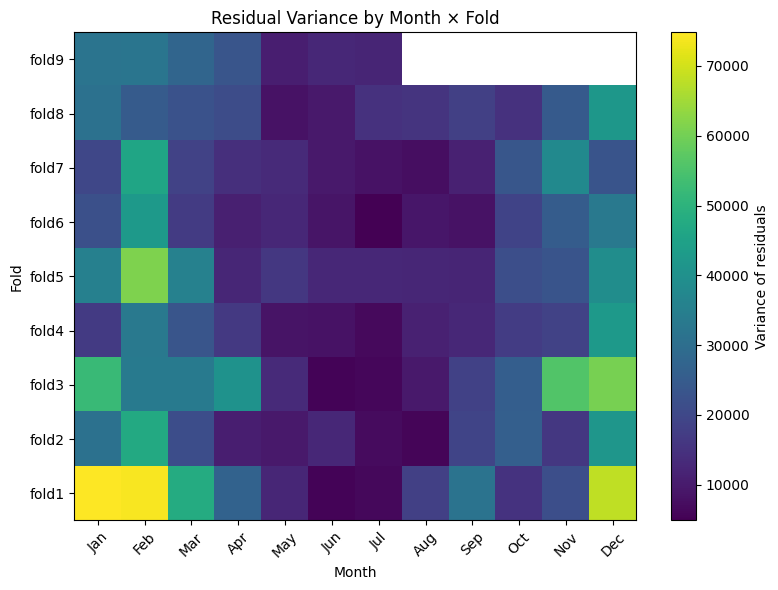

In [ ]:
# Code Cell: Heatmap of residual-variance by month × fold

import os
import glob
import calendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Directory containing your per-fold results CSVs
res_dir   = r"D:\Colab\Summer Project\Final\New Project\training"
pattern   = os.path.join(res_dir, "fold*_results_*.csv")
res_files = sorted(glob.glob(pattern))

# 1. Compute residual variance for each fold by calendar month
monthly_var = {}
for res_path in res_files:
    # Derive fold label
    fold_name = os.path.basename(res_path).split("_results_")[0]
    # Load residuals
    df = pd.read_csv(res_path, parse_dates=["timestamp"], index_col="timestamp")
    df["month"] = df.index.month
    # Compute variance per month
    monthly_var[fold_name] = df.groupby("month")["residual"].var()

# 2. Build DataFrame: rows=month (1-12), cols=folds
df_monthly_var = pd.DataFrame(monthly_var)
df_monthly_var = df_monthly_var.reindex(range(1, 13))  # ensure 1..12

# 3. Plot heatmap
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    df_monthly_var.T.values,
    aspect="auto",
    origin="lower",
    interpolation="none"
)

# Configure axes
ax.set_xticks(np.arange(12))
ax.set_xticklabels([calendar.month_abbr[m] for m in df_monthly_var.index], rotation=45)
ax.set_yticks(np.arange(len(df_monthly_var.columns)))
ax.set_yticklabels(df_monthly_var.columns)
ax.set_xlabel("Month")
ax.set_ylabel("Fold")
ax.set_title("Residual Variance by Month × Fold")

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Variance of residuals")

plt.tight_layout()
plt.show()

In [ ]:
# Code Cell: Build out feature‐engineered DataFrame without fragmentation warnings

import numpy as np
import pandas as pd

# 1. Copy base DataFrame
df_feat_eng = df_filled.copy()

# 2. Prepare all new features in a dict, then concat at once
new_feats = {}

# 2.1 Cyclical time encodings
hr  = df_feat_eng.index.hour
doy = df_feat_eng.index.dayofyear
mth = df_feat_eng.index.month - 1  # 0–11

new_feats['sin_hour']  = np.sin(2 * np.pi * hr / 24)
new_feats['cos_hour']  = np.cos(2 * np.pi * hr / 24)
new_feats['sin_doy']   = np.sin(2 * np.pi * doy / 365)
new_feats['cos_doy']   = np.cos(2 * np.pi * doy / 365)
new_feats['sin_month'] = np.sin(2 * np.pi * mth / 12)
new_feats['cos_month'] = np.cos(2 * np.pi * mth / 12)

# 2.2 Calendar flags
wd = df_feat_eng['weekday']  # 0=Mon … 6=Sun
# one‐hot weekdays
weekday_dummies = pd.get_dummies(wd, prefix='weekday', dtype=int)
for col in weekday_dummies.columns:
    new_feats[col] = weekday_dummies[col]
# weekend flag
new_feats['is_weekend'] = (wd >= 5).astype(int)

# 2.3 Volatility summary features on targets
def pct90_sq(x):
    dev = x - x.mean()
    return np.percentile(dev * dev, 90)

targets = ["IE Wind Generation", "IE Demand", "Net_load"]
windows = {
    '12h': 12 * 60 // 15,    # 48
    '24h': 24 * 60 // 15,    # 96
    '7d':  7 * 24 * 60 // 15, # 672
    '30d': 30 * 24 * 60 // 15 # 2880
}

for tgt in targets:
    # first compute 90pct rolling sq so threshold can be derived
    roll90 = (
        df_feat_eng[tgt]
        .rolling(window=windows['7d'], min_periods=1)
        .apply(pct90_sq, raw=True)
    )
    thr = roll90.quantile(0.75)
    for name, w in windows.items():
        # rolling variance
        new_feats[f'{tgt}_roll{name}_var'] = (
            df_feat_eng[tgt]
            .rolling(window=w, min_periods=1)
            .var()
        )
        # rolling 90th‐pct of squared deviations
        new_feats[f'{tgt}_roll{name}_90pct_sq'] = (
            df_feat_eng[tgt]
            .rolling(window=w, min_periods=1)
            .apply(pct90_sq, raw=True)
        )
    # high‐vol regime flag for 7d
    new_feats[f'{tgt}_highvol7d'] = (roll90 > thr).astype(int)

# 2.4 Rolling stats for meteorological & lag features
weather_cols = [
    "NW_temp","NE_temp","SW_temp","SE_temp",
    "NW_wdsp","NE_wdsp","SW_wdsp","SE_wdsp",
    "wind_lag_1","wind_lag_2","wind_lag_3","wind_lag_4",
    "wind_roll1h_mean","wind_roll1h_std"
]
h_windows = {
    '1h':   1 * 60 // 15,   # 4
    '3h':   3 * 60 // 15,   # 12
    '6h':   6 * 60 // 15,   # 24
    '12h': 12 * 60 // 15    # 48
}

for col in weather_cols:
    for name, w in h_windows.items():
        new_feats[f'{col}_roll{name}_mean'] = (
            df_feat_eng[col]
            .rolling(window=w, min_periods=1)
            .mean()
        )
        new_feats[f'{col}_roll{name}_std'] = (
            df_feat_eng[col]
            .rolling(window=w, min_periods=1)
            .std()
        )

# 3. Concatenate all new features at once
df_feat_eng = pd.concat(
    [df_feat_eng, pd.DataFrame(new_feats, index=df_feat_eng.index)],
    axis=1
)

New features NaN counts (showing >0):
IE Wind Generation_roll12h_var    1
IE Wind Generation_roll24h_var    1
IE Wind Generation_roll7d_var     1
IE Wind Generation_roll30d_var    1
IE Demand_roll12h_var             1
                                 ..
wind_roll1h_mean_roll12h_std      1
wind_roll1h_std_roll1h_std        1
wind_roll1h_std_roll3h_std        1
wind_roll1h_std_roll6h_std        1
wind_roll1h_std_roll12h_std       1
Length: 68, dtype: int64


In [ ]:
# Code Cell: List columns in df_feat_eng with NaNs and their counts

# Compute NaN counts per column
nan_counts = df_feat_eng.isna().sum()

# Filter to columns with at least one NaN
nan_counts = nan_counts[nan_counts > 0]

# Print results
if nan_counts.empty:
    print("No columns contain NaNs in df_feat_eng.")
else:
    print("Columns with NaNs in df_feat_eng:")
    for col, cnt in nan_counts.items():
        print(f"  {col}: {cnt} NaNs")

Columns with NaNs in df_feat_eng:
  IE Wind Generation_roll12h_var: 1 NaNs
  IE Wind Generation_roll24h_var: 1 NaNs
  IE Wind Generation_roll7d_var: 1 NaNs
  IE Wind Generation_roll30d_var: 1 NaNs
  IE Demand_roll12h_var: 1 NaNs
  IE Demand_roll24h_var: 1 NaNs
  IE Demand_roll7d_var: 1 NaNs
  IE Demand_roll30d_var: 1 NaNs
  Net_load_roll12h_var: 1 NaNs
  Net_load_roll24h_var: 1 NaNs
  Net_load_roll7d_var: 1 NaNs
  Net_load_roll30d_var: 1 NaNs
  NW_temp_roll1h_std: 1 NaNs
  NW_temp_roll3h_std: 1 NaNs
  NW_temp_roll6h_std: 1 NaNs
  NW_temp_roll12h_std: 1 NaNs
  NE_temp_roll1h_std: 1 NaNs
  NE_temp_roll3h_std: 1 NaNs
  NE_temp_roll6h_std: 1 NaNs
  NE_temp_roll12h_std: 1 NaNs
  SW_temp_roll1h_std: 1 NaNs
  SW_temp_roll3h_std: 1 NaNs
  SW_temp_roll6h_std: 1 NaNs
  SW_temp_roll12h_std: 1 NaNs
  SE_temp_roll1h_std: 1 NaNs
  SE_temp_roll3h_std: 1 NaNs
  SE_temp_roll6h_std: 1 NaNs
  SE_temp_roll12h_std: 1 NaNs
  NW_wdsp_roll1h_std: 1 NaNs
  NW_wdsp_roll3h_std: 1 NaNs
  NW_wdsp_roll6h_std: 1 NaN

In [ ]:
# Code Cell: Backfill columns with NaNs in df_feat_eng

# 1. Identify columns that contain any NaNs
nan_cols = df_feat_eng.columns[df_feat_eng.isna().any()].tolist()
print(f"Columns with NaNs before backfill: {nan_cols}")

# 2. Apply backward-fill to those columns
df_feat_eng[nan_cols] = df_feat_eng[nan_cols].bfill()

# 3. If any NaNs remain at the very start, forward-fill as well
df_feat_eng[nan_cols] = df_feat_eng[nan_cols].ffill()

# 4. Verify that there are no more NaNs in these columns
print("Remaining NaNs after fill:")
print(df_feat_eng[nan_cols].isna().sum())

Columns with NaNs before backfill: ['IE Wind Generation_roll12h_var', 'IE Wind Generation_roll24h_var', 'IE Wind Generation_roll7d_var', 'IE Wind Generation_roll30d_var', 'IE Demand_roll12h_var', 'IE Demand_roll24h_var', 'IE Demand_roll7d_var', 'IE Demand_roll30d_var', 'Net_load_roll12h_var', 'Net_load_roll24h_var', 'Net_load_roll7d_var', 'Net_load_roll30d_var', 'NW_temp_roll1h_std', 'NW_temp_roll3h_std', 'NW_temp_roll6h_std', 'NW_temp_roll12h_std', 'NE_temp_roll1h_std', 'NE_temp_roll3h_std', 'NE_temp_roll6h_std', 'NE_temp_roll12h_std', 'SW_temp_roll1h_std', 'SW_temp_roll3h_std', 'SW_temp_roll6h_std', 'SW_temp_roll12h_std', 'SE_temp_roll1h_std', 'SE_temp_roll3h_std', 'SE_temp_roll6h_std', 'SE_temp_roll12h_std', 'NW_wdsp_roll1h_std', 'NW_wdsp_roll3h_std', 'NW_wdsp_roll6h_std', 'NW_wdsp_roll12h_std', 'NE_wdsp_roll1h_std', 'NE_wdsp_roll3h_std', 'NE_wdsp_roll6h_std', 'NE_wdsp_roll12h_std', 'SW_wdsp_roll1h_std', 'SW_wdsp_roll3h_std', 'SW_wdsp_roll6h_std', 'SW_wdsp_roll12h_std', 'SE_wdsp_rol

In [ ]:
# Code Cell: Downcast df_feat_eng dtypes for memory savings

import numpy as np

# Identify float64 and int64 columns
float64_cols = df_feat_eng.select_dtypes(include=["float64"]).columns
int64_cols   = df_feat_eng.select_dtypes(include=["int64"]).columns

# Downcast float64 → float32
df_feat_eng[float64_cols] = df_feat_eng[float64_cols].astype(np.float32)

# Downcast int64 → int8
df_feat_eng[int64_cols] = df_feat_eng[int64_cols].astype(np.int8)

# Verify
print("After downcasting:")
print(df_feat_eng.dtypes.value_counts())

In [ ]:
# Code Cell: Downcast df_feat_eng dtypes for memory savings and export to HDF5 v1 (WSL2 hdf5 folder)

import numpy as np
import os
import h5py
from datetime import datetime

# 1. Downcast numeric dtypes
float64_cols = df_feat_eng.select_dtypes(include=["float64"]).columns
int64_cols   = df_feat_eng.select_dtypes(include=["int64"]).columns

df_feat_eng[float64_cols] = df_feat_eng[float64_cols].astype(np.float32)
df_feat_eng[int64_cols]   = df_feat_eng[int64_cols].astype(np.int8)

# 2. Verify
print("After downcasting:")
print(df_feat_eng.dtypes.value_counts())

# 3. Prepare HDF5 file path with semantic version and timestamp in WSL2
version    = "v1"
timestamp  = datetime.now().strftime("%Y%m%d_%H%M%S")
# WSL2 mount of Windows user Downloads:
h5_dir     = "/mnt/d/Users/m1029/Downloads/summer_project/hdf5"
# Only create if it doesn't already exist
if not os.path.isdir(h5_dir):
    os.makedirs(h5_dir, exist_ok=True)
h5_path    = os.path.join(h5_dir, f"df_feat_eng_{version}_{timestamp}.h5")

# 4. Parameters for HDF5 chunking
seq_len = 96
n_feats = df_feat_eng.shape[1]

# 5. Write to HDF5 with chunk per window
with h5py.File(h5_path, "w") as f:
    # main data array
    f.create_dataset(
        "data",
        data=df_feat_eng.to_numpy(dtype=np.float32),
        chunks=(seq_len, n_feats),
        compression=None
    )
    # save index as int64 ns since epoch
    idx_int = df_feat_eng.index.view(np.int64)
    f.create_dataset("index_ns", data=idx_int, dtype="int64")
    # save column names with proper string dtype
    str_dt = h5py.string_dtype(encoding="utf-8")
    f.create_dataset("columns", data=np.array(df_feat_eng.columns, dtype=object), dtype=str_dt)

print(f"HDF5 store written to {h5_path}")
print(f"Dataset 'data' shape: {df_feat_eng.shape}, dtype: float32")

After downcasting:
float32    177
int8        11
Name: count, dtype: int64
HDF5 store written to /mnt/d/Users/m1029/Downloads/summer_project/hdf5/df_feat_eng_v1_20250720_065516.h5
Dataset 'data' shape: (397149, 188), dtype: float32


In [ ]:
# Code Cell: Generate walk‐forward CV splits on df_feat_eng with extended look-back

import pandas as pd
from pandas.tseries.offsets import DateOffset

# 1. Define parameters
df_start    = pd.Timestamp("2014-01-01 00:00:00")
test_start  = pd.Timestamp("2024-08-01 00:00:00")
val_horizon = DateOffset(years=1)
step        = pd.Timedelta(minutes=15)
horizon     = 4 * step   # one-hour ahead
seq_len     = 96         # extend to 1 day (96 × 15-min steps); try 288, 672, etc.

# 2. Build CV fold boundaries
folds = []
train_start = df_start
train_end   = train_start + DateOffset(years=2) - step  # initial 2-yr train

while True:
    val_start     = train_end + step
    tentative_end = val_start + val_horizon - step
    val_end       = min(tentative_end, test_start - step)
    folds.append({
        "train_start": train_start,
        "train_end":   train_end,
        "val_start":   val_start,
        "val_end":     val_end
    })
    if val_end >= test_start - step:
        break
    train_end = val_end  # expand training window

# 3. Convert to index lists, filtering out indices too close to edges
splits = []
min_ts = df_feat_eng.index.min()
max_ts = df_feat_eng.index.max()

for f in folds:
    idx_train = df_feat_eng.loc[f["train_start"]:f["train_end"]].index
    idx_val   = df_feat_eng.loc[f["val_start"]:  f["val_end"]].index

    train_idx = [
        idx for idx in idx_train
        if (idx - seq_len*step) >= min_ts and (idx + horizon) <= max_ts
    ]
    val_idx = [
        idx for idx in idx_val
        if (idx - seq_len*step) >= min_ts and (idx + horizon) <= max_ts
    ]
    splits.append((pd.DatetimeIndex(train_idx), pd.DatetimeIndex(val_idx)))

# 4. Final test index
test_idx = df_feat_eng.loc[test_start:].index

# 5. Report
print(f"Generated {len(splits)} folds.")
for i, (tr, vl) in enumerate(splits, 1):
    print(f" Fold {i}: train={len(tr)} samples, val={len(vl)} samples")
print(f"Test period → {test_start.date()} to {max_ts.date()}, samples: {len(test_idx)}")

Generated 9 folds.
 Fold 1: train=69980 samples, val=35136 samples
 Fold 2: train=105116 samples, val=35040 samples
 Fold 3: train=140156 samples, val=35040 samples
 Fold 4: train=175196 samples, val=35040 samples
 Fold 5: train=210236 samples, val=35136 samples
 Fold 6: train=245372 samples, val=35040 samples
 Fold 7: train=280412 samples, val=35040 samples
 Fold 8: train=315452 samples, val=35040 samples
 Fold 9: train=350492 samples, val=20448 samples
Test period → 2024-08-01 to 2025-04-30, samples: 26113


In [ ]:
# Code Cell: Define an HDF5-backed windowed Dataset (auto-select latest v1 file in WSL2)
import os
import re
import glob
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset
from datetime import datetime

# 1. Locate the latest v1 HDF5 store in your WSL2 folder
h5_dir = "/mnt/d/Users/m1029/Downloads/summer_project/hdf5"
pattern = os.path.join(h5_dir, "df_feat_eng_v1_*.h5")
files = glob.glob(pattern)
if not files:
    raise FileNotFoundError(f"No files matching {pattern}")
def _ts_from_fname(path):
    fn = os.path.basename(path)
    m = re.match(r"df_feat_eng_v1_(\d{8}_\d{6})\.h5", fn)
    return datetime.strptime(m.group(1), "%Y%m%d_%H%M%S") if m else datetime.min
latest_h5 = max(files, key=_ts_from_fname)
print(f"Using HDF5 store: {latest_h5}")

# 2. Define the Dataset (lazy-open per worker)
class HDF5WindowDataset(Dataset):
    def __init__(self,
                 h5_path: str,
                 indices: np.ndarray,
                 seq_len: int,
                 horizon_steps: int,
                 target_col_name: str):
        """
        h5_path: path to the .h5 store
        indices: integer row-positions to use as window ends
        seq_len: number of time steps in each input window
        horizon_steps: how many steps ahead for the target
        target_col_name: name of the column to use as target
        """
        self.h5_path = h5_path
        self.indices = np.array(indices, dtype=np.int64)
        self.seq_len = seq_len
        self.horizon = horizon_steps

        # one‐time open to fetch column names → find target column index
        with h5py.File(h5_path, "r") as f:
            cols_bytes = f["columns"][...]
            cols = [c.decode("utf-8") for c in cols_bytes]
            self.target_col = cols.index(target_col_name)

        # placeholders for per‐worker file handle
        self._file = None
        self._data = None

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # lazy open in worker
        if self._file is None:
            self._file = h5py.File(self.h5_path, "r")
            self._data = self._file["data"]

        pos = int(self.indices[idx])
        start = pos - self.seq_len
        end = pos

        # slice X and y
        X = self._data[start:end, :]
        y = self._data[pos + self.horizon, self.target_col]

        return (
            torch.from_numpy(np.asarray(X, dtype=np.float32)),
            torch.tensor(float(y), dtype=torch.float32)
        )

Using HDF5 store: /mnt/d/Users/m1029/Downloads/summer_project/hdf5/df_feat_eng_v1_20250720_065516.h5


In [ ]:
# Code Cell: Train MCDropoutLSTM on each walk‐forward fold using HDF5WindowDataset
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, SequentialSampler, BatchSampler
from pytorch_lightning.loggers import CSVLogger
from sklearn.metrics import mean_squared_error
from datetime import datetime

# 1. Hyperparameters (match your splits cell)
seq_len    = 96               # 1-day lookback (96 × 15-min steps)
batch_size = 64
n_epochs   = 20
horizon    = 4                # 4 steps → 1h ahead
out_dir    = r"D:\Colab\Summer Project\Final\New Project\training"
os.makedirs(out_dir, exist_ok=True)

# 2. Path to the latest HDF5 store (from your Dataset cell)
h5_path = latest_h5

# 3. Loop over folds (using splits of timestamp indices)
for fold_i, (train_ts, val_ts) in enumerate(splits, start=1):
    # Convert timestamp indices to integer positions in the HDF5 dataset
    train_pos = df_feat_eng.index.get_indexer(train_ts)
    val_pos   = df_feat_eng.index.get_indexer(val_ts)

    # 4. Build HDF5-backed Datasets
    train_ds = HDF5WindowDataset(
        h5_path=h5_path,
        indices=train_pos,
        seq_len=seq_len,
        horizon_steps=horizon,
        target_col_name="IE Wind Generation"
    )
    val_ds = HDF5WindowDataset(
        h5_path=h5_path,
        indices=val_pos,
        seq_len=seq_len,
        horizon_steps=horizon,
        target_col_name="IE Wind Generation"
    )

    # 5. DataLoaders: semi-sequential + persistent workers + prefetch
    base_sampler  = SequentialSampler(train_ds)
    batch_sampler = BatchSampler(base_sampler, batch_size=batch_size, drop_last=False)
    batch_list    = list(batch_sampler)
    np.random.shuffle(batch_list)

    train_loader = DataLoader(
        train_ds,
        batch_sampler=batch_list,
        num_workers=14,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=4
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=14,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=4
    )

    # 6. Logger setup
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    logger = CSVLogger(
        save_dir=out_dir,
        name=f"fold{fold_i}_log_{timestamp}"
    )

    # 7. Model & Trainer (Lightning moves model & batches to GPU)
    input_size = df_feat_eng.shape[1]
    model = MCDropoutLSTM(input_size=input_size)
    trainer = pl.Trainer(
        max_epochs=n_epochs,
        logger=logger,
        enable_checkpointing=False,
        enable_progress_bar=False,
        devices=1,
        accelerator="gpu"
    )

    # 8. Fit
    trainer.fit(model, train_loader, val_loader)

    # 9. Inference on validation set
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(model.device, non_blocking=True)
            preds = model(Xb).cpu().numpy()
            all_preds.append(preds)
            all_trues.append(yb.numpy())
    all_preds = np.concatenate(all_preds)
    all_trues = np.concatenate(all_trues)
    rmse = np.sqrt(mean_squared_error(all_trues, all_preds))

    # 10. Save results, aligning index to the exact windows used
    #     Map each prediction back to its window-ending position
    pred_positions   = val_pos                      # one‐to‐one with all_preds/all_trues
    pred_timestamps  = df_feat_eng.index[pred_positions]

    results_df = pd.DataFrame({
        "y_true":   all_trues,
        "y_pred":   all_preds,
        "residual": all_trues - all_preds
    }, index=pred_timestamps)

    results_df.to_csv(
        os.path.join(out_dir, f"fold{fold_i}_results_{timestamp}.csv"),
        index_label="timestamp"
    )

    print(f"Fold {fold_i} done. RMSE: {rmse:.3f}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 98.3 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
98.4 K    Trainable params
0         Non-trainable params
98.4 K    Total params
0.393     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 98.3 K | train
1 | dropout  

Fold 1 done. RMSE: 539.961


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 98.3 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
98.4 K    Trainable params
0         Non-trainable params
98.4 K    Total params
0.393     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Fold 2 done. RMSE: 626.486


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 98.3 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
98.4 K    Trainable params
0         Non-trainable params
98.4 K    Total params
0.393     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Fold 3 done. RMSE: 805.581


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 98.3 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
98.4 K    Trainable params
0         Non-trainable params
98.4 K    Total params
0.393     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Fold 4 done. RMSE: 836.724


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 98.3 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
98.4 K    Trainable params
0         Non-trainable params
98.4 K    Total params
0.393     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Fold 5 done. RMSE: 965.302


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 98.3 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
98.4 K    Trainable params
0         Non-trainable params
98.4 K    Total params
0.393     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Fold 6 done. RMSE: 883.630


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 98.3 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
98.4 K    Trainable params
0         Non-trainable params
98.4 K    Total params
0.393     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Fold 7 done. RMSE: 986.252


`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 98.3 K | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 65     | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
98.4 K    Trainable params
0         Non-trainable params
98.4 K    Total params
0.393     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Fold 8 done. RMSE: 988.496


`Trainer.fit` stopped: `max_epochs=20` reached.


Fold 9 done. RMSE: 944.368


In [ ]:
# Code Cell: Generate custom 3-fold CV splits on df_feat_eng (no seq_len filtering)

import pandas as pd
from pandas import Timestamp

# 1. Define parameters
df_start       = Timestamp("2014-01-01 00:00:00")
step           = pd.Timedelta(minutes=15)
horizon_steps  = 4     # one-hour ahead = 4 × 15-min steps
data_length    = len(df_feat_eng)

# 2. Define custom fold boundaries
fold_defs = [
    {
        "train_start": Timestamp("2014-01-01"),
        "train_end":   Timestamp("2017-12-31"),
        "val_start":   Timestamp("2018-01-01"),
        "val_end":     Timestamp("2018-12-31"),
    },
    {
        "train_start": Timestamp("2014-01-01"),
        "train_end":   Timestamp("2018-12-31"),
        "val_start":   Timestamp("2019-01-01"),
        "val_end":     Timestamp("2019-12-31"),
    },
    {
        "train_start": Timestamp("2014-01-01"),
        "train_end":   Timestamp("2019-12-31"),
        "val_start":   Timestamp("2020-01-01"),
        "val_end":     Timestamp("2020-12-31"),
    },
]

# 3. Build splits (timestamp → integer positions) without seq_len filtering
splits = []
for fd in fold_defs:
    idx_train = df_feat_eng.loc[fd["train_start"]:fd["train_end"]].index
    idx_val   = df_feat_eng.loc[fd["val_start"]:fd["val_end"]].index

    train_pos = df_feat_eng.index.get_indexer(idx_train)
    val_pos   = df_feat_eng.index.get_indexer(idx_val)

    splits.append((train_pos, val_pos))

# 4. Final test index (everything from 2021‑01‑01 onward)
test_idx = df_feat_eng.loc["2021-01-01":].index

# 5. Report fold sizes (by timestamp-count)
print(f"Generated {len(splits)} folds.")
for i, (tr_pos, vl_pos) in enumerate(splits, 1):
    print(f" Fold {i}: train={len(tr_pos)} samples, val={len(vl_pos)} samples")
print(f"Test period → 2021-01-01 to {df_feat_eng.index.max().date()}, samples: {len(test_idx)}")

Generated 3 folds.
 Fold 1: train=140157 samples, val=34945 samples
 Fold 2: train=175197 samples, val=34945 samples
 Fold 3: train=210237 samples, val=35041 samples
Test period → 2021-01-01 to 2025-04-30, samples: 151681


In [ ]:
# Code Cell: Grid search over seq_len × num_layers only

import os
import numpy as np
import torch
from torch.utils.data import DataLoader, SequentialSampler, BatchSampler
from torch.utils.data._utils.collate import default_collate
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning as pl
from sklearn.metrics import mean_squared_error
from datetime import datetime

# Make sure your HDF5WindowDataset class is in scope
# (either defined above or imported)
# from your_module import HDF5WindowDataset

out_dir    = r"D:\Colab\Summer Project\Final\New Project\training"
os.makedirs(out_dir, exist_ok=True)

# fixed defaults
BATCH_SIZE   = 256
LR           = 1e-4
DROPOUT_RATE = 0.3
MAX_EPOCHS   = 15
HORIZON      = horizon_steps  # from your globals
SPLITS       = splits         # your precomputed walk‑forward splits
H5_PATH      = latest_h5      # your HDF5 store path
TARGET_COL   = "IE Wind Generation"

# 1) collate_fn
def pad_collate(batch):
    Xs, ys = zip(*batch)
    max_t   = max(x.shape[0] for x in Xs)
    n_feats = Xs[0].shape[1]
    padded = []
    for x in Xs:
        if x.shape[0] < max_t:
            pad = torch.zeros((max_t - x.shape[0], n_feats),
                              dtype=x.dtype, device=x.device)
            padded.append(torch.cat([x, pad], dim=0))
        else:
            padded.append(x)
    return torch.stack(padded, dim=0), default_collate(ys)

# 2) Loop over grid
results = []
for seq_len in [48, 96, 288]:      # 12h, 24h, 72h
    for num_layers in [1, 2, 3, 4]:
        fold_rmses = []
        for fold_i, (train_ts, val_ts) in enumerate(SPLITS, start=1):
            # positions → datasets
            train_pos = df_feat_eng.index.get_indexer(train_ts)
            val_pos   = df_feat_eng.index.get_indexer(val_ts)

            # Use the HDF5WindowDataset you defined above
            train_ds = HDF5WindowDataset(
                h5_path=H5_PATH,
                indices=train_pos,
                seq_len=seq_len,
                horizon_steps=HORIZON,
                target_col_name=TARGET_COL
            )
            val_ds   = HDF5WindowDataset(
                h5_path=H5_PATH,
                indices=val_pos,
                seq_len=seq_len,
                horizon_steps=HORIZON,
                target_col_name=TARGET_COL
            )

            # dataloaders
            batch_list = list(BatchSampler(
                SequentialSampler(train_ds),
                batch_size=BATCH_SIZE,
                drop_last=False
            ))
            np.random.shuffle(batch_list)
            train_loader = DataLoader(
                train_ds,
                batch_sampler=batch_list,
                num_workers=0,
                pin_memory=False,
                persistent_workers=False,
                prefetch_factor=None,
                collate_fn=pad_collate
            )
            val_loader = DataLoader(
                val_ds,
                batch_size=BATCH_SIZE,
                shuffle=False,
                num_workers=0,
                pin_memory=False,
                persistent_workers=False,
                prefetch_factor=None,
                collate_fn=pad_collate
            )

            # model & trainer
            input_size = df_feat_eng.shape[1]
            model = MCDropoutLSTM(
                input_size=input_size,
                hidden_size=32,
                num_layers=num_layers,
                dropout=DROPOUT_RATE,
                lr=LR
            )
            trainer = pl.Trainer(
                max_epochs=MAX_EPOCHS,
                logger=CSVLogger(
                    save_dir=out_dir,
                    name=f"grid_seq{seq_len}_layers{num_layers}_fold{fold_i}"
                ),
                callbacks=[EarlyStopping(monitor="val_loss_epoch", patience=5)],
                enable_checkpointing=False,
                enable_progress_bar=False,
                accelerator="gpu",
                devices=1,
                precision="16-mixed"
            )

            # fit & eval
            trainer.fit(model, train_loader, val_loader)
            model.eval()
            preds, trues = [], []
            with torch.no_grad():
                for Xb, yb in val_loader:
                    p = model(Xb.to(model.device, non_blocking=True)).cpu().numpy()
                    preds.append(p)
                    trues.append(yb.numpy())
            rmse = np.sqrt(mean_squared_error(
                np.concatenate(trues),
                np.concatenate(preds)
            ))
            fold_rmses.append(rmse)

        # record mean over folds
        results.append({
            "seq_len": seq_len,
            "num_layers": num_layers,
            "rmse_mean": np.mean(fold_rmses),
            "rmse_std":  np.std(fold_rmses)
        })

/home/najo1o11/najo1/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 28.4 K | train
1 | dropout   | Dropout | 0      | train
2 | fc    

In [ ]:
# 3) Convert to DataFrame & save
import pandas as pd
df_grid = pd.DataFrame(results)

In [ ]:
print(
    df_grid.pivot(index="seq_len",
        columns="num_layers",values="rmse_mean"
    )
)

num_layers           1           2           3           4
seq_len                                                   
48          922.816517  922.876244  922.924766  922.849692
96          922.793762  922.899185  922.882199  922.761226
288         923.164817  922.967042  923.020470  922.841071


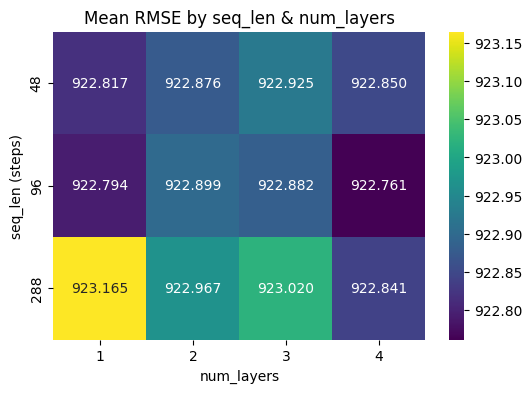

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = df_grid.pivot(index="seq_len", columns="num_layers", values="rmse_mean")
plt.figure(figsize=(6, 4))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Mean RMSE by seq_len & num_layers")
plt.xlabel("num_layers")
plt.ylabel("seq_len (steps)")
plt.show()

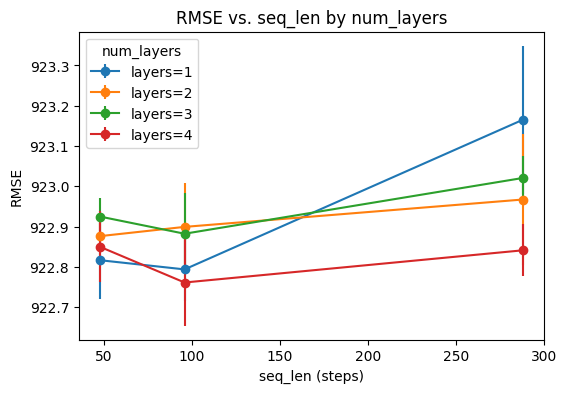

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
for nl in sorted(df_grid.num_layers.unique()):
    sub = df_grid[df_grid.num_layers == nl]
    plt.errorbar(
        sub.seq_len,
        sub.rmse_mean,
        yerr=sub.rmse_std,
        marker="o",
        label=f"layers={nl}"
    )
plt.title("RMSE vs. seq_len by num_layers")
plt.xlabel("seq_len (steps)")
plt.ylabel("RMSE")
plt.legend(title="num_layers")
plt.show()

In [ ]:
# Code Cell: Generate walk‐forward CV splits on df_feat_eng with extended look-back

import pandas as pd
from pandas.tseries.offsets import DateOffset

# 1. Define parameters
df_start      = pd.Timestamp("2014-01-01 00:00:00")
test_start    = pd.Timestamp("2024-08-01 00:00:00")
val_horizon   = DateOffset(years=1)
step          = pd.Timedelta(minutes=15)
horizon       = 4 * step     # one‑hour ahead (Timedelta)
horizon_steps = int(horizon / step)  # → 4 (integer steps for dataset)
seq_len       = 96           # 1‑day look‑back (96 × 15‑min steps)

# 2. Build CV fold boundaries
folds = []
train_start = df_start
train_end   = train_start + DateOffset(years=2) - step  # initial 2‑yr train

while True:
    val_start     = train_end + step
    tentative_end = val_start + val_horizon - step
    val_end       = min(tentative_end, test_start - step)
    folds.append({
        "train_start": train_start,
        "train_end":   train_end,
        "val_start":   val_start,
        "val_end":     val_end
    })
    if val_end >= test_start - step:
        break
    train_end = val_end  # expand training window

# 3. Convert to index lists, filtering out indices too close to edges
splits = []
min_ts = df_feat_eng.index.min()
max_ts = df_feat_eng.index.max()

for f in folds:
    idx_train = df_feat_eng.loc[f["train_start"]:f["train_end"]].index
    idx_val   = df_feat_eng.loc[f["val_start"]:  f["val_end"]].index

    train_idx = [
        idx for idx in idx_train
        if (idx - seq_len*step) >= min_ts and (idx + horizon) <= max_ts
    ]
    val_idx = [
        idx for idx in idx_val
        if (idx - seq_len*step) >= min_ts and (idx + horizon) <= max_ts
    ]
    splits.append((pd.DatetimeIndex(train_idx), pd.DatetimeIndex(val_idx)))

# 4. Final test indices → then convert to integer positions
test_idx = df_feat_eng.loc[test_start:].index
test_pos = df_feat_eng.index.get_indexer(test_idx)

# 5. Report
print(f"Generated {len(splits)} folds (using horizon_steps={horizon_steps}).")
for i, (tr, vl) in enumerate(splits, 1):
    print(f" Fold {i}: train={len(tr)} samples, val={len(vl)} samples")
print(f"Test period → {test_start.date()} to {max_ts.date()}, timestamp samples: {len(test_idx)}, integer positions: {len(test_pos)}")

Generated 9 folds (using horizon_steps=4).
 Fold 1: train=69980 samples, val=35136 samples
 Fold 2: train=105116 samples, val=35040 samples
 Fold 3: train=140156 samples, val=35040 samples
 Fold 4: train=175196 samples, val=35040 samples
 Fold 5: train=210236 samples, val=35136 samples
 Fold 6: train=245372 samples, val=35040 samples
 Fold 7: train=280412 samples, val=35040 samples
 Fold 8: train=315452 samples, val=35040 samples
 Fold 9: train=350492 samples, val=20448 samples
Test period → 2024-08-01 to 2025-04-30, timestamp samples: 26113, integer positions: 26113


In [ ]:
# Code Cell: Optuna search over key hyperparameters (fixed seq_len=96, num_layers∈{3,4})
import os
import numpy as np
import torch
import optuna
import traceback

from torch.utils.data import DataLoader, SequentialSampler, BatchSampler
from torch.utils.data._utils.collate import default_collate

import lightning.pytorch as pl
from lightning.pytorch import LightningModule
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger

from sklearn.metrics import mean_squared_error
from datetime import datetime

# ---- 1) LightningModule subclass ----
class MCDropoutLSTM(LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, dropout, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lstm    = torch.nn.LSTM(input_size, hidden_size,
                                     num_layers=num_layers,
                                     dropout=dropout,
                                     batch_first=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.fc      = torch.nn.Linear(hidden_size, 1)
        self.lr      = lr

    def forward(self, x):
        out, _ = self.lstm(x)
        h      = out[:, -1, :]
        h      = self.dropout(h)
        return self.fc(h).squeeze(-1)

    def training_step(self, batch, batch_idx):
        x, y   = batch
        y_hat  = self(x)
        loss   = torch.nn.functional.mse_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y    = batch
        y_hat   = self(x)
        loss    = torch.nn.functional.mse_loss(y_hat, y)
        self.log("val_loss_epoch", loss, prog_bar=True)
        return {"preds": y_hat.detach().cpu(), "truth": y.detach().cpu()}

    def on_validation_epoch_end(self, outputs):
        preds = torch.cat([o["preds"] for o in outputs]).numpy()
        truth = torch.cat([o["truth"] for o in outputs]).numpy()
        rmse  = np.sqrt(mean_squared_error(truth, preds))
        self.log("val_rmse", rmse, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr,
                                weight_decay=self.hparams.get("weight_decay", 0.0))


# ---- 2) Optuna + DataLoader boilerplate unchanged ----
OUT_DIR = r"D:\Colab\Summer Project\Final\New Project\training\optuna_no_prune_debug"
os.makedirs(OUT_DIR, exist_ok=True)

HORIZON    = horizon_steps    # global
SPLITS_TS  = splits           # timestamp splits
H5_PATH    = latest_h5
TARGET_COL = "IE Wind Generation"
SEQ_LEN    = 96

def pad_collate(batch):
    Xs, ys = zip(*batch)
    max_t   = max(x.shape[0] for x in Xs)
    n_feats = Xs[0].shape[1]
    padded  = []
    for x in Xs:
        if x.shape[0] < max_t:
            pad = torch.zeros((max_t - x.shape[0], n_feats),
                              dtype=x.dtype, device=x.device)
            padded.append(torch.cat([x, pad], dim=0))
        else:
            padded.append(x)
    return torch.stack(padded, dim=0), default_collate(ys)

def objective(trial):
    try:
        num_layers   = trial.suggest_categorical("num_layers", [3, 4])
        hidden_size  = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
        dropout_rate = trial.suggest_categorical("dropout_rate", [0.01, 0.1, 0.3, 0.5])
        weight_decay = trial.suggest_categorical("weight_decay", [1e-5, 1e-4, 1e-3])
        lr           = trial.suggest_categorical("learning_rate", [3e-4, 1e-4, 3e-5])
        lr_schedule  = trial.suggest_categorical("lr_scheduler", ["none", "step", "cosine"])
        max_epochs   = 50

        fold_losses = []
        for fold_i, (train_ts, val_ts) in enumerate(SPLITS_TS, start=1):
            train_pos = df_feat_eng.index.get_indexer(train_ts)
            val_pos   = df_feat_eng.index.get_indexer(val_ts)

            train_ds = HDF5WindowDataset(H5_PATH, train_pos, SEQ_LEN, HORIZON, TARGET_COL)
            val_ds   = HDF5WindowDataset(H5_PATH, val_pos,   SEQ_LEN, HORIZON, TARGET_COL)

            batch_list   = list(BatchSampler(SequentialSampler(train_ds), batch_size=256, drop_last=False))
            np.random.shuffle(batch_list)
            train_loader = DataLoader(train_ds, batch_sampler=batch_list,
                                      collate_fn=pad_collate, num_workers=0)
            val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False,
                                      collate_fn=pad_collate, num_workers=0)

            model = MCDropoutLSTM(input_size=df_feat_eng.shape[1],
                                  hidden_size=hidden_size,
                                  num_layers=num_layers,
                                  dropout=dropout_rate,
                                  lr=lr)
            model.hparams.weight_decay = weight_decay

            if lr_schedule == "step":
                model.lr_scheduler, model.lr_scheduler_params = (
                    torch.optim.lr_scheduler.StepLR, {"step_size": 10, "gamma": 0.1}
                )
            elif lr_schedule == "cosine":
                model.lr_scheduler, model.lr_scheduler_params = (
                    torch.optim.lr_scheduler.CosineAnnealingLR, {"T_max": max_epochs}
                )

            trainer = pl.Trainer(
                max_epochs=max_epochs,
                logger=CSVLogger(save_dir=OUT_DIR,
                                 name=f"opt{trial.number}_num{num_layers}_hid{hidden_size}_fold{fold_i}"),
                callbacks=[EarlyStopping(monitor="val_loss_epoch", patience=5),
                           LearningRateMonitor(logging_interval="epoch")],
                enable_checkpointing=False,
                enable_progress_bar=False,
                accelerator="gpu",
                devices=1,
                precision=32,  # full 32-bit precision
            )

            trainer.fit(model, train_loader, val_loader)
            fold_losses.append(trainer.callback_metrics["val_loss_epoch"].item())

        return float(np.mean(fold_losses))

    except Exception:
        print(f"\n--- Traceback for trial {trial.number} ---")
        traceback.print_exc()
        raise

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10)
print("Best trial:", study.best_trial.params)

In [ ]:
import os
import pickle
import joblib
import pandas as pd

# point to the same directory you saved into
SAVE_DIR = r"D:\Colab\Summer Project\Final\New Project\study\optuna 28th072025"

# 1) Load the study from pickle
pkl_path = os.path.join(SAVE_DIR, "optuna_study.pkl")
with open(pkl_path, "rb") as f:
    study_from_pkl = pickle.load(f)

# 2) (Alternatively) Load the study via joblib
joblib_path = os.path.join(SAVE_DIR, "optuna_study.joblib")
study_from_joblib = joblib.load(joblib_path)

# 3) Load the trials DataFrame
csv_path = os.path.join(SAVE_DIR, "optuna_trials.csv")
df_trials = pd.read_csv(csv_path)

In [ ]:
# Save the trained state_dict to your Windows D: drive via WSL mount
save_dir = "/mnt/d/Colab/Summer Project/Final/New Project/study/optuna"
os.makedirs(save_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
out_path = os.path.join(save_dir, f"mc_dropout_lstm_best_{timestamp}.pt")
torch.save(model.state_dict(), out_path)

print(f"✅ Best model weights saved to {out_path}")

✅ Best model weights saved to /mnt/d/Colab/Summer Project/Final/New Project/study/optuna/mc_dropout_lstm_best_20250802_085658.pt


In [ ]:
print("Best params (joblib):", study_from_joblib.best_params)

Best params (joblib): {'num_layers': 4, 'hidden_size': 256, 'dropout_rate': 0.01, 'weight_decay': 0.001, 'learning_rate': 0.0003, 'lr_scheduler': 'none'}


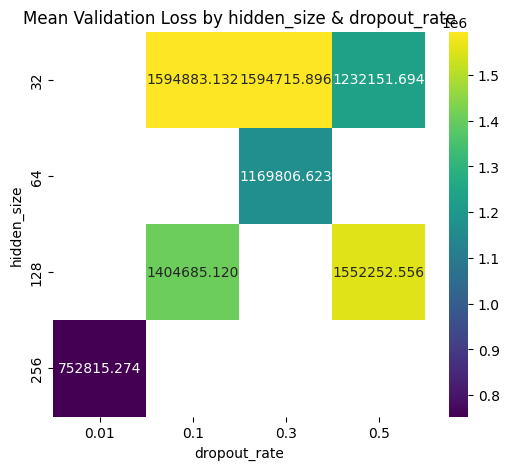

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# build a pivot table using the actual df_trials column names
pivot = df_trials.pivot_table(
    index="params_hidden_size",
    columns="params_dropout_rate",
    values="value",
    aggfunc="mean"
)

plt.figure(figsize=(6, 5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.xlabel("dropout_rate")
plt.ylabel("hidden_size")
plt.title("Mean Validation Loss by hidden_size & dropout_rate")
plt.show()

In [ ]:
# instead of using test_idx directly:
test_pos = df_feat_eng.index.get_indexer(test_idx)  # gives the 0-based row numbers

In [ ]:
test_pos

array([371036, 371037, 371038, ..., 397146, 397147, 397148],
      shape=(26113,))

In [ ]:
# Code Cell: Reconstruct, train on full data, and save best MC‑Dropout LSTM

import os
from datetime import datetime
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, SequentialSampler, BatchSampler
from torch.utils.data._utils.collate import default_collate


# 1) Best hyperparameters from your Optuna study
best_params = {
    "num_layers":    4,
    "hidden_size":   256,
    "dropout":       0.01,
    "lr":            3e-4,
    "weight_decay":  1e-3,
    "lr_scheduler":  "none"
}

# 2) Prepare full train+val positions (assuming `splits` still in memory)
import numpy as np
train_pos_list = [df_feat_eng.index.get_indexer(tr) for tr, _ in splits]
val_pos_list   = [df_feat_eng.index.get_indexer(vl) for _, vl in splits]
all_train_pos  = np.unique(np.concatenate(train_pos_list + val_pos_list))

# 3) Build HDF5 dataset & loader for full training
dataset = HDF5WindowDataset(
    h5_path=latest_h5,
    indices=all_train_pos,
    seq_len=SEQ_LEN,
    horizon_steps=HORIZON,
    target_col_name="IE Wind Generation"
)
batch_list = list(BatchSampler(SequentialSampler(dataset), batch_size=256, drop_last=False))
train_loader = DataLoader(
    dataset,
    batch_sampler=batch_list,
    collate_fn=pad_collate,
    num_workers=4,
    pin_memory=True
)

# 4) Instantiate the model
model = MCDropoutLSTM(
    input_size=df_feat_eng.shape[1],
    hidden_size=best_params["hidden_size"],
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout"],
    lr=best_params["lr"]
)
model.hparams.weight_decay = best_params["weight_decay"]
# (no lr_scheduler since best_params["lr_scheduler"] == "none")

# 5) Train on full data
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    enable_checkpointing=False,
    enable_progress_bar=False
)
trainer.fit(model, train_loader)

# 6) Save the trained weights to your Windows D: drive (via WSL mount)
save_dir = "/mnt/d/Colab/Summer Project/Final/New Project/study/optuna"
os.makedirs(save_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
out_path = os.path.join(save_dir, f"mc_dropout_lstm_best_{timestamp}.pt")
torch.save(model.state_dict(), out_path)

print(f"Model weights saved to {out_path}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 2.0 M  | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 257    | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.144     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=50` reached.


Model weights saved to /mnt/d/Colab/Summer Project/Final/New Project/study/optuna/mc_dropout_lstm_best_20250730_192603.pt


In [ ]:
# Code Cell: Persistence CV Evaluation
import numpy as np
from sklearn.metrics import mean_squared_error

# Collect per‐fold RMSEs
pers_rmses = []

for fold_i, (_, val_idx) in enumerate(splits, start=1):
    # True values on the validation timestamps
    y_true = df_feat_eng.loc[val_idx, "IE Wind Generation"]
    # Persistence forecast: shift the series by horizon_steps
    y_pred = df_feat_eng["IE Wind Generation"].shift(horizon_steps).loc[val_idx]

    # Compute RMSE for this fold
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    pers_rmses.append(rmse)
    print(f"Fold {fold_i} Persistence RMSE: {rmse:.3f}")

# Compute CV metrics
pers_cv_rmse_mean = np.mean(pers_rmses)
pers_cv_rmse_std  = np.std(pers_rmses)
print(f"\nPersistence CV RMSE: {pers_cv_rmse_mean:.3f} ± {pers_cv_rmse_std:.3f}")

Fold 1 Persistence RMSE: 83.412
Fold 2 Persistence RMSE: 98.816
Fold 3 Persistence RMSE: 114.098
Fold 4 Persistence RMSE: 119.372
Fold 5 Persistence RMSE: 135.802
Fold 6 Persistence RMSE: 120.002
Fold 7 Persistence RMSE: 136.255
Fold 8 Persistence RMSE: 143.040
Fold 9 Persistence RMSE: 141.577

Persistence CV RMSE: 121.375 ± 19.195


In [ ]:
# Code Cell: Persistence Test‑Set Evaluation
import numpy as np
from sklearn.metrics import mean_squared_error

# True values on the held‑out test timestamps
y_test_true = df_feat_eng.loc[test_idx, "IE Wind Generation"]

# Persistence forecast on test set: shift by horizon_steps
y_test_pred = df_feat_eng["IE Wind Generation"].shift(horizon_steps).loc[test_idx]

# Compute Persistence Test RMSE
pers_test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
pers_test_cov80 = np.nan  # no uncertainty bands for persistence
pers_test_cov95 = np.nan

print(f"Persistence Test RMSE: {pers_test_rmse:.3f}")

Persistence Test RMSE: 143.335


In [ ]:
# Code Cell: ARIMA‑GARCH CV Evaluation (explicit 15‑min frequency, fixed deprecations)
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from scipy.stats import norm

# Precompute quantiles
z80, z95 = norm.ppf(0.90), norm.ppf(0.975)

# Lists to collect per‐fold metrics
arima_cv_rmses   = []
arima_cv_cov80   = []
arima_cv_cov95   = []

for fold_i, ((train_idx, val_idx), fold_bounds) in enumerate(zip(splits, folds), start=1):
    # 1) Build continuous train + val series with 15-minute frequency
    train_start, train_end = fold_bounds["train_start"], fold_bounds["train_end"]
    val_start,   val_end   = fold_bounds["val_start"],   fold_bounds["val_end"]

    y_train = df_feat_eng["IE Wind Generation"].loc[train_start:train_end].asfreq("15min")
    y_val   = df_feat_eng["IE Wind Generation"].loc[val_start:val_end]  .asfreq("15min")
    y_train.index.freq = "15min"
    y_val.index.freq   = "15min"

    # 2) Fit ARIMA(2,1,2) on training data
    arima_res = ARIMA(y_train, order=(2,1,2)).fit()

    # 3) One‑step‑ahead ARIMA mean forecasts over validation span
    pred    = arima_res.get_prediction(start=y_val.index[0], end=y_val.index[-1])
    mu_full = pd.Series(pred.predicted_mean, index=y_val.index)

    # 4) Fit GARCH(1,1) on ARIMA residuals from training period
    resid_train = arima_res.resid.dropna()
    garch_res   = arch_model(resid_train, vol="Garch", p=1, q=1).fit(disp="off")

    # 5) Roll GARCH variance forecasts into the validation period
    var_forecasts = []
    history       = resid_train.copy()
    for ts in y_val.index:
        var_h = garch_res.forecast(horizon=1, reindex=False).variance.iloc[-1, 0]
        var_forecasts.append(var_h)
        new_res = df_feat_eng.at[ts, "IE Wind Generation"] - mu_full.at[ts]
        history.loc[ts] = new_res
    sigma_full = np.sqrt(var_forecasts)

    # Restrict to the exact timestamps in val_idx
    mu     = mu_full.loc[val_idx]
    sigma  = sigma_full[np.isin(y_val.index, val_idx)]
    y_true = df_feat_eng.loc[val_idx, "IE Wind Generation"]

    # 6) Compute per‑fold RMSE
    rmse = np.sqrt(mean_squared_error(y_true, mu))
    arima_cv_rmses.append(rmse)

    # 7) Compute per‑fold coverage rates
    errors = y_true - mu
    cov80  = np.mean(np.abs(errors) <= z80 * sigma)
    cov95  = np.mean(np.abs(errors) <= z95 * sigma)
    arima_cv_cov80.append(cov80)
    arima_cv_cov95.append(cov95)

    print(f"Fold {fold_i} ARIMA‑GARCH: RMSE={rmse:.3f}, Cov80={cov80:.3f}, Cov95={cov95:.3f}")

# Compute CV metrics
arima_cv_rmse_mean = np.mean(arima_cv_rmses)
arima_cv_rmse_std  = np.std(arima_cv_rmses)
arima_cv_cov80     = np.mean(arima_cv_cov80)
arima_cv_cov95     = np.mean(arima_cv_cov95)

print(f"\nARIMA‑GARCH CV RMSE: {arima_cv_rmse_mean:.3f} ± {arima_cv_rmse_std:.3f}")
print(f"ARIMA‑GARCH CV Coverage: 80% → {arima_cv_cov80:.3f}, 95% → {arima_cv_cov95:.3f}")

Fold 1 ARIMA‑GARCH: RMSE=559.428, Cov80=0.058, Cov95=0.088


/home/najo1o11/najo1/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fold 2 ARIMA‑GARCH: RMSE=708.711, Cov80=0.042, Cov95=0.065


/home/najo1o11/najo1/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




Fold 3 ARIMA‑GARCH: RMSE=1317.424, Cov80=0.049, Cov95=0.073


/home/najo1o11/najo1/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




Fold 4 ARIMA‑GARCH: RMSE=849.637, Cov80=0.019, Cov95=0.029
Fold 5 ARIMA‑GARCH: RMSE=1222.730, Cov80=0.020, Cov95=0.031
Fold 6 ARIMA‑GARCH: RMSE=1385.170, Cov80=0.014, Cov95=0.021


/home/najo1o11/najo1/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




Fold 7 ARIMA‑GARCH: RMSE=1774.816, Cov80=0.025, Cov95=0.039


/home/najo1o11/najo1/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




Fold 8 ARIMA‑GARCH: RMSE=1208.094, Cov80=0.059, Cov95=0.087
Fold 9 ARIMA‑GARCH: RMSE=1364.669, Cov80=0.020, Cov95=0.030

ARIMA‑GARCH CV RMSE: 1154.520 ± 359.324
ARIMA‑GARCH CV Coverage: 80% → 0.034, 95% → 0.052


In [ ]:
# Code Cell: ARIMA‑GARCH Test‑Set Evaluation
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from scipy.stats import norm

# Precompute quantiles
z80, z95 = norm.ppf(0.90), norm.ppf(0.975)

# 1) Build pre‑test and test series at 15‑min freq
step       = pd.Timedelta(minutes=15)
test_start = pd.Timestamp("2024-08-01 00:00:00")

y_pre = (
    df_feat_eng["IE Wind Generation"]
    .loc[: test_start - step]
    .asfreq("15min")
)
y_pre.index.freq = "15min"

y_test = (
    df_feat_eng["IE Wind Generation"]
    .loc[test_start :]
    .asfreq("15min")
)
y_test.index.freq = "15min"

# 2) Fit ARIMA(2,1,2) on all pre‑test data and get mean forecasts
arima_res_full = ARIMA(y_pre, order=(2,1,2)).fit()
pred           = arima_res_full.get_prediction(start=y_test.index[0], end=y_test.index[-1])
mu_test_arima  = pd.Series(pred.predicted_mean, index=y_test.index)

# 3) Fit GARCH(1,1) on ARIMA residuals from pre‑test
resid_pre = arima_res_full.resid.dropna()
garch_res = arch_model(resid_pre, vol="Garch", p=1, q=1).fit(disp="off")

# 4) Roll GARCH variance forecasts into the test span
var_forecasts = []
history       = resid_pre.copy()
for ts in y_test.index:
    var_h = garch_res.forecast(horizon=1, reindex=False).variance.iloc[-1, 0]
    var_forecasts.append(var_h)
    new_res = y_test.at[ts] - mu_test_arima.at[ts]
    history.loc[ts] = new_res
sigma_test_arima = np.sqrt(var_forecasts)

# 5) Compute Test RMSE and coverage
arima_test_rmse  = np.sqrt(mean_squared_error(y_test, mu_test_arima))
errors_arima     = y_test - mu_test_arima
arima_test_cov80 = np.mean(np.abs(errors_arima) <= z80 * sigma_test_arima)
arima_test_cov95 = np.mean(np.abs(errors_arima) <= z95 * sigma_test_arima)

print(f"ARIMA‑GARCH Test RMSE: {arima_test_rmse:.3f}")
print(f"ARIMA‑GARCH Test Coverage: 80% → {arima_test_cov80:.3f}, 95% → {arima_test_cov95:.3f}")

/home/najo1o11/najo1/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.




ARIMA‑GARCH Test RMSE: 1485.121
ARIMA‑GARCH Test Coverage: 80% → 0.019, 95% → 0.029


In [ ]:
# Code Cell: Exp‑Smoothing CV Evaluation (explicit 15‑min frequency, using 'min' alias)
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.stats import norm

# Precompute quantiles
z80, z95 = norm.ppf(0.90), norm.ppf(0.975)

# Containers for per-fold metrics
exp_fold_rmses = []
exp_fold_cov80 = []
exp_fold_cov95 = []

alpha = 0.2  # fixed smoothing level

for fold_i, (train_idx, val_idx) in enumerate(splits, start=1):
    # 1) Prepare series with explicit 15-minute frequency
    y_train = df_feat_eng["IE Wind Generation"].loc[train_idx].asfreq("15min")
    y_val   = df_feat_eng["IE Wind Generation"].loc[val_idx].asfreq("15min")
    y_train.index.freq = "15min"
    y_val.index.freq   = "15min"

    # 2) Fit SES on training data
    ses_res = SimpleExpSmoothing(
        y_train, initialization_method="legacy-heuristic"
    ).fit(smoothing_level=alpha, optimized=False)

    # 3) In‑sample one‑step mean forecasts
    insamp_pred = pd.Series(
        ses_res.predict(start=y_train.index[0], end=y_train.index[-1]),
        index=y_train.index
    )

    # 4) Out‑of‑sample mean forecasts through validation
    mu = pd.Series(
        ses_res.forecast(steps=len(y_val)),
        index=y_val.index
    )

    # 5) Compute EWMA variance on training residuals
    resid = y_train - insamp_pred
    exp_var_train = pd.Series(index=y_train.index, dtype=float)
    exp_var_train.iloc[0] = resid.var()
    for i in range(1, len(resid)):
        t = y_train.index[i]
        exp_var_train.iloc[i] = (
            alpha * resid.iloc[i-1]**2
            + (1 - alpha) * exp_var_train.iloc[i-1]
        )
    prev_var = exp_var_train.iloc[-1]

    # 6) Roll variance forecast into validation
    sigma = []
    for t in y_val.index:
        sigma2 = alpha * (y_val.at[t] - mu.at[t])**2 + (1 - alpha) * prev_var
        sigma.append(np.sqrt(sigma2))
        prev_var = sigma2
    sigma = np.array(sigma)

    # 7) Compute per‑fold RMSE and coverage
    rmse   = np.sqrt(mean_squared_error(y_val, mu))
    errors = y_val - mu
    cov80  = np.mean(np.abs(errors) <= z80 * sigma)
    cov95  = np.mean(np.abs(errors) <= z95 * sigma)

    exp_fold_rmses.append(rmse)
    exp_fold_cov80.append(cov80)
    exp_fold_cov95.append(cov95)

    print(f"Fold {fold_i} Exp‑Smoothing: RMSE={rmse:.3f}, Cov80={cov80:.3f}, Cov95={cov95:.3f}")

# Compute CV metrics
exp_cv_rmse_mean = np.mean(exp_fold_rmses)
exp_cv_rmse_std  = np.std(exp_fold_rmses)
exp_cv_cov80     = np.mean(exp_fold_cov80)
exp_cv_cov95     = np.mean(exp_fold_cov95)

print(f"\nExp‑Smoothing CV RMSE: {exp_cv_rmse_mean:.3f} ± {exp_cv_rmse_std:.3f}")
print(f"Exp‑Smoothing CV Coverage: 80% → {exp_cv_cov80:.3f}, 95% → {exp_cv_cov95:.3f}")

Fold 1 Exp‑Smoothing: RMSE=539.781, Cov80=0.946, Cov95=1.000
Fold 2 Exp‑Smoothing: RMSE=686.311, Cov80=0.946, Cov95=1.000
Fold 3 Exp‑Smoothing: RMSE=1319.119, Cov80=0.961, Cov95=1.000
Fold 4 Exp‑Smoothing: RMSE=882.543, Cov80=0.948, Cov95=1.000
Fold 5 Exp‑Smoothing: RMSE=1213.282, Cov80=0.952, Cov95=1.000
Fold 6 Exp‑Smoothing: RMSE=1503.402, Cov80=0.969, Cov95=1.000
Fold 7 Exp‑Smoothing: RMSE=1958.959, Cov80=0.977, Cov95=1.000
Fold 8 Exp‑Smoothing: RMSE=1215.292, Cov80=0.947, Cov95=1.000
Fold 9 Exp‑Smoothing: RMSE=1677.314, Cov80=0.968, Cov95=1.000

Exp‑Smoothing CV RMSE: 1221.778 ± 435.479
Exp‑Smoothing CV Coverage: 80% → 0.957, 95% → 1.000


In [ ]:
# Code Cell: Exp‑Smoothing Test‑set Evaluation
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.stats import norm

# Precompute quantiles
z80, z95 = norm.ppf(0.90), norm.ppf(0.975)

alpha = 0.2  # same smoothing level

# 1) Split series into pre‑test and test
train_series = df_feat_eng["IE Wind Generation"] \
    .loc[: test_start - pd.Timedelta(minutes=15)] \
    .asfreq("15min")
test_series = df_feat_eng["IE Wind Generation"] \
    .loc[test_start:] \
    .asfreq("15min")
train_series.index.freq = "15min"
test_series.index.freq = "15min"

# 2) Fit SES on all pre‑test data
ses_res = SimpleExpSmoothing(
    train_series,
    initialization_method="legacy-heuristic"
).fit(smoothing_level=alpha, optimized=False)

# 3) Forecast means through the test period
mu_exp_test = pd.Series(
    ses_res.forecast(steps=len(test_series)),
    index=test_series.index
)

# 4) Compute EWMA variance on pre‑test residuals
insamp_pred = pd.Series(
    ses_res.predict(start=train_series.index[0], end=train_series.index[-1]),
    index=train_series.index
)
resid_train = train_series - insamp_pred

ewma_var = pd.Series(index=train_series.index, dtype=float)
ewma_var.iloc[0] = resid_train.var()
for i in range(1, len(resid_train)):
    t = train_series.index[i]
    ewma_var.iloc[i] = alpha * resid_train.iloc[i-1]**2 + (1 - alpha) * ewma_var.iloc[i-1]
prev_var = ewma_var.iloc[-1]

# 5) Roll variance forecast into the test span
sigma_exp_test = []
for t in test_series.index:
    sigma2 = alpha * (test_series.at[t] - mu_exp_test.at[t])**2 + (1 - alpha) * prev_var
    sigma_exp_test.append(np.sqrt(sigma2))
    prev_var = sigma2
sigma_exp_test = np.array(sigma_exp_test)

# 6) Compute Test‑set RMSE and coverage
exp_test_rmse  = np.sqrt(mean_squared_error(test_series, mu_exp_test))
errors_exp     = test_series - mu_exp_test
exp_test_cov80 = np.mean(np.abs(errors_exp) <= z80 * sigma_exp_test)
exp_test_cov95 = np.mean(np.abs(errors_exp) <= z95 * sigma_exp_test)

print(f"Exp‑Smoothing Test RMSE: {exp_test_rmse:.3f}")
print(f"Exp‑Smoothing Test Coverage: 80% → {exp_test_cov80:.3f}, 95% → {exp_test_cov95:.3f}")

Exp‑Smoothing Test RMSE: 1491.230
Exp‑Smoothing Test Coverage: 80% → 0.963, 95% → 1.000


In [ ]:
# Code Cell: MC‑Dropout LSTM CV Evaluation
import numpy as np
import torch
from torch.utils.data import DataLoader, SequentialSampler, BatchSampler
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

# Precompute quantiles for 80% and 95% intervals
z80, z95 = norm.ppf(0.90), norm.ppf(0.975)

lstm_rmses = []
lstm_cov80  = []
lstm_cov95  = []

for fold_i, (train_idx, val_idx) in enumerate(splits, start=1):
    # 1) Convert timestamp splits to HDF5 positions
    train_pos = df_feat_eng.index.get_indexer(train_idx)
    val_pos   = df_feat_eng.index.get_indexer(val_idx)

    # 2) Build HDF5 datasets for this fold
    train_ds = HDF5WindowDataset(
        h5_path=latest_h5,
        indices=train_pos,
        seq_len=SEQ_LEN,
        horizon_steps=HORIZON,
        target_col_name="IE Wind Generation"
    )
    val_ds = HDF5WindowDataset(
        h5_path=latest_h5,
        indices=val_pos,
        seq_len=SEQ_LEN,
        horizon_steps=HORIZON,
        target_col_name="IE Wind Generation"
    )

    # 3) DataLoaders
    train_loader = DataLoader(
        train_ds,
        batch_sampler=BatchSampler(SequentialSampler(train_ds), batch_size=256, drop_last=False),
        collate_fn=pad_collate,
        num_workers=4
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=256,
        shuffle=False,
        collate_fn=pad_collate,
        num_workers=4
    )

    # 4) Initialize model with best hyperparameters
    model = MCDropoutLSTM(
        input_size=df_feat_eng.shape[1],
        hidden_size=best_params["hidden_size"],
        num_layers=best_params["num_layers"],
        dropout=best_params["dropout_rate"],
        lr=best_params["learning_rate"]
    )
    model.hparams.weight_decay = best_params["weight_decay"]
    if best_params["lr_scheduler"] != "none":
        if best_params["lr_scheduler"] == "step":
            model.lr_scheduler, model.lr_scheduler_params = (
                torch.optim.lr_scheduler.StepLR, {"step_size": 10, "gamma": 0.1}
            )
        else:
            model.lr_scheduler, model.lr_scheduler_params = (
                torch.optim.lr_scheduler.CosineAnnealingLR, {"T_max": 50}
            )

    # 5) Retrain on this fold's training data
    trainer = pl.Trainer(
        max_epochs=50,
        enable_checkpointing=False,
        enable_progress_bar=False,
        devices=1,
        accelerator="gpu"
    )
    trainer.fit(model, train_loader)

    # 6) MC‑dropout inference on validation set
    model.eval()
    all_means, all_stds, all_trues = [], [], []
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(model.device)
            mean_preds, std_preds = mc_dropout_predict(model, Xb, n_samples=50)
            all_means.append(mean_preds)
            all_stds.append(std_preds)
            all_trues.append(yb.numpy())

    means = np.concatenate(all_means)
    stds  = np.concatenate(all_stds)
    trues = np.concatenate(all_trues)

    # 7) Compute per‑fold RMSE and coverage
    rmse  = np.sqrt(mean_squared_error(trues, means))
    cov80 = np.mean(np.abs(trues - means) <= z80 * stds)
    cov95 = np.mean(np.abs(trues - means) <= z95 * stds)

    lstm_rmses.append(rmse)
    lstm_cov80.append(cov80)
    lstm_cov95.append(cov95)

    print(f"Fold {fold_i} MC_Dropout_LSTM: RMSE={rmse:.3f}, Cov80={cov80:.3f}, Cov95={cov95:.3f}")

# 8) Aggregate CV metrics
lstm_cv_rmse_mean = np.mean(lstm_rmses)
lstm_cv_rmse_std  = np.std(lstm_rmses)
lstm_cv_cov80     = np.mean(lstm_cov80)
lstm_cv_cov95     = np.mean(lstm_cov95)

print(f"\nMC_Dropout_LSTM CV RMSE: {lstm_cv_rmse_mean:.3f} ± {lstm_cv_rmse_std:.3f}")
print(f"MC_Dropout_LSTM CV Coverage: 80% → {lstm_cv_cov80:.3f}, 95% → {lstm_cv_cov95:.3f}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/najo1o11/najo1/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 2.0 M  | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 257    | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.144     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU availa

Fold 1 MC‑Dropout LSTM: RMSE=545.326, Cov80=0.006, Cov95=0.009


`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/najo1o11/najo1/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 2.0 M  | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 257    | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.144     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Fold 2 MC‑Dropout LSTM: RMSE=628.887, Cov80=0.005, Cov95=0.008


`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/najo1o11/najo1/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 2.0 M  | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 257    | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.144     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Fold 3 MC‑Dropout LSTM: RMSE=813.974, Cov80=0.006, Cov95=0.009


`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/najo1o11/najo1/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 2.0 M  | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 257    | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.144     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Fold 4 MC‑Dropout LSTM: RMSE=833.292, Cov80=0.005, Cov95=0.008


`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/najo1o11/najo1/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 2.0 M  | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 257    | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.144     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Fold 5 MC‑Dropout LSTM: RMSE=972.925, Cov80=0.005, Cov95=0.007


`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/najo1o11/najo1/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 2.0 M  | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 257    | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.144     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Fold 6 MC‑Dropout LSTM: RMSE=881.484, Cov80=0.006, Cov95=0.009


`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/najo1o11/najo1/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 2.0 M  | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 257    | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.144     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Fold 7 MC‑Dropout LSTM: RMSE=987.911, Cov80=0.006, Cov95=0.008


`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/najo1o11/najo1/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 2.0 M  | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 257    | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.144     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Fold 8 MC‑Dropout LSTM: RMSE=990.739, Cov80=0.005, Cov95=0.008


`Trainer.fit` stopped: `max_epochs=50` reached.


Fold 9 MC‑Dropout LSTM: RMSE=929.230, Cov80=0.007, Cov95=0.011

MC‑Dropout LSTM CV RMSE: 842.641 ± 150.559
MC‑Dropout LSTM CV Coverage: 80% → 0.006, 95% → 0.009


In [ ]:
# Code Cell: MC‑Dropout LSTM Test‑Set Evaluation
import numpy as np
import torch
from torch.utils.data import DataLoader, BatchSampler, SequentialSampler
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

# Precompute quantiles
z80, z95 = norm.ppf(0.90), norm.ppf(0.975)

# 1) Prepare combined training positions (all folds)
train_pos_list = [df_feat_eng.index.get_indexer(tr) for tr, _ in splits]
val_pos_list   = [df_feat_eng.index.get_indexer(vl) for _, vl in splits]
all_train_pos  = np.unique(np.concatenate(train_pos_list + val_pos_list))

# 2) Build HDF5 datasets for training and test
train_ds = HDF5WindowDataset(
    h5_path=latest_h5,
    indices=all_train_pos,
    seq_len=SEQ_LEN,
    horizon_steps=HORIZON,
    target_col_name="IE Wind Generation"
)
test_ds = HDF5WindowDataset(
    h5_path=latest_h5,
    indices=test_pos,
    seq_len=SEQ_LEN,
    horizon_steps=HORIZON,
    target_col_name="IE Wind Generation"
)

# 3) DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_sampler=BatchSampler(SequentialSampler(train_ds), batch_size=256, drop_last=False),
    collate_fn=pad_collate,
    num_workers=4
)
test_loader = DataLoader(
    test_ds,
    batch_size=256,
    shuffle=False,
    collate_fn=pad_collate,
    num_workers=4
)

# 4) Instantiate best‑hyperparameter model
model = MCDropoutLSTM(
    input_size=df_feat_eng.shape[1],
    hidden_size=best_params["hidden_size"],
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout_rate"],
    lr=best_params["learning_rate"]
)
model.hparams.weight_decay = best_params["weight_decay"]
if best_params["lr_scheduler"] != "none":
    if best_params["lr_scheduler"] == "step":
        model.lr_scheduler, model.lr_scheduler_params = (
            torch.optim.lr_scheduler.StepLR, {"step_size": 10, "gamma": 0.1}
        )
    else:
        model.lr_scheduler, model.lr_scheduler_params = (
            torch.optim.lr_scheduler.CosineAnnealingLR, {"T_max": 50}
        )

# 5) Retrain on full train+val
trainer = pl.Trainer(
    max_epochs=50,
    enable_checkpointing=False,
    enable_progress_bar=False,
    devices=1,
    accelerator="gpu"
)
trainer.fit(model, train_loader)

# 6) MC‑dropout inference on test set
model.eval()
all_means, all_stds, all_trues = [], [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(model.device)
        mean_preds, std_preds = mc_dropout_predict(model, Xb, n_samples=50)
        all_means.append(mean_preds)
        all_stds.append(std_preds)
        all_trues.append(yb.numpy())

means = np.concatenate(all_means)
stds  = np.concatenate(all_stds)
trues = np.concatenate(all_trues)

# 7) Compute Test RMSE and coverage with proper variable names
lstm_test_rmse   = np.sqrt(mean_squared_error(trues, means))
lstm_test_cov80  = np.mean(np.abs(trues - means) <= z80 * stds)
lstm_test_cov95  = np.mean(np.abs(trues - means) <= z95 * stds)

print(f"MC_Dropout_LSTM Test RMSE:        {lstm_test_rmse:.3f}")
print(f"MC_Dropout_LSTM Test Coverage 80%: {lstm_test_cov80:.3f}")
print(f"MC_Dropout_LSTM Test Coverage 95%: {lstm_test_cov95:.3f}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/najo1o11/najo1/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 2.0 M  | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 257    | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.144     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=50` reached.


MC‑Dropout LSTM Test RMSE:        1005.624
MC‑Dropout LSTM Test Coverage 80%: 0.008
MC‑Dropout LSTM Test Coverage 95%: 0.013


In [ ]:
df_forecast_metrics2 = pd.DataFrame([
    {
      "Method":      "Persistence",
      "CV_RMSE_μ":   pers_cv_rmse_mean,
      "CV_RMSE_σ":   pers_cv_rmse_std,
      "CV_Cov80%":   np.nan,
      "CV_Cov95%":   np.nan,
      "Test_RMSE":   pers_test_rmse,
      "Test_Cov80%": np.nan,
      "Test_Cov95%": np.nan
    },
    {
      "Method":      "ARIMA‑GARCH",
      "CV_RMSE_μ":   arima_cv_rmse_mean,
      "CV_RMSE_σ":   arima_cv_rmse_std,
      "CV_Cov80%":   arima_cv_cov80,
      "CV_Cov95%":   arima_cv_cov95,
      "Test_RMSE":   arima_test_rmse,
      "Test_Cov80%": arima_test_cov80,
      "Test_Cov95%": arima_test_cov95
    },
    {
      "Method":      "Exp‑Smoothing",
      "CV_RMSE_μ":   exp_cv_rmse_mean,
      "CV_RMSE_σ":   exp_cv_rmse_std,
      "CV_Cov80%":   exp_cv_cov80,
      "CV_Cov95%":   exp_cv_cov95,
      "Test_RMSE":   exp_test_rmse,
      "Test_Cov80%": exp_test_cov80,
      "Test_Cov95%": exp_test_cov95
    },
    {
      "Method":      "MC_Dropout_LSTM",
      "CV_RMSE_μ":   lstm_cv_rmse_mean,
      "CV_RMSE_σ":   lstm_cv_rmse_std,
      "CV_Cov80%":   lstm_cv_cov80,
      "CV_Cov95%":   lstm_cv_cov95,
      "Test_RMSE":   lstm_test_rmse,
      "Test_Cov80%": lstm_test_cov80,
      "Test_Cov95%": lstm_test_cov95
    },
]).set_index("Method")

In [ ]:
df_forecast_metrics2

CV_RMSE_μ   CV_RMSE_σ  CV_Cov80%  CV_Cov95%    Test_RMSE  \
Method                                                                        
Persistence       121.375040   19.195047        NaN        NaN   143.335481   
ARIMA‑GARCH      1154.519825  359.324060   0.033954   0.051578  1485.120622   
Exp‑Smoothing    1221.778140  435.478652   0.957199   0.999969  1491.230407   
MC‑Dropout LSTM   842.640816  150.559306   0.005649   0.008687  1005.623842   

                 Test_Cov80%  Test_Cov95%  
Method                                     
Persistence              NaN          NaN  
ARIMA‑GARCH         0.018765     0.028798  
Exp‑Smoothing       0.962739     0.999962  
MC‑Dropout LSTM     0.008388     0.012754

In [ ]:
start, end = "2019-01-01", "2025-04-30 00:00:00"
df_res = df_feat_eng.loc[start:end].copy()

In [ ]:
df_res

IE Generation  IE Demand  IE Wind Availability  \
DateTime                                                              
2019-01-01 00:00:00        2249.64    3101.55                659.22   
2019-01-01 00:15:00        2345.68    3110.67                670.19   
2019-01-01 00:30:00        2377.38    3083.74                655.84   
2019-01-01 00:45:00        2430.49    3048.94                627.28   
2019-01-01 01:00:00        2444.54    3005.92                599.98   
...                            ...        ...                   ...   
2025-04-29 23:00:00        3032.97    3659.92                844.01   
2025-04-29 23:15:00        2943.59    3582.97                821.42   
2025-04-29 23:30:00        2865.48    3491.37                840.74   
2025-04-29 23:45:00        2810.66    3419.00                842.20   
2025-04-30 00:00:00        2780.80    3411.97                867.44   

                     IE Wind Generation    SNSP  interconnection  NW_temp  \
DateTime                                                                    
2019-01-01 00:00:00              657.63  0.4779         530.0000     9.38   
2019-01-01 00:15:00              669.74  0.4621         456.0000     9.32   
2019-01-01 00:30:00              655.65  0.4568         381.0000     9.31   
2019-01-01 00:45:00              626.63  0.4398         386.0000     9.30   
2019-01-01 01:00:00              599.15  0.4215         311.0000     9.14   
...                                 ...     ...              ...      ...   
2025-04-29 23:00:00              802.19  0.3713         345.5244    14.22   
2025-04-29 23:15:00              776.80  0.3741         371.6082    14.23   
2025-04-29 23:30:00              799.07  0.3802         337.8667    14.27   
2025-04-29 23:45:00              801.59  0.3783         327.9509    14.20   
2025-04-30 00:00:00              828.45  0.3865         372.2479    13.48   

                     NW_wdsp  NW_wddir  NE_temp  ...  \
DateTime                                         ...   
2019-01-01 00:00:00  6.00507  237.1086     9.30  ...   
2019-01-01 00:15:00  6.57562  237.4683     9.34  ...   
2019-01-01 00:30:00  6.87080  237.4814     9.39  ...   
2019-01-01 00:45:00  6.26360  237.8912     9.31  ...   
2019-01-01 01:00:00  6.69197  234.8846     9.10  ...   
...                      ...       ...      ...  ...   
2025-04-29 23:00:00  4.20926  133.2878    11.66  ...   
2025-04-29 23:15:00  4.59539  133.7931    11.64  ...   
2025-04-29 23:30:00  4.90889  133.9331    11.66  ...   
2025-04-29 23:45:00  4.65323  133.2182    11.65  ...   
2025-04-30 00:00:00  5.89191  139.9867    11.15  ...   

                     wind_roll1h_std_roll12h_std  pers_1h  arima_mean_1h  \
DateTime                                                                   
2019-01-01 00:00:00                    11.227915   614.57     673.992899   
2019-01-01 00:15:00                    11.107689   622.75     656.733790   
2019-01-01 00:30:00                    11.306365   640.79     676.393791   
2019-01-01 00:45:00                    11.062915   665.47     651.998907   
2019-01-01 01:00:00                    10.778279   657.63     617.994566   
...                                          ...      ...            ...   
2025-04-29 23:00:00                    14.501048   816.14     517.538272   
2025-04-29 23:15:00                    13.380830   822.32     517.538272   
2025-04-29 23:30:00                    12.751372   827.51     517.538272   
2025-04-29 23:45:00                    12.661400   805.60     517.538272   
2025-04-30 00:00:00                    12.664819   802.19     517.538272   

                     garch_var_1h  arima_garch_1h  exp_mean_1h    exp_var_1h  \
DateTime                                                                       
2019-01-01 00:00:00    269.051285      673.992899   646.042275   1144.808429   
2019-01-01 00:15:00    270.586205      656.733790   648.359820    942.701819   
2019-01-01 00:30:00    259.336990      676.393791   652.6

In [ ]:
import pandas as pd

# Set Pandas display option to show all columns
pd.set_option('display.max_columns', None)

# Print all column names
print(df_res.columns.tolist())

['IE Generation', 'IE Demand', 'IE Wind Availability', 'IE Wind Generation', 'SNSP', 'interconnection', 'NW_temp', 'NW_wdsp', 'NW_wddir', 'NE_temp', 'NE_wdsp', 'NE_wddir', 'SW_temp', 'SW_wdsp', 'SW_wddir', 'SE_temp', 'SE_wdsp', 'SE_wddir', 'Net_load', 'wind_lag_1', 'wind_lag_2', 'wind_lag_3', 'wind_lag_4', 'wind_roll1h_mean', 'wind_roll1h_std', 'hour', 'weekday', 'windspd_N', 'windspd_E', 'windspd_S', 'windspd_SE', 'temp_N', 'temp_E', 'temp_S', 'temp_SE', 'sin_hour', 'cos_hour', 'sin_doy', 'cos_doy', 'sin_month', 'cos_month', 'weekday_0.0', 'weekday_1.0', 'weekday_2.0', 'weekday_3.0', 'weekday_4.0', 'weekday_5.0', 'weekday_6.0', 'is_weekend', 'IE Wind Generation_roll12h_var', 'IE Wind Generation_roll12h_90pct_sq', 'IE Wind Generation_roll24h_var', 'IE Wind Generation_roll24h_90pct_sq', 'IE Wind Generation_roll7d_var', 'IE Wind Generation_roll7d_90pct_sq', 'IE Wind Generation_roll30d_var', 'IE Wind Generation_roll30d_90pct_sq', 'IE Wind Generation_highvol7d', 'IE Demand_roll12h_var', 'I

In [ ]:
import pandas as pd

# List of columns to include in the new DataFrame
columns_for_df_res1 = df_res.columns.tolist()

# Create df_res1 by selecting the specified columns from df_res and making a copy
df_res1 = df_res[columns_for_df_res1].copy()

In [ ]:
df_res["y_true"] = df_res["IE Wind Generation"]
df_res["Persistence"] = df_res["pers_1h"]
df_res["ARIMA_GARCH"]   = df_res["arima_garch_1h"]
df_res["Exp_Smoothing"] = df_res["exp_mean_1h"]

In [ ]:
# Code Cell: MC‑Dropout LSTM Inference with Loaded Checkpoint (filtered for valid windows)

import os, glob
import numpy as np
import torch
from torch.utils.data import DataLoader, SequentialSampler, BatchSampler
from torch.utils.data._utils.collate import default_collate

# 1) Locate and load your best‑model checkpoint
ckpt_path = "/mnt/d/Colab/Summer Project/Final/New Project/study/optuna/mc_dropout_lstm_best_20250730_192603.pt"
print(f"Loading checkpoint: {ckpt_path}")

# 2) Build full list of (timestamp, position) pairs
all_ts  = df_res.index
all_pos = df_feat_eng.index.get_indexer(all_ts)  # may include -1 for missing

# 3) Filter to only those positions where
#    (a) pos != -1, (b) pos >= SEQ_LEN, and (c) pos + HORIZON < total_rows
with h5py.File(latest_h5, "r") as f:
    total_rows = f["data"].shape[0]

valid_mask = (
    (all_pos >= SEQ_LEN) &
    (all_pos + HORIZON < total_rows)
)
valid_ts  = all_ts[valid_mask]
valid_pos = all_pos[valid_mask]

print(f"Dropping {len(all_ts) - len(valid_ts)} final rows that don't have a full window+target.")

# 4) Create the filtered dataset & loader
dataset = HDF5WindowDataset(
    h5_path=latest_h5,
    indices=valid_pos,
    seq_len=SEQ_LEN,
    horizon_steps=HORIZON,
    target_col_name="IE Wind Generation"
)
loader = DataLoader(
    dataset,
    batch_sampler=BatchSampler(SequentialSampler(dataset), batch_size=256, drop_last=False),
    collate_fn=pad_collate,
    num_workers=4,
    pin_memory=True,
)

# 5) Re‑instantiate your best model and load weights
model = MCDropoutLSTM(
    input_size = df_feat_eng.shape[1],
    hidden_size= 256,
    num_layers = 3,
    dropout    = 0.01,
    lr         = 0.0003
)
model.hparams.weight_decay = 0.001
state = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(state)
model = model.to(DEVICE)
model.eval()

# 6) Run MC‑dropout inference
all_means = []
with torch.no_grad():
    for Xb, _ in loader:
        Xb = Xb.to(DEVICE)
        mean_preds, _ = mc_dropout_predict(model, Xb, n_samples=50)
        all_means.append(mean_preds)

mean_preds = np.concatenate(all_means)

# 7) Stitch results back into df_res, leaving the last few as NaN
df_res["MC_Dropout_LSTM"] = np.nan
df_res.loc[valid_ts, "MC_Dropout_LSTM"] = mean_preds

In [ ]:
# Code Cell: MC-Dropout LSTM v2 Inference with Loaded Checkpoint (filtered for valid windows)
import os
import glob
import h5py
import numpy as np
import torch
from torch.utils.data import DataLoader, SequentialSampler, BatchSampler
from torch.utils.data._utils.collate import default_collate

# 1) Locate and load your best-model checkpoint
save_dir   = "/mnt/d/Colab/Summer Project/Final/New Project/study/optuna"
ckpt_files = sorted(glob.glob(os.path.join(save_dir, "*/mc_dropout_lstm_optuna_best.pt")))
ckpt_path  = ckpt_files[-1]
print(f"Loading checkpoint: {ckpt_path}")

# 2) Build full list of (timestamp, position) pairs from your results index
all_ts  = df_res.index
all_pos = df_feat_eng.index.get_indexer(all_ts)

# 3) Filter out any positions that don't have a full lookback + horizon
with h5py.File(H5_PATH_SUB, "r") as f:
    total_rows = f["data"].shape[0]

valid_mask = (
    (all_pos >= SEQ_LEN) &
    (all_pos + HORIZON < total_rows)
)
valid_ts  = all_ts[valid_mask]
valid_pos = all_pos[valid_mask]

print(f"Dropping {len(all_ts) - len(valid_ts)} rows without a full window+target.")

# 4) Create the filtered dataset & loader
dataset = HDF5WindowDatasetv2(
    h5_path        = H5_PATH_SUB,
    indices        = valid_pos,
    seq_len        = SEQ_LEN,
    horizon_steps  = HORIZON,
    target_col_name= TARGET_COL
)
loader = DataLoader(
    dataset,
    batch_sampler = BatchSampler(SequentialSampler(dataset),
                                  batch_size=256,
                                  drop_last=False),
    collate_fn    = pad_collate,
    num_workers   = 4,
    pin_memory    = True,
)

# 5) Re-instantiate your best model and load weights
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = MCDropoutLSTMv2(
    input_size = len(common_top20),
    hidden_size= 256,
    num_layers = 4,
    dropout    = 0.01,
    lr         = 0.0003
)
model.hparams.weight_decay = 0.001
state = torch.load(ckpt_path, map_location=DEVICE)
model.load_state_dict(state)
model.to(DEVICE)
model.eval()

# 6) Run MC-dropout inference
all_means = []
with torch.no_grad():
    for Xb, _ in loader:
        Xb = Xb.to(DEVICE)
        mean_preds, _ = mc_dropout_predict(model, Xb, n_samples=50)
        all_means.append(mean_preds.cpu().numpy())

mean_preds = np.concatenate(all_means)

# 7) Stitch results back into df_res, leaving the last few as NaN
df_res["MC_Dropout_LSTM"] = np.nan
df_res.loc[valid_ts, "MC_Dropout_LSTM"] = mean_preds

print("✅ Inference complete and results stored in df_res['MC_Dropout_LSTM_v2']")

In [ ]:
methods = ["Persistence","ARIMA‑GARCH","Exp‑Smoothing","MC_Dropout_LSTM"]
for m in methods:
    df_res[f"err_abs_{m}"] = (df_res[m] - df_res["y_true"]).abs()
    df_res[f"err_sq_{m}"]  = (df_res[m] - df_res["y_true"])**2

In [ ]:
# Code Cell: Assign seasons via pandas boolean masking

# Extract month from the DateTimeIndex
m = df_res.index.month

# Initialize an empty column
df_res["season"] = ""

# Assign each season based on the month masks
df_res.loc[m.isin([12, 1, 2]),  "season"] = "Winter"
df_res.loc[m.isin([3, 4, 5]),   "season"] = "Spring"
df_res.loc[m.isin([6, 7, 8]),   "season"] = "Summer"
df_res.loc[m.isin([9, 10, 11]), "season"] = "Autumn"

# Verify
df_res["season"].value_counts()

season
Spring    58753
Winter    57696
Summer    52992
Autumn    52416
Name: count, dtype: int64

In [ ]:
season_err = {}
for m in methods:
    rmse = (
      df_res
      .groupby("season")[f"err_sq_{m}"]
      .mean()
      .pipe(np.sqrt)
    )
    season_err[m] = rmse
error_by_season = pd.DataFrame(season_err)

Text(0, 0.5, 'CDF')

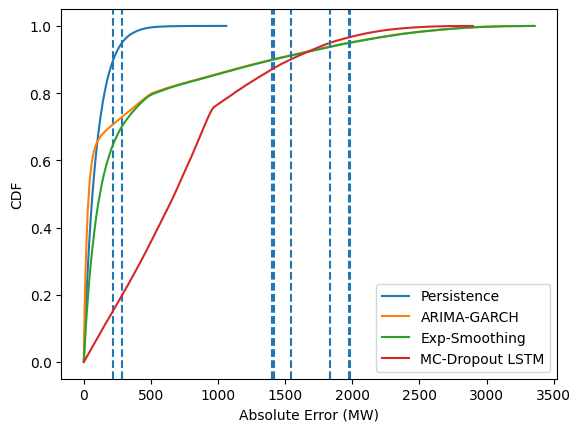

In [ ]:
plt.figure()
for m in methods:
    data = np.sort(df_res[f"err_abs_{m}"].dropna())
    p = np.linspace(0,1,len(data))
    plt.plot(data, p, label=m)
    # annotate 90/95th
    for q in [90,95]:
        plt.axvline(np.percentile(data,q), linestyle="--")
plt.legend(); plt.xlabel("Absolute Error (MW)"); plt.ylabel("CDF")

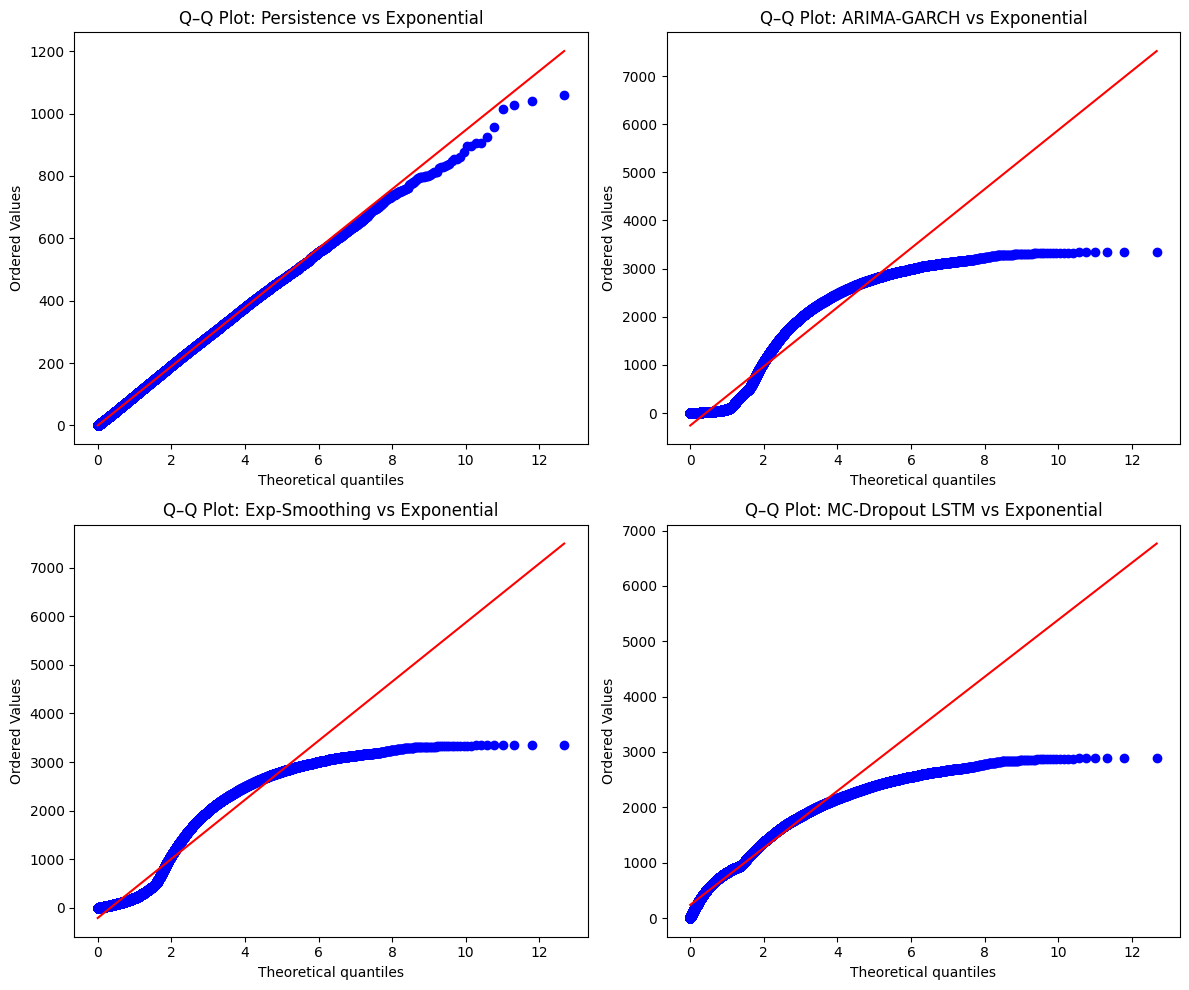

In [ ]:
# Code Cell: Q–Q plots against exponential distribution in a 2×2 grid
import scipy.stats as st
import matplotlib.pyplot as plt

methods = ["Persistence", "ARIMA‑GARCH", "Exp‑Smoothing", "MC_Dropout_LSTM"]  # or however you named them

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, m in zip(axes, methods):
    # dropna in case some methods have missing values
    data = df_res[f"err_abs_{m}"].dropna()
    st.probplot(data, dist="expon", plot=ax)
    ax.set_title(f"Q–Q Plot: {m} vs Exponential")

plt.tight_layout()
plt.show()

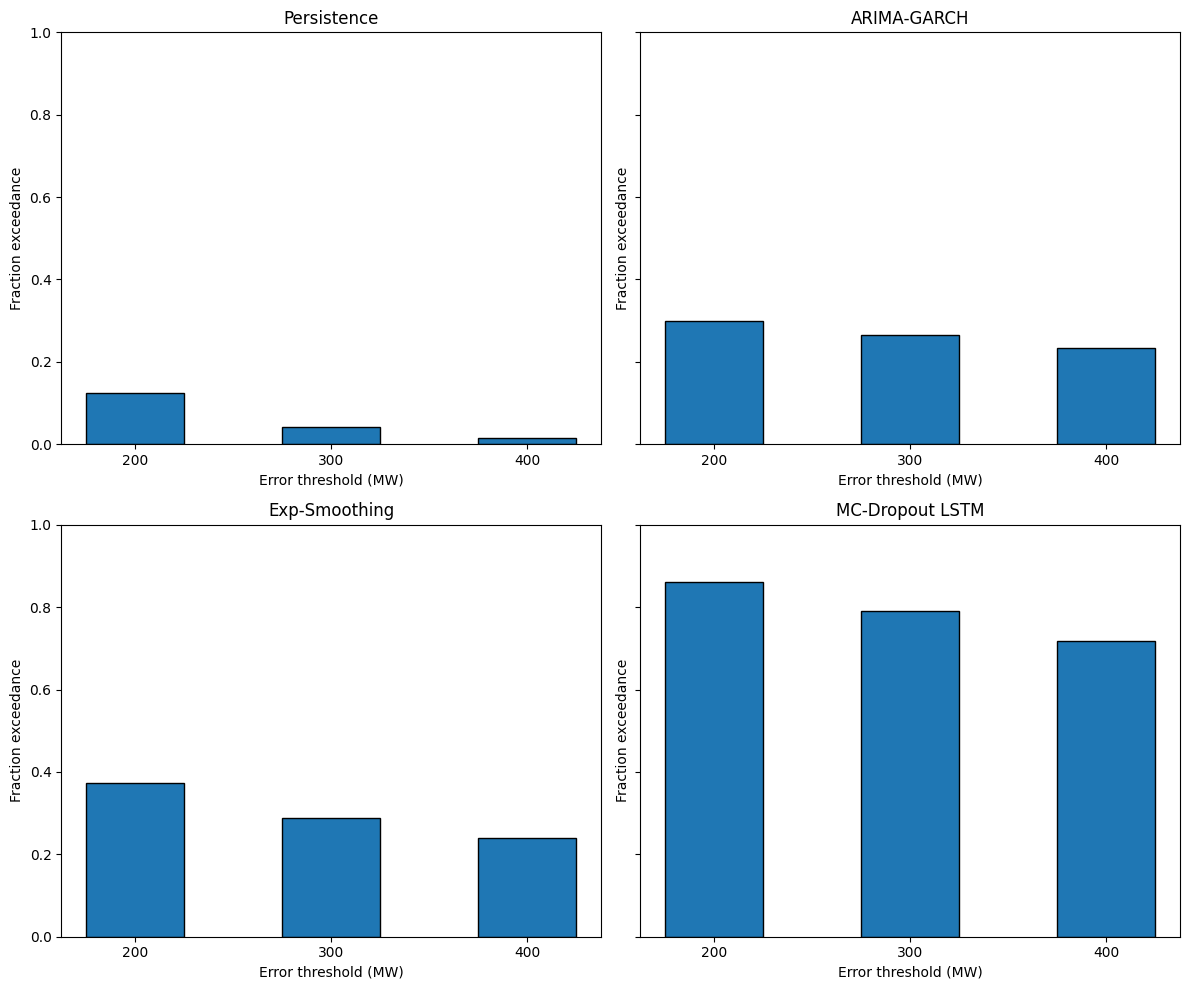

In [ ]:
# Code Cell: Bar‐plot of “% of errors > X MW” by method in a 2×2 grid
import matplotlib.pyplot as plt

thresholds = [200, 300, 400]
methods = ["Persistence", "ARIMA‑GARCH", "Exp‑Smoothing", "MC_Dropout_LSTM"]

# compute fraction exceedances
frac = {
    m: [(df_res[f"err_abs_{m}"] > t).mean() for t in thresholds]
    for m in methods
}

# create 2×2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()

for ax, m in zip(axes, methods):
    ax.bar(thresholds, frac[m], width=50, edgecolor='k')
    ax.set_title(m)
    ax.set_xlabel("Error threshold (MW)")
    ax.set_ylabel("Fraction exceedance")
    ax.set_xticks(thresholds)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
d = df_res["err_sq_ARIMA‑GARCH"] - df_res["err_sq_MC_Dropout_LSTM"]

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Revised Diebold-Mariano with correct lag-0 handling
def diebold_mariano(y_true, y_pred1, y_pred2, h=1, power=2):
    y_true = np.asarray(y_true)
    y_pred1 = np.asarray(y_pred1)
    y_pred2 = np.asarray(y_pred2)
    e1 = y_true - y_pred1
    e2 = y_true - y_pred2
    if power == 1:
        d = np.abs(e1) - np.abs(e2)
    else:
        d = e1**2 - e2**2
    T = len(d)
    d_mean = d.mean()
    M = max(0, h - 1)
    # corrected autocov: lag=0 → variance, lag>0 → covariance
    def autocov(x, lag):
        if lag == 0:
            return np.var(x, ddof=0)
        return np.cov(x[lag:], x[:-lag], bias=True)[0,1]
    gamma = [autocov(d, lag) for lag in range(1, M+1)]
    var_d = (autocov(d, 0) + 2 * sum(gamma)) / T
    dm_stat = d_mean / np.sqrt(var_d)
    p_value = 2 * (1 - norm.cdf(abs(dm_stat)))
    return dm_stat, p_value

In [ ]:
import pandas as pd

# Calculate the sum of NaN values for each column
nan_counts_per_column = df_res.isnull().sum()

# Filter to show only columns with more than 0 NaN values
columns_with_nans = nan_counts_per_column[nan_counts_per_column > 0]

# Print the result
if not columns_with_nans.empty:
    print("Columns with NaN values (and their counts):")
    print(columns_with_nans)
else:
    print("No columns in df_features contain NaN values.")


Columns with NaN values (and their counts):
MC‑Dropout LSTM            4
err_abs_MC‑Dropout LSTM    4
err_sq_MC‑Dropout LSTM     4
MC_Dropout_LSTM            4
dtype: int64


In [ ]:
df_res_cleaned = df_res.dropna()

In [ ]:
import pandas as pd

# Calculate the sum of NaN values for each column
nan_counts_per_column = df_res_cleaned.isnull().sum()

# Filter to show only columns with more than 0 NaN values
columns_with_nans = nan_counts_per_column[nan_counts_per_column > 0]

# Print the result
if not columns_with_nans.empty:
    print("Columns with NaN values (and their counts):")
    print(columns_with_nans)
else:
    print("No columns in df_features contain NaN values.")


No columns in df_features contain NaN values.


In [ ]:
# Diebold–Mariano comparisons on df_res_cleaned
pairs = [
    ("MC_Dropout_LSTM", "Persistence"),
    ("MC_Dropout_LSTM", "ARIMA_GARCH"),
    ("MC_Dropout_LSTM", "Exp_Smoothing"),
    ("Persistence",       "ARIMA_GARCH"),
]

results = []
for m1, m2 in pairs:
    stat, p = diebold_mariano(
        df_res_cleaned["y_true"],
        df_res_cleaned[m1],
        df_res_cleaned[m2],
        h=4,
        power=2
    )
    results.append({
        "Model 1": m1,
        "Model 2": m2,
        "DM Stat": stat,
        "p-value": p
    })

df_dm = pd.DataFrame(results)
heatmap_data = df_dm.pivot(index="Model 1", columns="Model 2", values="p-value")

print("Diebold–Mariano Test Results:")
display(df_dm.set_index(["Model 1", "Model 2"])[["DM Stat", "p-value"]])

Diebold–Mariano Test Results:


DM Stat  p-value
Model 1         Model 2                           
MC_Dropout_LSTM Persistence    130.975160      0.0
                ARIMA_GARCH     48.079327      0.0
                Exp_Smoothing   45.221580      0.0
Persistence     ARIMA_GARCH    -65.336592      0.0

In [ ]:
import pandas as pd

# Calculate the sum of NaN values for each column
nan_counts_per_column = df_res.isnull().sum()

# Filter to show only columns with more than 0 NaN values
columns_with_nans = nan_counts_per_column[nan_counts_per_column > 0]

# Print the result
if not columns_with_nans.empty:
    print("Columns with NaN values (and their counts):")
    print(columns_with_nans)
else:
    print("No columns in df_features contain NaN values.")


No columns in df_features contain NaN values.


In [ ]:
# FILTER METHOD — Top 40 by Mutual Information
from sklearn.feature_selection import SelectKBest, mutual_info_regression

selector = SelectKBest(mutual_info_regression, k=40)
selector.fit(X, y)
top40_filter = X.columns[selector.get_support()].tolist()

print("Top 40 by Mutual Information:")
print(top40_filter)

Top 40 by Mutual Information:
['IE Wind Availability', 'SNSP', 'SW_wdsp', 'SE_wdsp', 'wind_lag_1', 'wind_lag_2', 'wind_lag_3', 'wind_lag_4', 'wind_roll1h_mean', 'windspd_S', 'windspd_SE', 'NW_wdsp_roll1h_mean', 'NW_wdsp_roll3h_mean', 'SW_wdsp_roll1h_mean', 'SW_wdsp_roll3h_mean', 'SW_wdsp_roll6h_mean', 'SE_wdsp_roll1h_mean', 'SE_wdsp_roll3h_mean', 'wind_lag_1_roll1h_mean', 'wind_lag_1_roll3h_mean', 'wind_lag_1_roll6h_mean', 'wind_lag_1_roll12h_mean', 'wind_lag_2_roll1h_mean', 'wind_lag_2_roll3h_mean', 'wind_lag_2_roll6h_mean', 'wind_lag_2_roll12h_mean', 'wind_lag_3_roll1h_mean', 'wind_lag_3_roll3h_mean', 'wind_lag_3_roll6h_mean', 'wind_lag_3_roll12h_mean', 'wind_lag_4_roll1h_mean', 'wind_lag_4_roll3h_mean', 'wind_lag_4_roll6h_mean', 'wind_lag_4_roll12h_mean', 'wind_roll1h_mean_roll1h_mean', 'wind_roll1h_mean_roll3h_mean', 'wind_roll1h_mean_roll6h_mean', 'wind_roll1h_mean_roll12h_mean', 'wind_roll1h_std_roll6h_mean', 'wind_roll1h_std_roll12h_mean']


In [ ]:
# FILTERED GPU-ACCELERATED XGBOOST IMPORTANCE — Top 40
import xgboost as xgb
import pandas as pd

model = xgb.XGBRegressor(
    tree_method="hist",
    device="cuda",
    n_estimators=200,
    max_depth=16,
    random_state=SEED
)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
top40_rf = importances.nlargest(40).index.tolist()

print("Top 40 by GPU-accelerated XGBoost importance:")
print(top40_rf)

Top 40 by GPU-accelerated XGBoost importance:
['wind_lag_1', 'IE Wind Availability', 'wind_roll1h_mean', 'wind_lag_2_roll1h_mean', 'wind_lag_1_roll1h_mean', 'wind_lag_2', 'wind_roll1h_std', 'wind_lag_3_roll1h_mean', 'wind_lag_2_roll3h_mean', 'wind_lag_3', 'wind_lag_4_roll1h_mean', 'wind_lag_1_roll3h_mean', 'wind_lag_3_roll3h_mean', 'Net_load_roll30d_90pct_sq', 'wind_lag_4_roll3h_mean', 'wind_lag_1_roll1h_std', 'wind_lag_4_roll6h_mean', 'Net_load_roll30d_var', 'cos_hour', 'IE Wind Generation_roll30d_var', 'Net_load', 'wind_roll1h_mean_roll3h_mean', 'IE Demand_roll30d_90pct_sq', 'IE Demand_roll7d_90pct_sq', 'IE Wind Generation_roll30d_90pct_sq', 'NW_wdsp_roll12h_mean', 'SW_temp_roll3h_mean', 'IE Demand_roll24h_var', 'wind_lag_4', 'SE_temp_roll12h_mean', 'SW_wdsp_roll6h_mean', 'SW_temp_roll12h_mean', 'cos_month', 'wind_lag_1_roll6h_mean', 'NE_temp_roll12h_mean', 'wind_roll1h_std_roll3h_std', 'cos_doy', 'SE_temp_roll6h_mean', 'NE_wdsp_roll1h_mean', 'wind_lag_2_roll6h_mean']


In [ ]:
# WRAPPER METHOD — GPU-BACKED RFE to select Top 40
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor

xgb_gpu = XGBRegressor(
    tree_method="hist",
    device="cuda",
    n_estimators=100,
    max_depth=8,
    random_state=SEED
)
rfe = RFE(estimator=xgb_gpu, n_features_to_select=40, step=0.1, verbose=1)
rfe.fit(X, y)

top40_rfe = X.columns[rfe.support_].tolist()
print("Top 40 by GPU-backed RFE:")
print(top40_rfe)

Fitting estimator with 187 features.
Fitting estimator with 169 features.
Fitting estimator with 151 features.
Fitting estimator with 133 features.
Fitting estimator with 115 features.
Fitting estimator with 97 features.
Fitting estimator with 79 features.
Fitting estimator with 61 features.
Fitting estimator with 43 features.
Top 40 by GPU-backed RFE:
['IE Generation', 'IE Demand', 'IE Wind Availability', 'SNSP', 'interconnection', 'Net_load', 'wind_lag_1', 'wind_lag_2', 'wind_lag_3', 'wind_roll1h_mean', 'wind_roll1h_std', 'hour', 'sin_hour', 'cos_hour', 'cos_month', 'IE Wind Generation_roll30d_var', 'IE Demand_roll30d_var', 'IE Demand_roll30d_90pct_sq', 'Net_load_roll30d_var', 'Net_load_roll30d_90pct_sq', 'NE_temp_roll6h_mean', 'SW_temp_roll6h_mean', 'SE_temp_roll3h_mean', 'SE_temp_roll6h_mean', 'NW_wdsp_roll6h_mean', 'NW_wdsp_roll12h_mean', 'NE_wdsp_roll1h_mean', 'NE_wdsp_roll3h_mean', 'SW_wdsp_roll6h_mean', 'wind_lag_1_roll1h_mean', 'wind_lag_1_roll1h_std', 'wind_lag_1_roll3h_mean'

In [ ]:
# INTERSECTION of the three methods
common_top20 = sorted(
    set(top40_filter) &
    set(top40_rf) &
    set(top40_rfe)
)
print("Features selected by all three methods:")
print(common_top20)

Features selected by all three methods:
['IE Wind Availability', 'SW_wdsp_roll6h_mean', 'wind_lag_1', 'wind_lag_1_roll1h_mean', 'wind_lag_1_roll3h_mean', 'wind_lag_2', 'wind_lag_2_roll1h_mean', 'wind_lag_2_roll3h_mean', 'wind_lag_3', 'wind_lag_3_roll1h_mean', 'wind_lag_3_roll3h_mean', 'wind_lag_4_roll1h_mean', 'wind_lag_4_roll3h_mean', 'wind_roll1h_mean', 'wind_roll1h_mean_roll3h_mean']


In [ ]:
common_top20 = ['IE Wind Availability', 'SW_wdsp_roll6h_mean', 'wind_lag_1', 'wind_lag_1_roll1h_mean', 'wind_lag_1_roll3h_mean', 'wind_lag_2', 'wind_lag_2_roll1h_mean', 'wind_lag_2_roll3h_mean', 'wind_lag_3', 'wind_lag_3_roll1h_mean', 'wind_lag_3_roll3h_mean', 'wind_lag_4_roll1h_mean', 'wind_lag_4_roll3h_mean', 'wind_roll1h_mean', 'wind_roll1h_mean_roll3h_mean']

In [ ]:
len(common_top20)

15

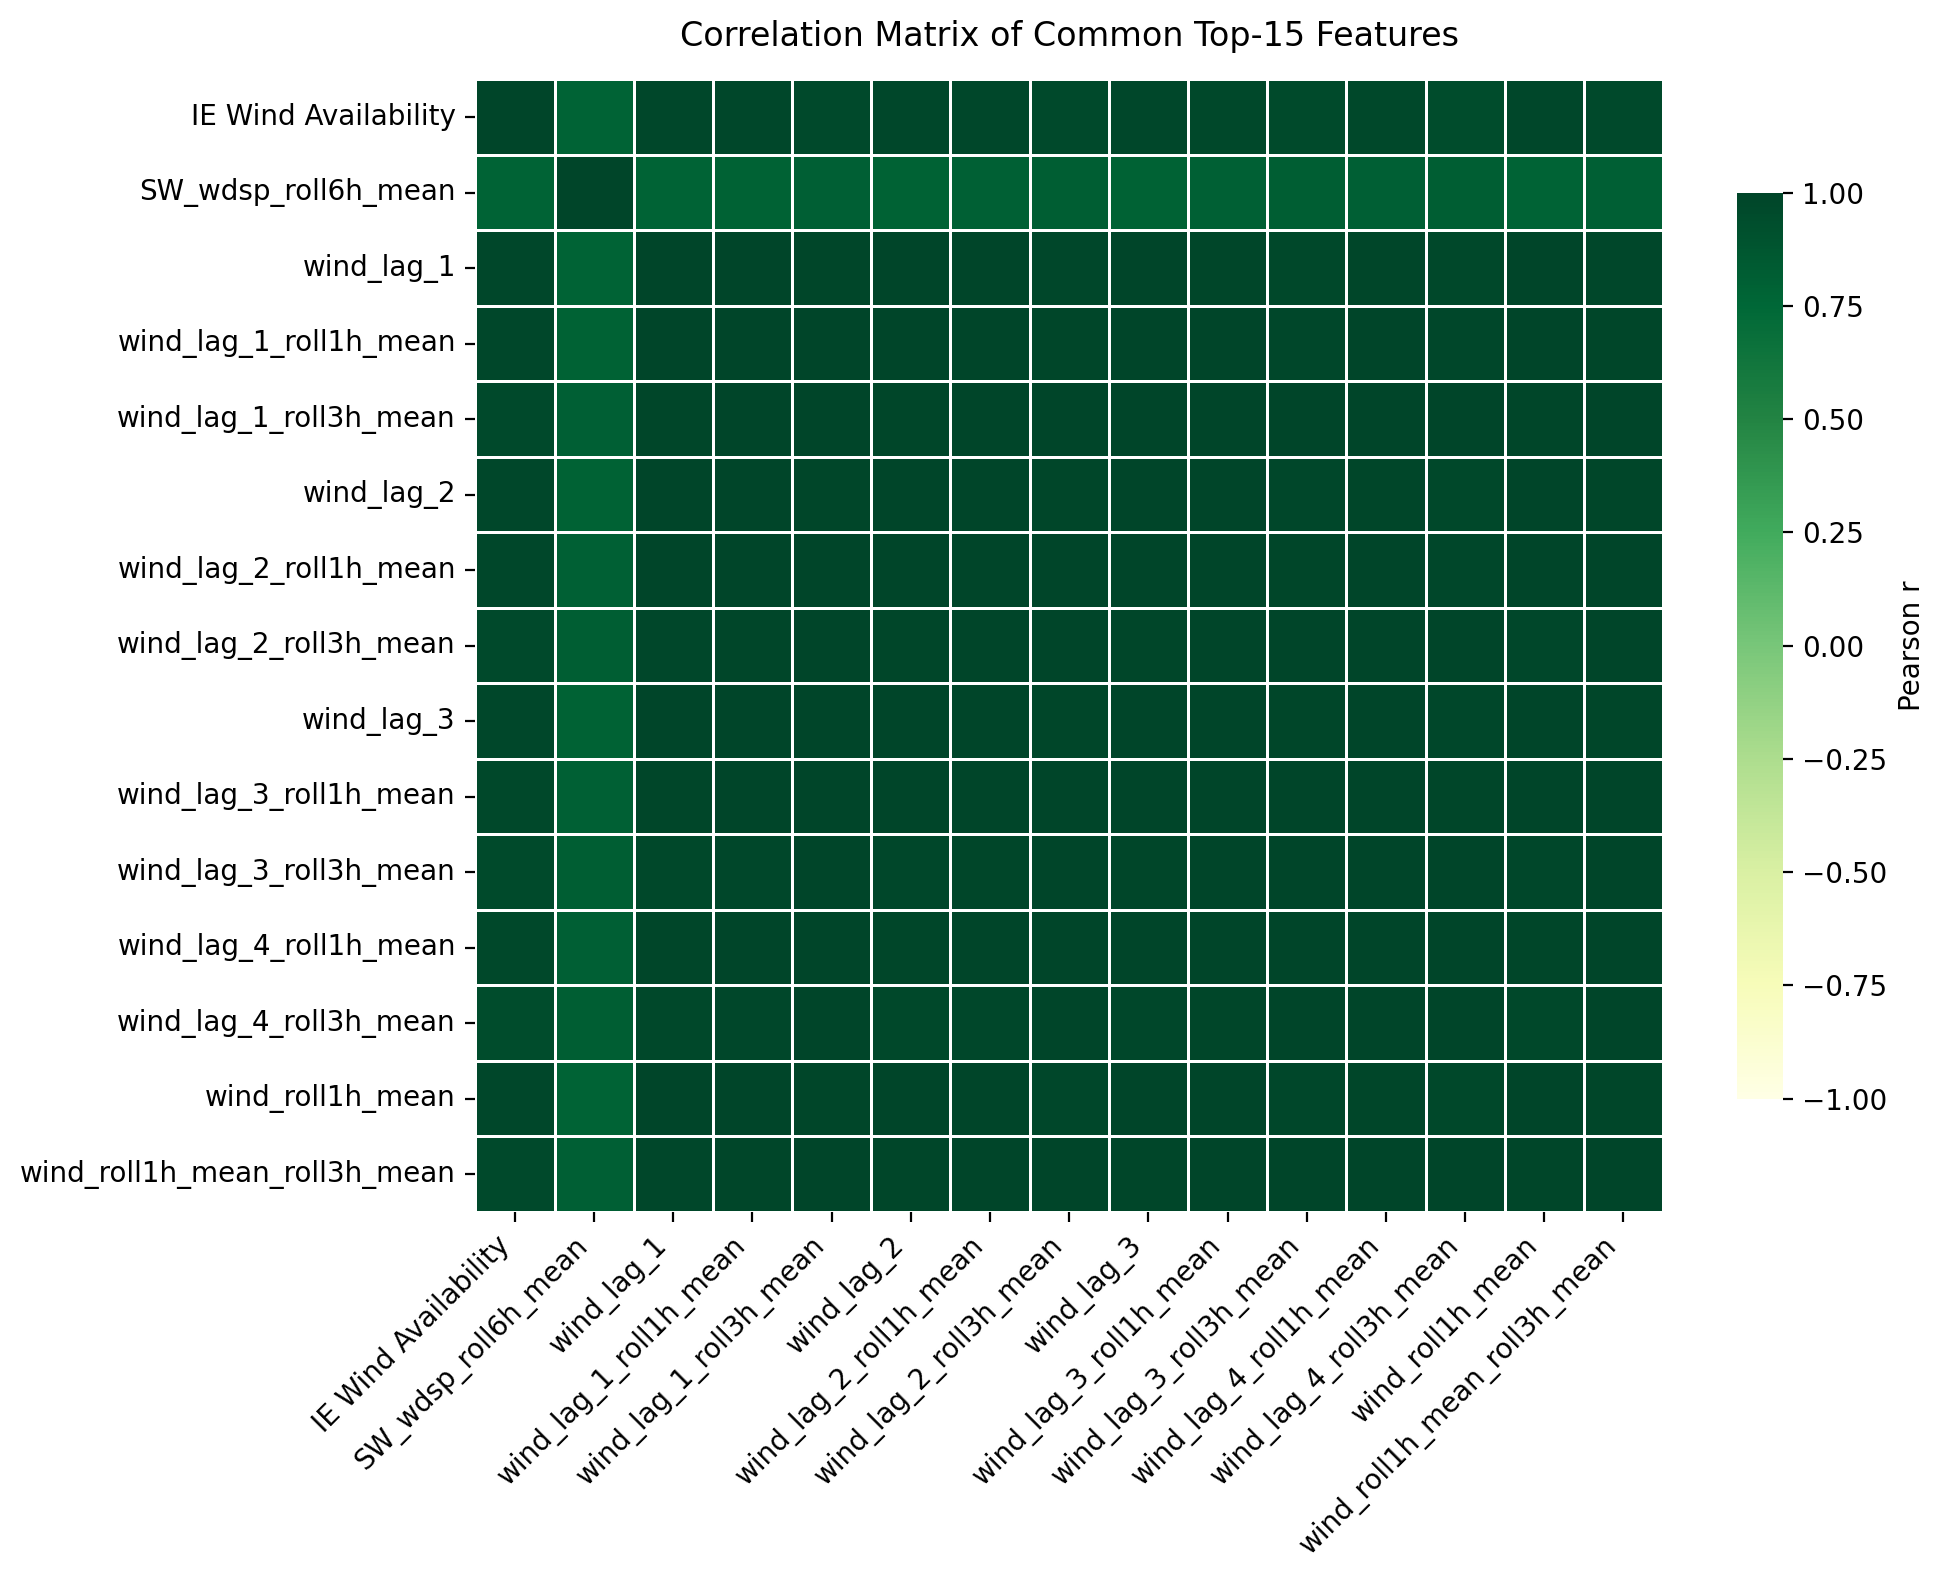

In [ ]:
# Correlation Heatmap of the Common Top-15 Features

import seaborn as sns
import matplotlib.pyplot as plt

X_sel = X[common_top20]
corr = X_sel.corr()

plt.figure(figsize=(10, 8), dpi=200)
sns.heatmap(
    corr,
    annot=False,          # remove numbers inside the squares
    cmap="YlGn",          # green-to-yellow colormap
    vmin=-1, vmax=1,      # full correlation range
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Pearson r"}
)
plt.title("Correlation Matrix of Common Top-15 Features", pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# 0) Subset your DataFrame to only the selected features + target
df_sub = df_feat_eng[common_top20 + ["IE Wind Generation"]].copy()

In [ ]:
# Code Cell: Dump reduced‐feature df_sub to its own HDF5 store (features + separate target) and set latest_h5_sub

import os
import numpy as np
import h5py
from datetime import datetime

# 1) Subset df_sub to features-only and extract target separately
features_only = df_sub[common_top20].to_numpy(dtype=np.float32)
target_array  = df_sub["IE Wind Generation"].to_numpy(dtype=np.float32)
idx_int       = df_sub.index.view("int64")

# 2) Build file path under D:\Colab\... via WSL mount
version     = "common_top20"
timestamp   = datetime.now().strftime("%Y%m%d_%H%M%S")
h5_dir_sub  = "/mnt/d/Colab/Summer Project/Final/New Project/study/store/HDF5"
os.makedirs(h5_dir_sub, exist_ok=True)
h5_path_sub = os.path.join(h5_dir_sub, f"df_sub_{version}_{timestamp}.h5")

with h5py.File(h5_path_sub, "w") as f:
    # 3) Write features-only data
    n_feats_sub = features_only.shape[1]
    f.create_dataset(
        "data",
        data=features_only,
        dtype="float32",
        chunks=(seq_len, n_feats_sub),
        compression=None
    )
    # 4) Write target as its own dataset
    f.create_dataset(
        "target",
        data=target_array,
        dtype="float32",
        chunks=(seq_len,),      # chunk along time
        compression=None
    )
    # 5) Save index
    f.create_dataset("index_ns", data=idx_int, dtype="int64")
    # 6) Save the full list of column names (features + target)
    str_dt = h5py.string_dtype(encoding="utf-8")
    f.create_dataset(
        "columns",
        data=np.array(common_top20 + ["IE Wind Generation"], dtype=object),
        dtype=str_dt
    )

print(f"Wrote reduced‐feature HDF5 store with separate target to:\n    {h5_path_sub}")

Wrote reduced‐feature HDF5 store with separate target to:
    /mnt/d/Colab/Summer Project/Final/New Project/study/store/HDF5/df_sub_common_top20_20250802_082630.h5


In [ ]:
# --- Cell 89: complete HDF5WindowDatasetv2 ---

import h5py, numpy as np, torch
from torch.utils.data import Dataset

class HDF5WindowDatasetv2(Dataset):
    def __init__(self,
                 h5_path: str,
                 indices: np.ndarray,
                 seq_len: int,
                 horizon_steps: int,
                 target_col_name: str = None):
        """
        Reads feature windows from dataset '/data' and targets from '/target'.
        - indices: integer row positions that mark the END of the input window.
        - Each sample returns X[t-seq_len : t, :] and y[t + horizon_steps].
        """
        self.h5_path  = h5_path
        self.indices  = np.asarray(indices, dtype=np.int64)
        self.seq_len  = int(seq_len)
        self.horizon  = int(horizon_steps)

        self._file    = None
        self._data    = None
        self._target  = None
        self._n_rows  = None
        self._n_feats = None

    def _lazy_open(self):
        if self._file is None:
            f = h5py.File(self.h5_path, "r")
            self._file   = f
            self._data   = f["data"]    # shape: (T, F), float32
            self._target = f["target"]  # shape: (T,),   float32
            self._n_rows = self._data.shape[0]
            self._n_feats= self._data.shape[1]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        self._lazy_open()
        pos   = int(self.indices[idx])
        start = pos - self.seq_len
        end   = pos

        # Safety checks: full lookback exists and future target exists
        if start < 0 or (pos + self.horizon) >= self._n_rows:
            raise IndexError(
                f"Index {pos} out of bounds for seq_len={self.seq_len}, "
                f"horizon={self.horizon}, n_rows={self._n_rows}"
            )

        X = self._data[start:end, :]                     # (seq_len, F)
        y = self._target[pos + self.horizon]            # scalar

        # Return torch tensors
        return (
            torch.from_numpy(np.asarray(X, dtype=np.float32)),
            torch.tensor(float(y), dtype=torch.float32)
        )

    def close(self):
        if self._file is not None:
            try:
                self._file.close()
            finally:
                self._file = self._data = self._target = None

    def __del__(self):
        self.close()

In [ ]:
# Generate walk-forward CV splits on the reduced feature set (common_top20 + target)
import pandas as pd
from pandas.tseries.offsets import DateOffset

# 0) Subset your DataFrame to only the selected features + target
df_sub = df_feat_eng[common_top20 + ["IE Wind Generation"]].copy()

# 1) Define parameters (same as before)
df_start      = pd.Timestamp("2014-01-01 00:00:00")
test_start    = pd.Timestamp("2024-08-01 00:00:00")
val_horizon   = DateOffset(years=1)
step          = pd.Timedelta(minutes=15)
horizon       = 4 * step
horizon_steps = int(horizon / step)  # = 4
seq_len       = 96                   # 1-day lookback

# 2) Build CV fold boundaries (unique var names)
folds_sub = []
train_start = df_start
train_end   = train_start + DateOffset(years=2) - step

while True:
    val_start     = train_end + step
    tentative_end = val_start + val_horizon - step
    val_end       = min(tentative_end, test_start - step)
    folds_sub.append({
        "train_start": train_start,
        "train_end":   train_end,
        "val_start":   val_start,
        "val_end":     val_end
    })
    if val_end >= test_start - step:
        break
    train_end = val_end

# 3) Convert to index lists, filtering out edges
splits_sub = []
min_ts = df_sub.index.min()
max_ts = df_sub.index.max()

for f in folds_sub:
    idx_tr = df_sub.loc[f["train_start"]:f["train_end"]].index
    idx_val = df_sub.loc[f["val_start"]:f["val_end"]].index

    tr_idx = [
        t for t in idx_tr
        if (t - seq_len*step) >= min_ts and (t + horizon) <= max_ts
    ]
    vl_idx = [
        t for t in idx_val
        if (t - seq_len*step) >= min_ts and (t + horizon) <= max_ts
    ]
    splits_sub.append((pd.DatetimeIndex(tr_idx), pd.DatetimeIndex(vl_idx)))

# 4) Final test indices + integer positions
test_idx_sub = df_sub.loc[test_start:].index
test_pos_sub = df_sub.index.get_indexer(test_idx_sub)

# 5) Report
print(f"Generated {len(splits_sub)} folds (horizon_steps={horizon_steps}) on reduced data:")
for i, (tr, vl) in enumerate(splits_sub, 1):
    print(f" Fold {i}: train={len(tr)} samples, val={len(vl)} samples")
print(f"Test period → {test_start.date()} to {max_ts.date()}, "
      f"timestamps: {len(test_idx_sub)}, positions: {len(test_pos_sub)}")

Generated 9 folds (horizon_steps=4) on reduced data:
 Fold 1: train=69976 samples, val=35136 samples
 Fold 2: train=105112 samples, val=35040 samples
 Fold 3: train=140152 samples, val=35040 samples
 Fold 4: train=175192 samples, val=35040 samples
 Fold 5: train=210232 samples, val=35136 samples
 Fold 6: train=245368 samples, val=35040 samples
 Fold 7: train=280408 samples, val=35040 samples
 Fold 8: train=315448 samples, val=35040 samples
 Fold 9: train=350488 samples, val=20448 samples
Test period → 2024-08-01 to 2025-04-30, timestamps: 26113, positions: 26113


In [ ]:
# Compact CV + test loop for MCDropoutLSTM with HDF5WindowDatasetv2

import os, h5py, numpy as np, pandas as pd, torch
from torch.utils.data import DataLoader, SequentialSampler, BatchSampler
from sklearn.metrics import mean_squared_error
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping
from scipy.stats import norm

# --- Config ---
H5_PATH   = h5_path_sub          # reduced-feature store (features=/data, target=/target)
SEQ_LEN   = 96                    # 1-day lookback
HORIZON   = 4                     # 1-hour ahead (4×15 min)
BATCH     = 256
EPOCHS    = 30
OUT_DIR   = r"D:\Colab\Summer Project\Final\New Project\training\lstm_v2"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Helpers: map timestamps -> valid integer positions in HDF5 ---
def load_h5_index(h5_path):
    with h5py.File(h5_path, "r") as f:
        idx = pd.to_datetime(f["index_ns"][()], unit="ns")
        n_rows = f["data"].shape[0]
        n_feats = f["data"].shape[1]
    return idx, n_rows, n_feats

def to_positions(ts_idx, h5_idx):
    pos = h5_idx.get_indexer(ts_idx)
    return pos[pos >= 0]  # drop missing

def valid_positions(pos, seq_len, horizon, n_rows):
    pos = np.asarray(pos, dtype=np.int64)
    m = (pos >= seq_len) & (pos + horizon < n_rows)
    return pos[m]

def make_loader(h5_path, positions, batch_size=BATCH, shuffle=True):
    ds = HDF5WindowDatasetv2(h5_path, positions, SEQ_LEN, HORIZON)
    if shuffle:
        base = SequentialSampler(ds)
        batches = list(BatchSampler(base, batch_size=batch_size, drop_last=False))
        np.random.shuffle(batches)
        return DataLoader(ds, batch_sampler=batches, num_workers=4,
                          pin_memory=True, persistent_workers=True)
    else:
        return DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4,
                          pin_memory=True, persistent_workers=True)

# --- HDF5 shape/index ---
h5_idx, N, F = load_h5_index(H5_PATH)

# --- Hyperparams (fallbacks; will use best_params if defined) ---
params = dict(hidden_size=64, num_layers=3, dropout=0.3, lr=1e-4)
try:
    params.update(dict(
        hidden_size = best_params["hidden_size"],
        num_layers  = best_params["num_layers"],
        dropout     = best_params.get("dropout_rate", best_params.get("dropout", 0.3)),
        lr          = best_params.get("learning_rate", best_params.get("lr", 1e-4)),
    ))
except NameError:
    pass

# --- Cross-validation training/eval ---
z80, z95 = norm.ppf(0.90), norm.ppf(0.975)
rmse_cv, cov80_cv, cov95_cv = [], [], []

for i, (train_ts, val_ts) in enumerate(splits, 1):
    train_pos = valid_positions(to_positions(train_ts, h5_idx), SEQ_LEN, HORIZON, N)
    val_pos   = valid_positions(to_positions(val_ts,   h5_idx), SEQ_LEN, HORIZON, N)

    train_loader = make_loader(H5_PATH, train_pos, shuffle=True)
    val_loader   = make_loader(H5_PATH, val_pos,   shuffle=False)

    model = MCDropoutLSTM(input_size=F, **params)
    trainer = Trainer(
        max_epochs=EPOCHS,
        logger=CSVLogger(save_dir=OUT_DIR, name=f"cv_fold{i}"),
        callbacks=[EarlyStopping(monitor="val_loss_epoch", patience=5)],
        enable_checkpointing=False,
        enable_progress_bar=False,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        precision="16-mixed" if torch.cuda.is_available() else 32,
    )
    trainer.fit(model, train_loader, val_loader)

    # MC-dropout eval on validation
    model.eval()
    all_mean, all_std, all_true = [], [], []
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(model.device, non_blocking=True)
            mu, sd = mc_dropout_predict(model, Xb, n_samples=50)
            all_mean.append(mu); all_std.append(sd); all_true.append(yb.numpy())
    y_hat = np.concatenate(all_mean)
    y_sd  = np.concatenate(all_std)
    y_true= np.concatenate(all_true)

    rmse  = np.sqrt(mean_squared_error(y_true, y_hat))
    cov80 = np.mean(np.abs(y_true - y_hat) <= z80 * y_sd)
    cov95 = np.mean(np.abs(y_true - y_hat) <= z95 * y_sd)

    rmse_cv.append(rmse); cov80_cv.append(cov80); cov95_cv.append(cov95)
    print(f"Fold {i}: RMSE={rmse:.2f}, Cov80={cov80:.3f}, Cov95={cov95:.3f}")

print("\nCV Summary → "
      f"RMSE {np.mean(rmse_cv):.2f} ± {np.std(rmse_cv):.2f}, "
      f"Cov80 {np.mean(cov80_cv):.3f}, Cov95 {np.mean(cov95_cv):.3f}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 1.9 M  | train
1 | dropout   | Dropout | 0      | train
2 | fc        | Linear  | 257    | train
3 | criterion | MSELoss | 0      | train
----------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.435     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=50` reached.


Reduced-feature model saved to:
    /mnt/d/Colab/Summer Project/Final/New Project/study/optuna/mc_dropout_lstm_reduced_20250731_140011.pt


In [ ]:
# --- Final fit on all CV data, evaluate on test_idx ---
all_train_ts = pd.DatetimeIndex(sorted(np.unique(
    np.concatenate([np.asarray(tr) for tr, _ in splits] + [np.asarray(vl) for _, vl in splits])
)))
full_train_pos = valid_positions(to_positions(all_train_ts, h5_idx), SEQ_LEN, HORIZON, N)
test_pos       = valid_positions(to_positions(test_idx,   h5_idx), SEQ_LEN, HORIZON, N)

train_loader = make_loader(H5_PATH, full_train_pos, shuffle=True)
test_loader  = make_loader(H5_PATH, test_pos,       shuffle=False)

model = MCDropoutLSTM(input_size=F, **params)
trainer = Trainer(
    max_epochs=EPOCHS,
    enable_checkpointing=False,
    enable_progress_bar=False,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    precision="16-mixed" if torch.cuda.is_available() else 32,
)
trainer.fit(model, train_loader)

# Test inference (MC-dropout)
model.eval()
all_mean, all_std, all_true = [], [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(model.device, non_blocking=True)
        mu, sd = mc_dropout_predict(model, Xb, n_samples=50)
        all_mean.append(mu); all_std.append(sd); all_true.append(yb.numpy())
y_hat = np.concatenate(all_mean)
y_sd  = np.concatenate(all_std)
y_true= np.concatenate(all_true)

rmse  = np.sqrt(mean_squared_error(y_true, y_hat))
cov80 = np.mean(np.abs(y_true - y_hat) <= z80 * y_sd)
cov95 = np.mean(np.abs(y_true - y_hat) <= z95 * y_sd)
print(f"\nTest → RMSE={rmse:.2f}, Cov80={cov80:.3f}, Cov95={cov95:.3f}")

Final Test RMSE on reduced-feature model: 314.829


In [ ]:
# Code Cell: Optuna search + save best params + retrain on full train+val + dump final model

import os
import json
import numpy as np
import torch
import optuna
import traceback

from torch.utils.data import DataLoader, SequentialSampler, BatchSampler
from torch.utils.data._utils.collate import default_collate

import lightning.pytorch as pl
from lightning.pytorch import LightningModule
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger

from sklearn.metrics import mean_squared_error
from datetime import datetime

# ---- 1) LightningModule subclass with new hook signature ----
class MCDropoutLSTMv2(LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, dropout, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lstm    = torch.nn.LSTM(input_size, hidden_size,
                                     num_layers=num_layers,
                                     dropout=dropout,
                                     batch_first=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.fc      = torch.nn.Linear(hidden_size, 1)
        self.lr      = lr

        # accumulators for validation
        self._val_preds = []
        self._val_truth = []

    def forward(self, x):
        out, _ = self.lstm(x)
        h      = out[:, -1, :]
        h      = self.dropout(h)
        return self.fc(h).squeeze(-1)

    def training_step(self, batch, batch_idx):
        x, y   = batch
        y_hat  = self(x)
        loss   = torch.nn.functional.mse_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y    = batch
        y_hat   = self(x)
        loss    = torch.nn.functional.mse_loss(y_hat, y)
        self.log("val_loss_epoch", loss, prog_bar=True)
        # accumulate for epoch end
        self._val_preds.append(y_hat.detach().cpu())
        self._val_truth.append(y.detach().cpu())

    def on_validation_epoch_end(self):
        preds = torch.cat(self._val_preds, dim=0).numpy()
        truth = torch.cat(self._val_truth, dim=0).numpy()
        rmse  = np.sqrt(mean_squared_error(truth, preds))
        self.log("val_rmse", rmse, prog_bar=True)
        # clear accumulators
        self._val_preds.clear()
        self._val_truth.clear()

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(),
            lr=self.lr,
            weight_decay=self.hparams.get("weight_decay", 0.0)
        )


# ---- 2) Experiment setup ----
run_ts      = datetime.now().strftime("%Y%m%d_%H%M%S")
SEARCH_DIR  = f"/mnt/d/Colab/Summer Project/Final/New Project/study/search/{run_ts}"
OPTUNA_DIR  = f"/mnt/d/Colab/Summer Project/Final/New Project/study/optuna/{run_ts}"
os.makedirs(SEARCH_DIR, exist_ok=True)
os.makedirs(OPTUNA_DIR, exist_ok=True)

HORIZON     = horizon_steps      # from above
SPLITS_TS   = splits             # timestamp splits
H5_PATH_SUB = h5_path_sub        # reduced-feature HDF5
TARGET_COL  = "IE Wind Generation"
SEQ_LEN     = seq_len

def pad_collate(batch):
    Xs, ys = zip(*batch)
    max_t   = max(x.shape[0] for x in Xs)
    n_feats = Xs[0].shape[1]
    padded  = []
    for x in Xs:
        if x.shape[0] < max_t:
            pad = torch.zeros((max_t - x.shape[0], n_feats),
                              dtype=x.dtype, device=x.device)
            padded.append(torch.cat([x, pad], dim=0))
        else:
            padded.append(x)
    return torch.stack(padded, dim=0), default_collate(ys)


# ---- 3) Optuna objective ----
def objective(trial):
    num_layers   = trial.suggest_categorical("num_layers", [3, 4])
    hidden_size  = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
    dropout_rate = trial.suggest_categorical("dropout_rate", [0.01, 0.1, 0.3, 0.5])
    weight_decay = trial.suggest_categorical("weight_decay", [1e-5, 1e-4, 1e-3])
    lr           = trial.suggest_categorical("learning_rate", [3e-4, 1e-4, 3e-5])
    lr_schedule  = trial.suggest_categorical("lr_scheduler", ["none", "step", "cosine"])
    max_epochs   = 50

    fold_losses = []
    for fold_i, (train_ts, val_ts) in enumerate(SPLITS_TS, start=1):
        train_pos = df_sub.index.get_indexer(train_ts)
        val_pos   = df_sub.index.get_indexer(val_ts)

        train_ds = HDF5WindowDatasetv2(H5_PATH_SUB, train_pos, SEQ_LEN, HORIZON, TARGET_COL)
        val_ds   = HDF5WindowDatasetv2(H5_PATH_SUB, val_pos,   SEQ_LEN, HORIZON, TARGET_COL)

        batch_list   = list(BatchSampler(SequentialSampler(train_ds), batch_size=256, drop_last=False))
        np.random.shuffle(batch_list)
        train_loader = DataLoader(train_ds, batch_sampler=batch_list,
                                  collate_fn=pad_collate, num_workers=0)
        val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False,
                                  collate_fn=pad_collate, num_workers=0)

        model = MCDropoutLSTMv2(
            input_size   = len(common_top20),
            hidden_size  = hidden_size,
            num_layers   = num_layers,
            dropout      = dropout_rate,
            lr           = lr
        )
        model.hparams.weight_decay = weight_decay

        if lr_schedule == "step":
            model.lr_scheduler, model.lr_scheduler_params = (
                torch.optim.lr_scheduler.StepLR, {"step_size": 10, "gamma": 0.1}
            )
        elif lr_schedule == "cosine":
            model.lr_scheduler, model.lr_scheduler_params = (
                torch.optim.lr_scheduler.CosineAnnealingLR, {"T_max": max_epochs}
            )

        logger = CSVLogger(save_dir=SEARCH_DIR,
                           name=f"opt{trial.number}_num{num_layers}_hid{hidden_size}_fold{fold_i}")
        trainer = pl.Trainer(
            max_epochs          = max_epochs,
            logger              = logger,
            callbacks           = [EarlyStopping(monitor="val_loss_epoch", patience=5),
                                   LearningRateMonitor(logging_interval="epoch")],
            enable_checkpointing= False,
            enable_progress_bar = False,
            accelerator         = "gpu",
            devices             = 1,
            precision           = 32
        )
        trainer.fit(model, train_loader, val_loader)
        fold_losses.append(float(trainer.callback_metrics["val_loss_epoch"]))

    return float(np.mean(fold_losses))


# ---- 4) Run Optuna ----
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10)
best_params = study.best_trial.params
print("Best trial:", best_params)

[I 2025-07-31 15:46:55,589] A new study created in memory with name: no-name-614ec862-1142-4069-90de-82cf16d6f922
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | lstm    | LSTM    | 1.3 M  | train
1 | dropout | Dropout | 0      | train
2 | fc      | Linear  | 257    | train
--------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.330     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/home/najo1o11/najo1/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to

Best trial: {'num_layers': 3, 'hidden_size': 256, 'dropout_rate': 0.3, 'weight_decay': 0.001, 'learning_rate': 0.0003, 'lr_scheduler': 'none'}


/home/najo1o11/najo1/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | lstm    | LSTM    | 1.3 M  | train
1 | dropout | Dropout | 0      | train
2 | fc      | Linear  | 257    | train
--------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.330     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=50` reached.


✅ Best params and final model saved to:
    /mnt/d/Colab/Summer Project/Final/New Project/study/optuna/20250731_154655


In [ ]:
import torch
from torch.utils.data import DataLoader, SequentialSampler, BatchSampler
from sklearn.metrics import mean_squared_error
import numpy as np

# ---- 5) Save best_params and retrain on full train+val ----
with open(os.path.join(OPTUNA_DIR, "best_params.json"), "w") as fp:
    json.dump(best_params, fp, indent=2)

# prepare all train+val positions
all_pos = np.unique(np.concatenate([
    df_sub.index.get_indexer(tr) for tr, _ in splits_sub
] + [
    df_sub.index.get_indexer(vl) for _, vl in splits_sub
]))

full_ds = HDF5WindowDatasetv2(
    h5_path       = H5_PATH_SUB,
    indices       = all_pos,
    seq_len       = SEQ_LEN,
    horizon_steps = HORIZON,
    target_col_name=TARGET_COL
)
full_loader = DataLoader(full_ds, batch_size=256, shuffle=True,
                         collate_fn=pad_collate, num_workers=4, pin_memory=True)

best_model = MCDropoutLSTMv2(
    input_size   = len(common_top20),
    hidden_size  = best_params["hidden_size"],
    num_layers   = best_params["num_layers"],
    dropout      = best_params["dropout_rate"],
    lr           = best_params["learning_rate"]
)
best_model.hparams.weight_decay = best_params["weight_decay"]

trainer = pl.Trainer(
    max_epochs          = 50,
    accelerator         = "gpu",
    devices             = 1,
    enable_checkpointing= False,
    enable_progress_bar = False
)
trainer.fit(best_model, full_loader)

# 6) Evaluate on the held-out test set
best_model.eval()

# A) Filter out any test positions that would overrun the target array
max_pos = len(df_sub)
valid_test_pos = test_pos_sub[test_pos_sub + horizon_steps < max_pos]

# B) Build a test-only dataset + loader
test_dataset = HDF5WindowDatasetv2(
    h5_path       = h5_path_sub,
    indices       = valid_test_pos,
    seq_len       = seq_len,
    horizon_steps = horizon_steps,
    target_col_name="IE Wind Generation"
)
test_sampler = SequentialSampler(test_dataset)
test_batch   = BatchSampler(test_sampler, batch_size=256, drop_last=False)
test_loader  = DataLoader(
    test_dataset,
    batch_sampler=test_batch,
    collate_fn=pad_collate,
    num_workers=4,
    pin_memory=True
)

# C) Run inference and compute RMSE
all_preds = []
all_trues = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = best_model(X_batch.to(best_model.device)).cpu().numpy()
        all_preds.append(preds)
        all_trues.append(y_batch.numpy())

all_preds = np.concatenate(all_preds)
all_trues = np.concatenate(all_trues)

test_rmse = np.sqrt(mean_squared_error(all_trues, all_preds))
print(f"Test RMSE on best model: {test_rmse:.3f}")

# 7) Save final model weights
out_path = os.path.join(OPTUNA_DIR, "mc_dropout_lstm_optuna_best.pt")
torch.save(best_model.state_dict(), out_path)
print(f"✅ Best params and final model saved to:\n    {OPTUNA_DIR}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | lstm    | LSTM    | 1.3 M  | train
1 | dropout | Dropout | 0      | train
2 | fc      | Linear  | 257    | train
--------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.330     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=50` reached.


Test RMSE on best model: 175.251
✅ Best params and final model saved to:
    /mnt/d/Colab/Summer Project/Final/New Project/study/optuna/20250731_154655


In [ ]:
# Code Cell: Train & Evaluate Best MC-Dropout LSTM v2 on CV and Test Splits (fresh‐model‐per‐fold + cudnn fix)

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, BatchSampler, SequentialSampler
from lightning.pytorch.loggers import CSVLogger

# 0) Disable cuDNN RNN kernels to avoid "cudnn RNN backward" errors
torch.backends.cudnn.enabled = False

# 1) MC-Dropout inference helper
def mc_dropout_predict(model, x, n_samples=50):
    model.eval()  # base model in eval
    preds = []
    with torch.no_grad():
        for _ in range(n_samples):
            # enable only Dropout layers
            for m in model.modules():
                if isinstance(m, nn.Dropout):
                    m.train()
            preds.append(model(x).cpu().numpy())
    preds = np.stack(preds, axis=0)  # (n_samples, batch)
    return preds.mean(axis=0), preds.std(axis=0)

# 2) Paths & hyperparameters
search_dir = "/mnt/d/Colab/Summer Project/Final/New Project/study/search/20250731_154655"
ckpt_path  = "/mnt/d/Colab/Summer Project/Final/New Project/study/optuna/20250731_154655/mc_dropout_lstm_optuna_best.pt"
best_params = {
    "num_layers":   3,
    "hidden_size": 256,
    "dropout_rate": 0.3,
    "weight_decay": 0.001,
    "learning_rate": 0.0003,
}

# 3) Function to train & evaluate one CV fold
def train_and_eval_fold(fold_i, train_ts, val_ts):
    # a) fresh model + load weights
    model = MCDropoutLSTMv2(
        input_size   = len(common_top20),
        hidden_size  = best_params["hidden_size"],
        num_layers   = best_params["num_layers"],
        dropout      = best_params["dropout_rate"],
        lr           = best_params["learning_rate"]
    )
    model.hparams.weight_decay = best_params["weight_decay"]
    checkpoint = torch.load(ckpt_path, map_location="cpu")
    if "state_dict" in checkpoint:
        checkpoint = checkpoint["state_dict"]
    model.load_state_dict(checkpoint)
    model.to(DEVICE)

    # b) DataLoaders
    train_pos = df_sub.index.get_indexer(train_ts)
    val_pos   = df_sub.index.get_indexer(val_ts)
    train_ds = HDF5WindowDatasetv2(H5_PATH_SUB, train_pos, SEQ_LEN, HORIZON, TARGET_COL)
    val_ds   = HDF5WindowDatasetv2(H5_PATH_SUB, val_pos,   SEQ_LEN, HORIZON, TARGET_COL)

    train_loader = DataLoader(
        train_ds,
        batch_sampler=BatchSampler(SequentialSampler(train_ds), batch_size=256, drop_last=False),
        collate_fn=pad_collate, num_workers=4, pin_memory=True
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=256, shuffle=False,
        collate_fn=pad_collate, num_workers=4, pin_memory=True
    )

    # c) fine-tune & log
    logger = CSVLogger(save_dir=search_dir, name=f"bestmodel_fold{fold_i}")
    trainer = pl.Trainer(
        max_epochs=50,
        accelerator="gpu", devices=1,
        logger=logger,
        enable_checkpointing=False,
        enable_progress_bar=False,
        num_sanity_val_steps=0
    )
    trainer.fit(model, train_loader, val_loader)

    # **CRUCIAL**: move model back to GPU for inference
    model.to(DEVICE)
    model.eval()

    # d) inference on validation
    records = []
    for Xb, yb in val_loader:
        Xb = Xb.to(DEVICE)
        means, stds = mc_dropout_predict(model, Xb, n_samples=50)
        truths = yb.numpy()
        for t, y_true, y_pred, y_std in zip(val_ts, truths, means, stds):
            records.append({
                "split":        f"fold_{fold_i}",
                "timestamp":    t,
                "y_true":       y_true,
                "y_pred_mean":  y_pred,
                "residual":     y_true - y_pred,
                "uncertainty":  y_std
            })
    return pd.DataFrame.from_records(records)

# 4) Run all CV folds
cv_dfs = []
for i, (train_ts, val_ts) in enumerate(splits_sub, start=1):
    df_fold = train_and_eval_fold(i, train_ts, val_ts)
    cv_dfs.append(df_fold)

# 5) Evaluate on held-out test set (no retraining, just inference)
max_pos    = len(df_sub)
mask       = test_pos_sub + HORIZON < max_pos
test_ts    = test_idx_sub[mask]
test_pos   = test_pos_sub[mask]

# fresh model for test
model = MCDropoutLSTMv2(
    input_size   = len(common_top20),
    hidden_size  = best_params["hidden_size"],
    num_layers   = best_params["num_layers"],
    dropout      = best_params["dropout_rate"],
    lr           = best_params["learning_rate"]
)
model.hparams.weight_decay = best_params["weight_decay"]
checkpoint = torch.load(ckpt_path, map_location="cpu")
if "state_dict" in checkpoint:
    checkpoint = checkpoint["state_dict"]
model.load_state_dict(checkpoint)
model.to(DEVICE); model.eval()

ds = HDF5WindowDatasetv2(H5_PATH_SUB, test_pos, SEQ_LEN, HORIZON, TARGET_COL)
loader = DataLoader(
    ds,
    batch_sampler=BatchSampler(SequentialSampler(ds), batch_size=256, drop_last=False),
    collate_fn=pad_collate, num_workers=4, pin_memory=True
)

test_records = []
for Xb, yb in loader:
    Xb = Xb.to(DEVICE)
    means, stds = mc_dropout_predict(model, Xb, n_samples=50)
    truths = yb.numpy()
    for t, y_true, y_pred, y_std in zip(test_ts, truths, means, stds):
        test_records.append({
            "split":        "test",
            "timestamp":    t,
            "y_true":       y_true,
            "y_pred_mean":  y_pred,
            "residual":     y_true - y_pred,
            "uncertainty":  y_std
        })
df_test = pd.DataFrame.from_records(test_records)

# 6) Combine & save
results_df1 = pd.concat(cv_dfs + [df_test], ignore_index=True)
out_dir     = os.path.dirname(ckpt_path)
csv_path    = os.path.join(out_dir, "results_df1.csv")
results_df1.to_csv(csv_path, index=False)

print("✅ Per-epoch logs (metrics.csv) under:", search_dir)
print("✅ Combined predictions/residuals saved to:", csv_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | lstm    | LSTM    | 1.3 M  | train
1 | dropout | Dropout | 0      | train
2 | fc      | Linear  | 257    | train
--------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.330     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | lstm    | LSTM    | 1.3 M  | train
1 | dropout | Dropout | 0      | train
2 | fc      | Linear  | 257    | 

✅ Per-epoch logs (metrics.csv) under: /mnt/d/Colab/Summer Project/Final/New Project/study/search/20250731_154655
✅ Combined predictions/residuals saved to: /mnt/d/Colab/Summer Project/Final/New Project/study/optuna/20250731_154655/results_df1.csv


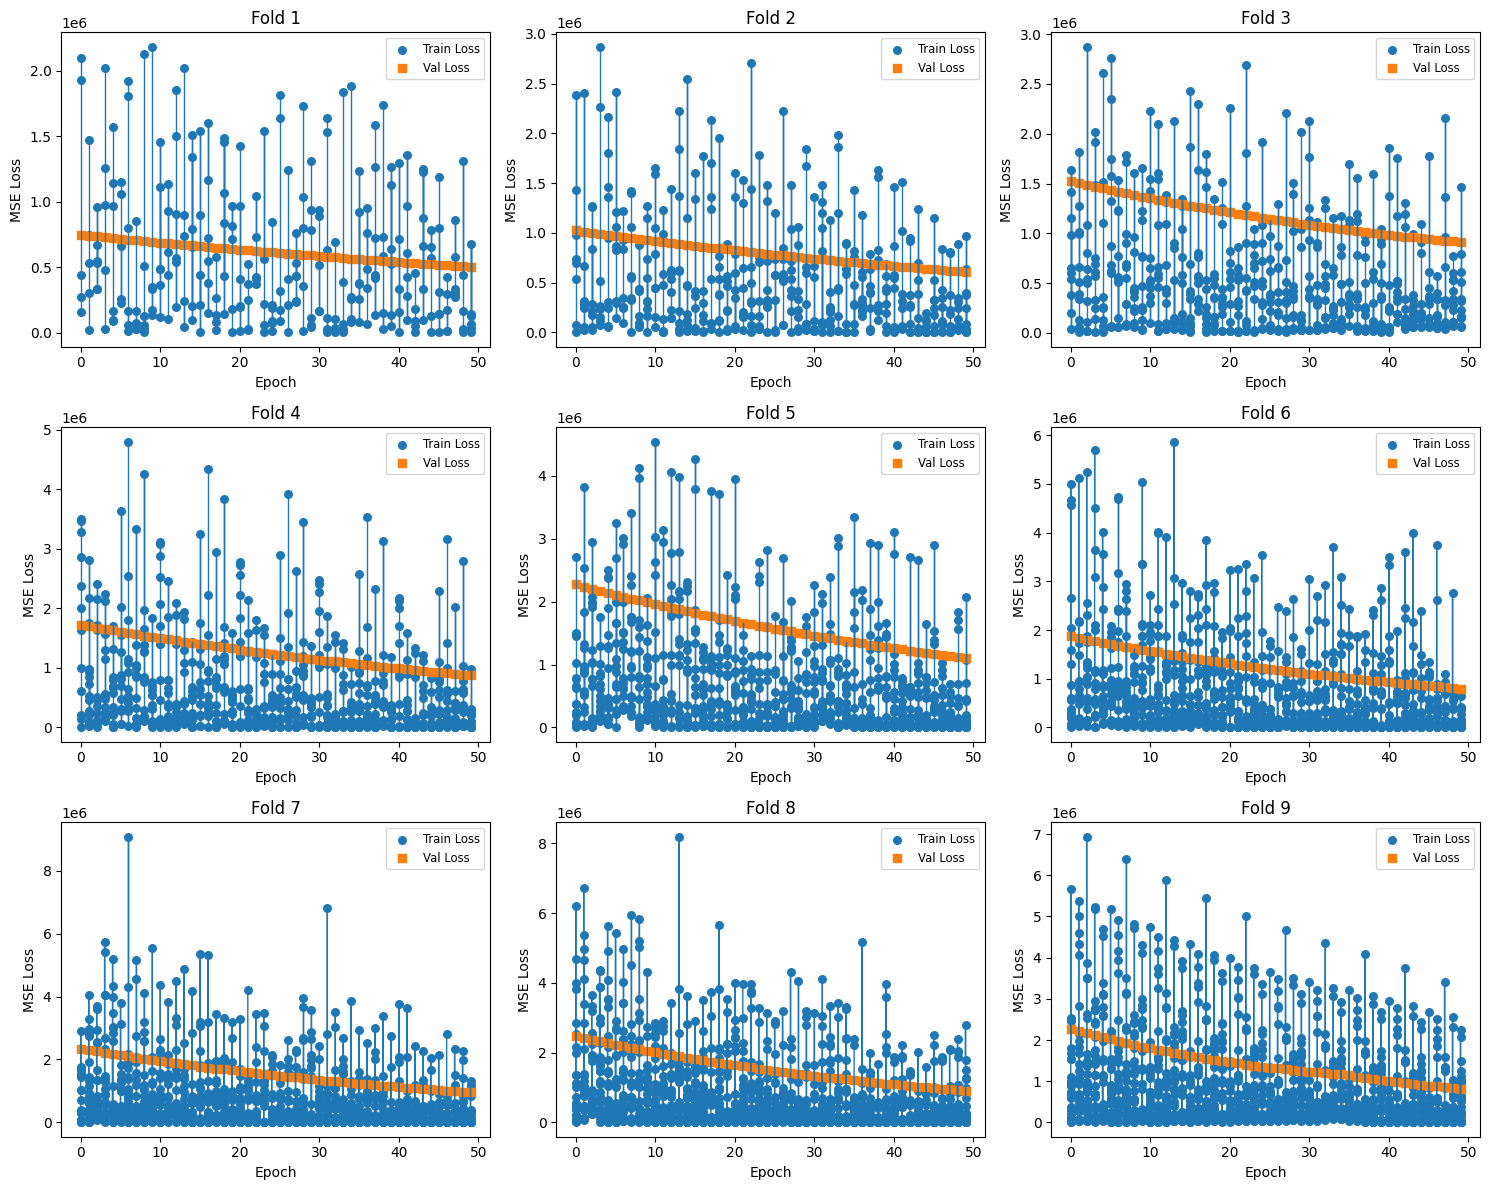

In [ ]:
# Code Cell: Grid of Scatter+Line Train vs Val Loss per Epoch for Each Fold

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

# 1) Point to your Optuna search directory where CSVLogger saved logs
SEARCH_DIR = "/mnt/d/Colab/Summer Project/Final/New Project/study/search/20250731_154655"

# 2) Find all fold‐specific metric files under both bestmodel_ and opt* directories
metrics_paths = []
metrics_paths += glob.glob(os.path.join(SEARCH_DIR, "bestmodel_fold*/version_*/metrics.csv"))
metrics_paths += glob.glob(os.path.join(SEARCH_DIR, "opt*_*_fold*/version_*/metrics.csv"))

# 3) Group by fold index (take one file per fold)
fold_logs = {}
for path in metrics_paths:
    folder = next(p for p in path.split(os.sep) if "_fold" in p)
    try:
        fold_num = int(folder.split("_fold")[-1])
    except ValueError:
        continue
    fold_logs[fold_num] = path

n_folds = len(fold_logs)
if n_folds == 0:
    print(f"No fold logs found in {SEARCH_DIR}.")
else:
    # 4) Compute grid dimensions
    cols = min(3, n_folds)
    rows = (n_folds + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), squeeze=False)

    # 5) Plot each fold with points joined by lines
    for fold_i, metrics_path in sorted(fold_logs.items()):
        df_metrics = pd.read_csv(metrics_path)
        ax = axes[(fold_i - 1) // cols][(fold_i - 1) % cols]

        # Train loss: scatter + line
        ax.scatter(df_metrics["epoch"], df_metrics["train_loss"],
                   marker='o', s=30, label="Train Loss")
        ax.plot(df_metrics["epoch"], df_metrics["train_loss"],
                linestyle='-', linewidth=1)

        # Val loss: scatter + line
        ax.scatter(df_metrics["epoch"], df_metrics["val_loss_epoch"],
                   marker='s', s=30, label="Val Loss")
        ax.plot(df_metrics["epoch"], df_metrics["val_loss_epoch"],
                linestyle='--', linewidth=1)

        ax.set_title(f"Fold {fold_i}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("MSE Loss")
        ax.legend(fontsize="small")

    # 6) Remove any unused subplots
    for idx in range(n_folds, rows * cols):
        fig.delaxes(axes[idx // cols][idx % cols])

    plt.tight_layout()
    plt.show()

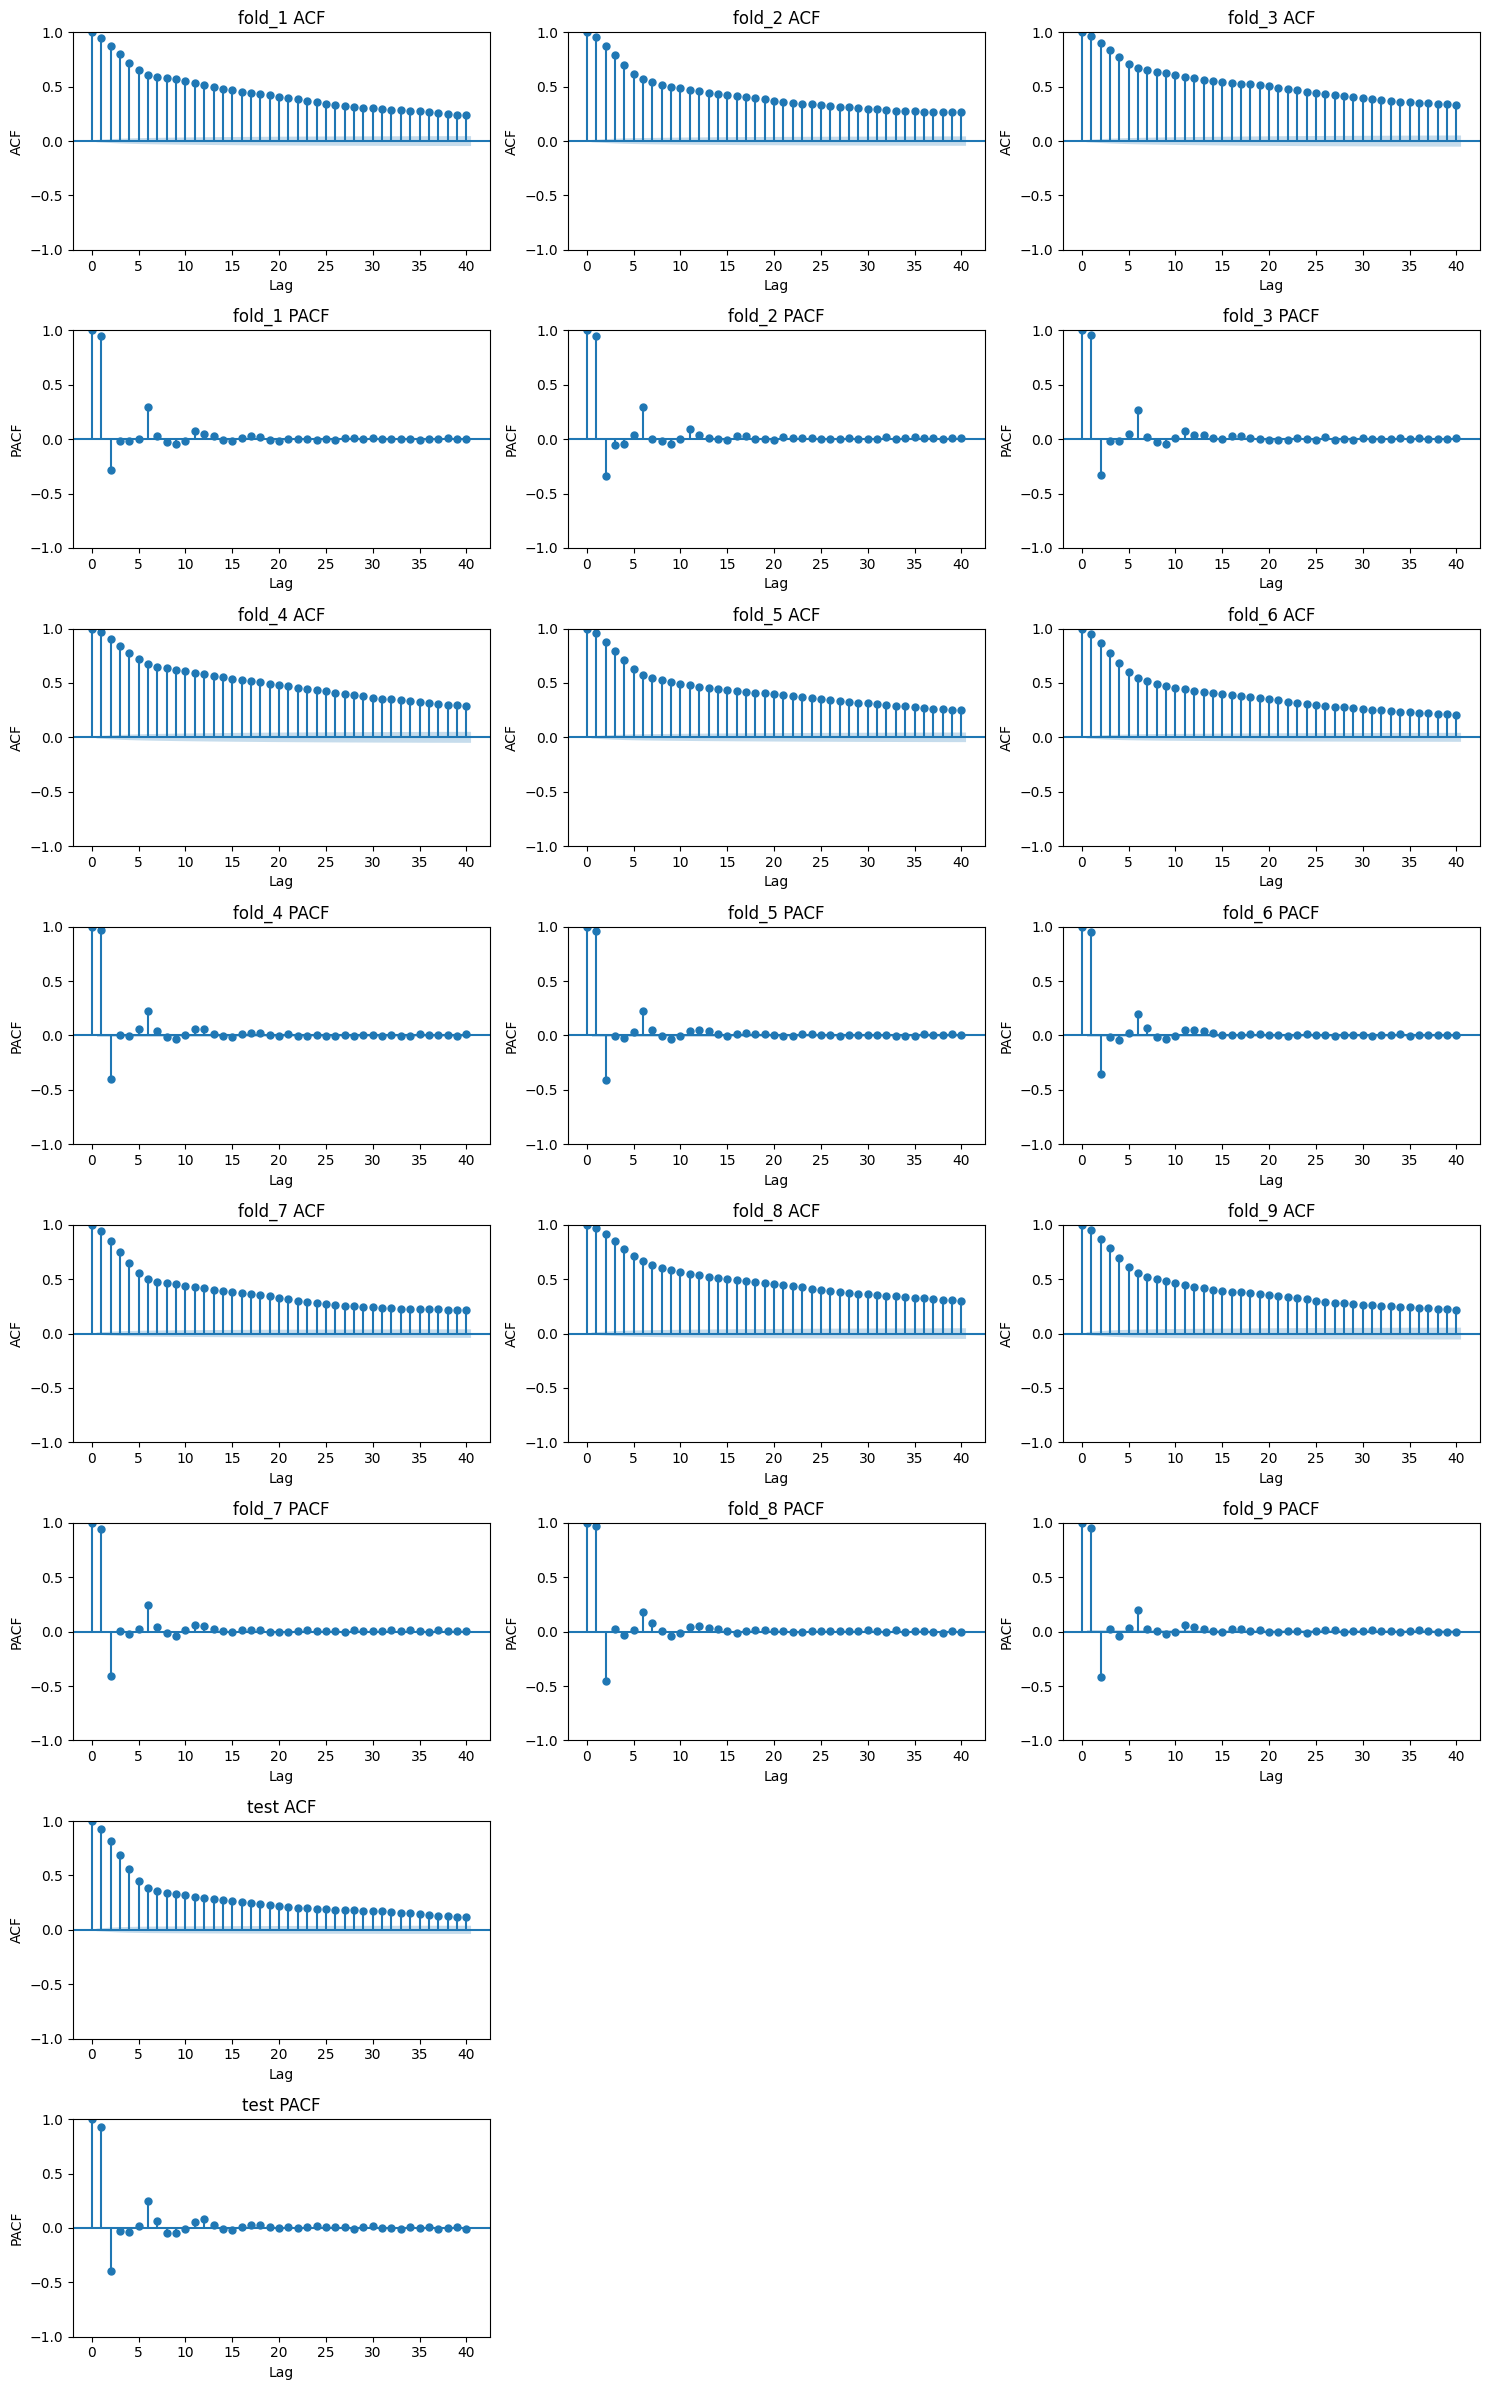

In [ ]:
# Code Cell: Compute and Plot ACF/PACF of One-Hour Residuals per Fold

import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1) Load combined results dataframe
OPTUNA_DIR = "/mnt/d/Colab/Summer Project/Final/New Project/study/optuna/20250731_154655"
results_path = os.path.join(OPTUNA_DIR, "results_df1.csv")
df = pd.read_csv(results_path, parse_dates=["timestamp"])

# 2) Filter to one-hour horizon residuals (horizon_steps=4)
#    our records correspond exactly to one-hour ahead, so we can group by 'split'
folds = sorted(df["split"].unique())

n_folds = len(folds)
cols = min(3, n_folds)
rows = (n_folds + cols - 1) // cols

fig, axes = plt.subplots(rows*2, cols, figsize=(5*cols, 3*rows*2))
axes = axes.reshape(rows, 2, cols)  # [row, (acf/pacf), col]

for idx, split in enumerate(folds):
    resid = df.loc[df["split"] == split, "residual"].dropna().values

    r = idx // cols
    c = idx % cols

    # ACF
    ax_acf = axes[r, 0, c]
    plot_acf(resid, ax=ax_acf, lags=40, title=f"{split} ACF")
    ax_acf.set_xlabel("Lag")
    ax_acf.set_ylabel("ACF")

    # PACF
    ax_pacf = axes[r, 1, c]
    plot_pacf(resid, ax=ax_pacf, lags=40, method="ywm", title=f"{split} PACF")
    ax_pacf.set_xlabel("Lag")
    ax_pacf.set_ylabel("PACF")

# Remove any empty subplots
for idx in range(n_folds, rows*cols):
    r = idx // cols
    c = idx % cols
    fig.delaxes(axes[r, 0, c])
    fig.delaxes(axes[r, 1, c])

plt.tight_layout()
plt.show()

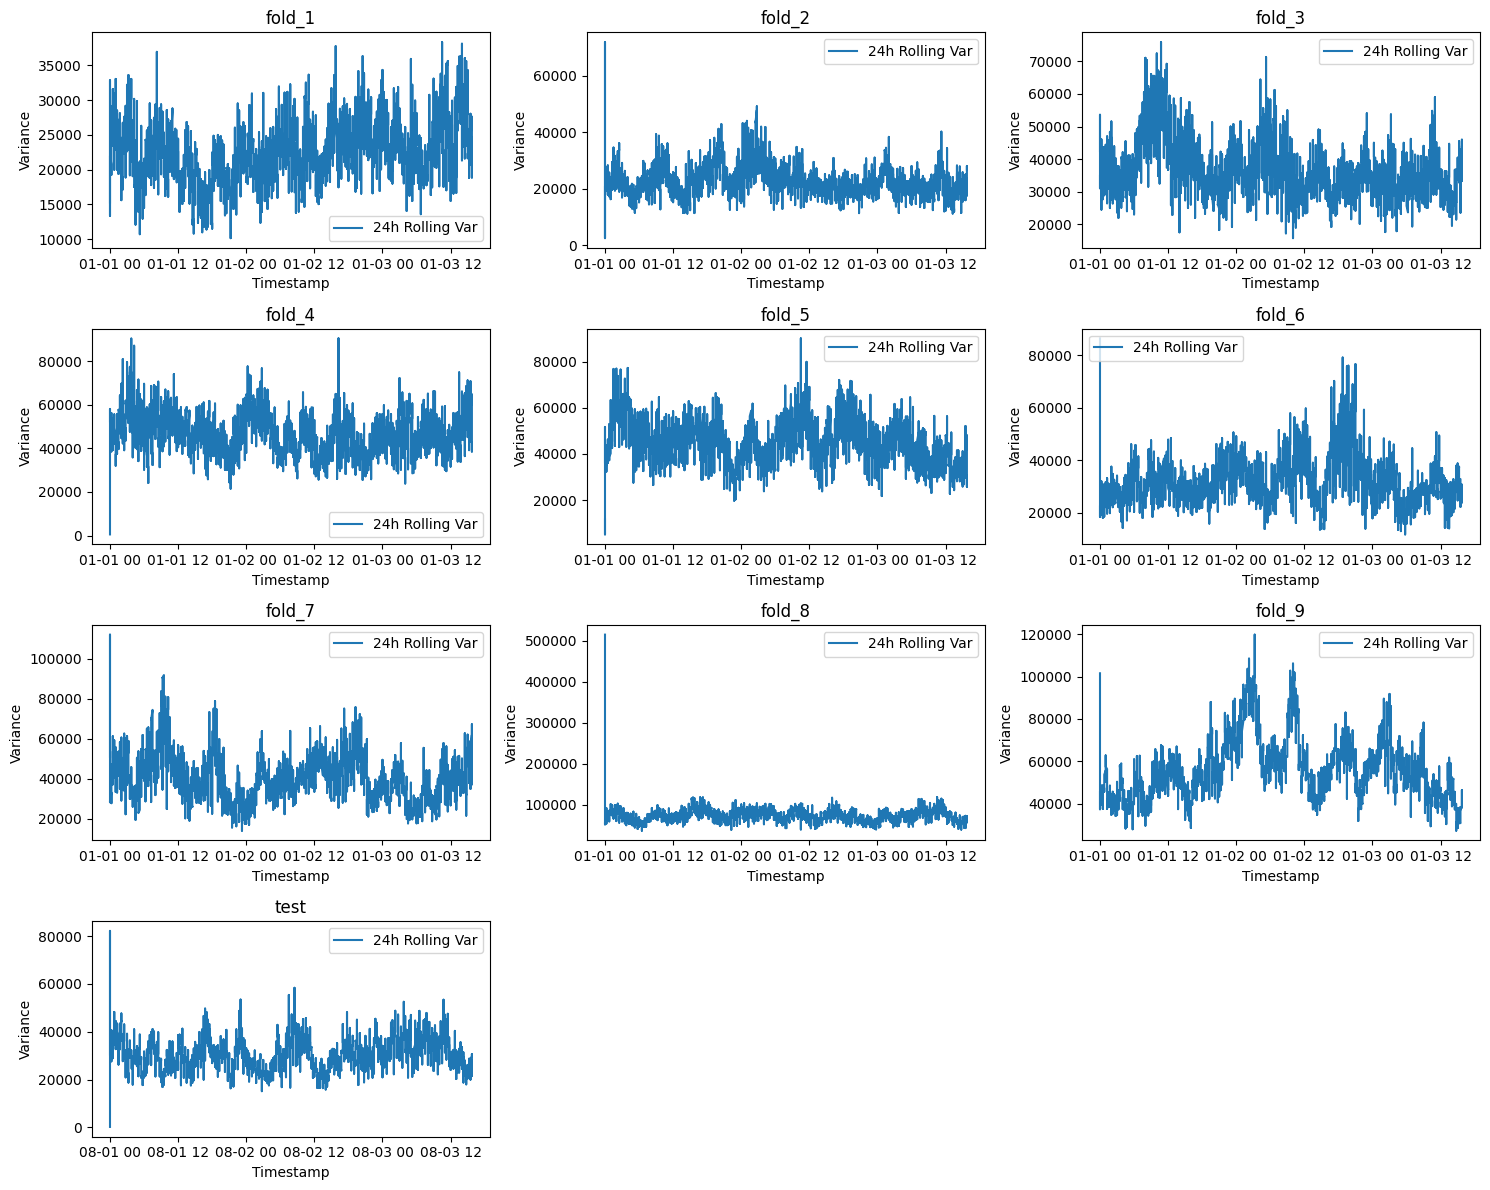

In [ ]:
# Code Cell: Plot 24-Hour Rolling Variance of Residuals per Fold

import os
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load combined results dataframe
OPTUNA_DIR = "/mnt/d/Colab/Summer Project/Final/New Project/study/optuna/20250731_154655"
results_path = os.path.join(OPTUNA_DIR, "results_df1.csv")
df = pd.read_csv(results_path, parse_dates=["timestamp"])

# 2) Prepare for rolling calculation
# assume 15-minute frequency → 24 hours = 96 periods
ROLL_WINDOW = 96

folds = sorted(df["split"].unique())
n_folds = len(folds)
cols = min(3, n_folds)
rows = (n_folds + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), squeeze=False)

for idx, split in enumerate(folds):
    ax = axes[idx // cols][idx % cols]
    sub = df[df["split"] == split].set_index("timestamp").sort_index()
    # compute rolling variance of residuals
    rolling_var = sub["residual"].rolling(window=ROLL_WINDOW, min_periods=1).var()
    ax.plot(rolling_var.index, rolling_var.values, label="24h Rolling Var")
    ax.set_title(f"{split}")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Variance")
    ax.legend()

# Remove any unused axes
for idx in range(n_folds, rows * cols):
    fig.delaxes(axes[idx // cols][idx % cols])

plt.tight_layout()
plt.show()

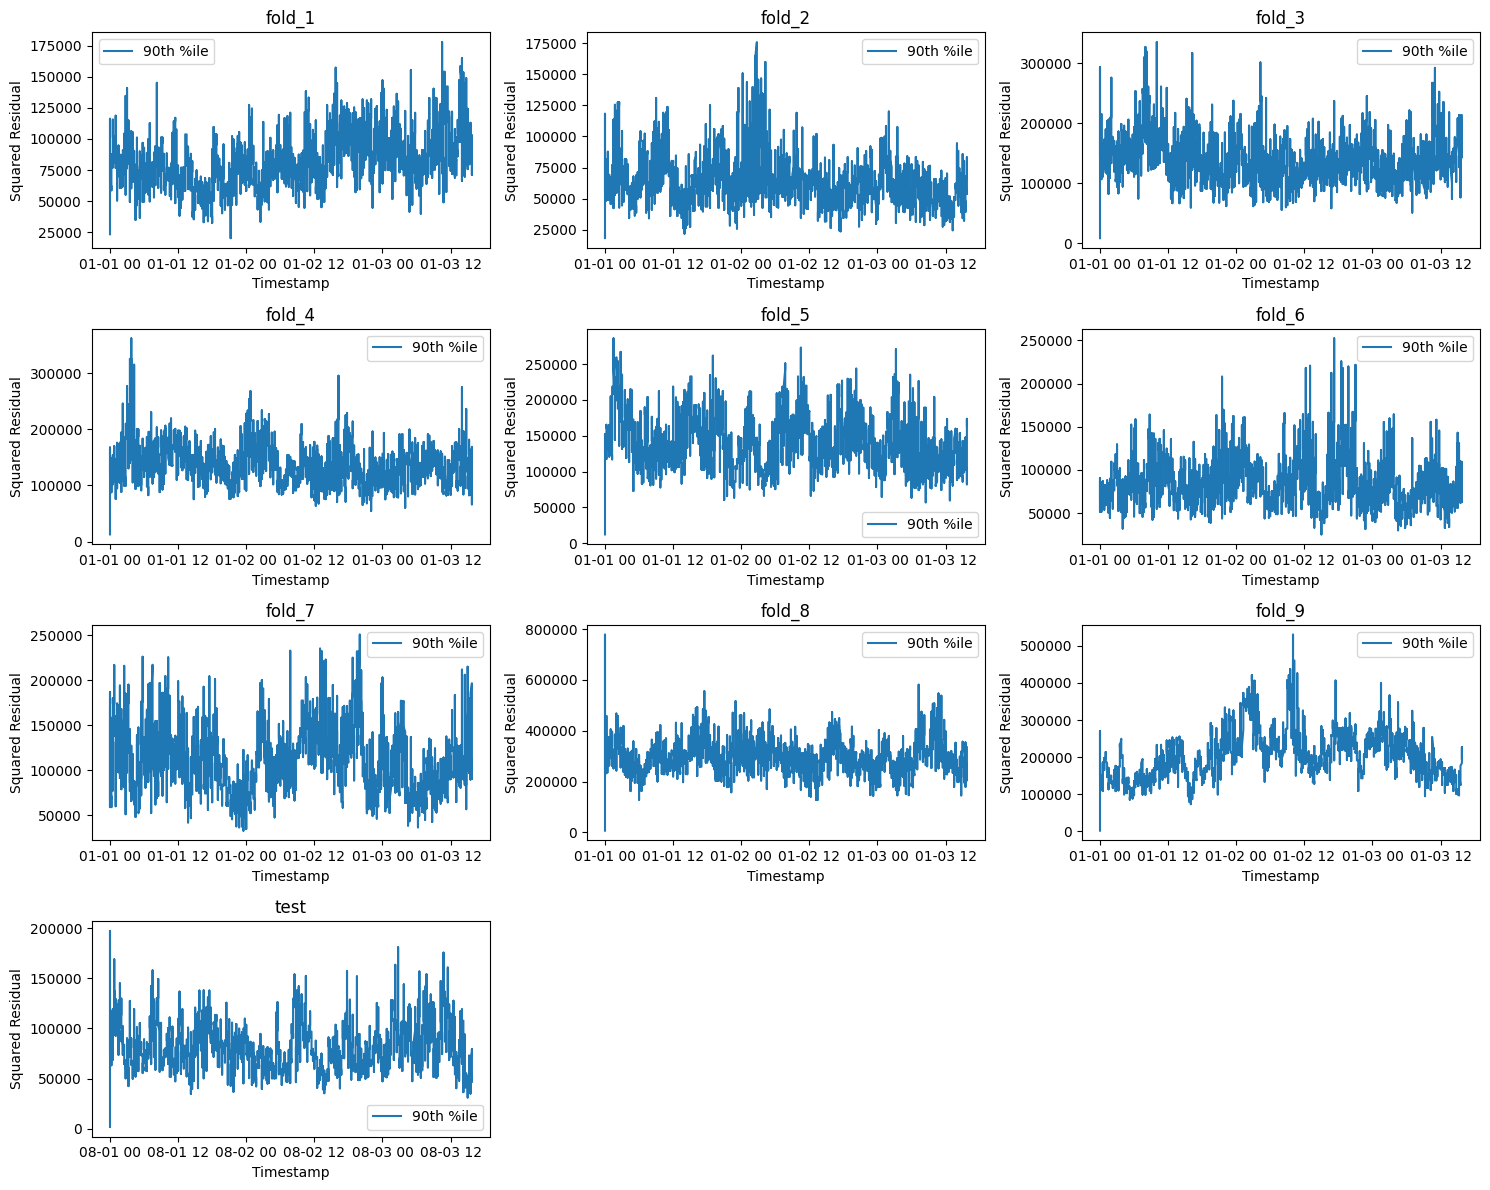

In [ ]:
# Code Cell: 24-Hour Sliding 90th-Percentile of Squared Residuals by Fold

import os
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load combined results dataframe
OPTUNA_DIR = "/mnt/d/Colab/Summer Project/Final/New Project/study/optuna/20250731_154655"
results_path = os.path.join(OPTUNA_DIR, "results_df1.csv")
df = pd.read_csv(results_path, parse_dates=["timestamp"])

# 2) Prepare for rolling calculation
# 15-minute frequency → 24 h = 96 periods
ROLL_WINDOW = 96
QUANTILE = 0.90

folds = sorted(df["split"].unique())
n_folds = len(folds)
cols = min(3, n_folds)
rows = (n_folds + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), squeeze=False)

for idx, split in enumerate(folds):
    ax = axes[idx // cols][idx % cols]
    sub = (
        df[df["split"] == split]
        .set_index("timestamp")
        .sort_index()
    )
    # squared residuals
    sq_resid = sub["residual"] ** 2
    # compute rolling 90th percentile
    roll_q = sq_resid.rolling(window=ROLL_WINDOW, min_periods=1).quantile(QUANTILE)
    ax.plot(roll_q.index, roll_q.values, label=f"{int(QUANTILE*100)}th %ile")
    ax.set_title(f"{split}")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Squared Residual")
    ax.legend()

# Remove any unused axes
for idx in range(n_folds, rows * cols):
    fig.delaxes(axes[idx // cols][idx % cols])

plt.tight_layout()
plt.show()

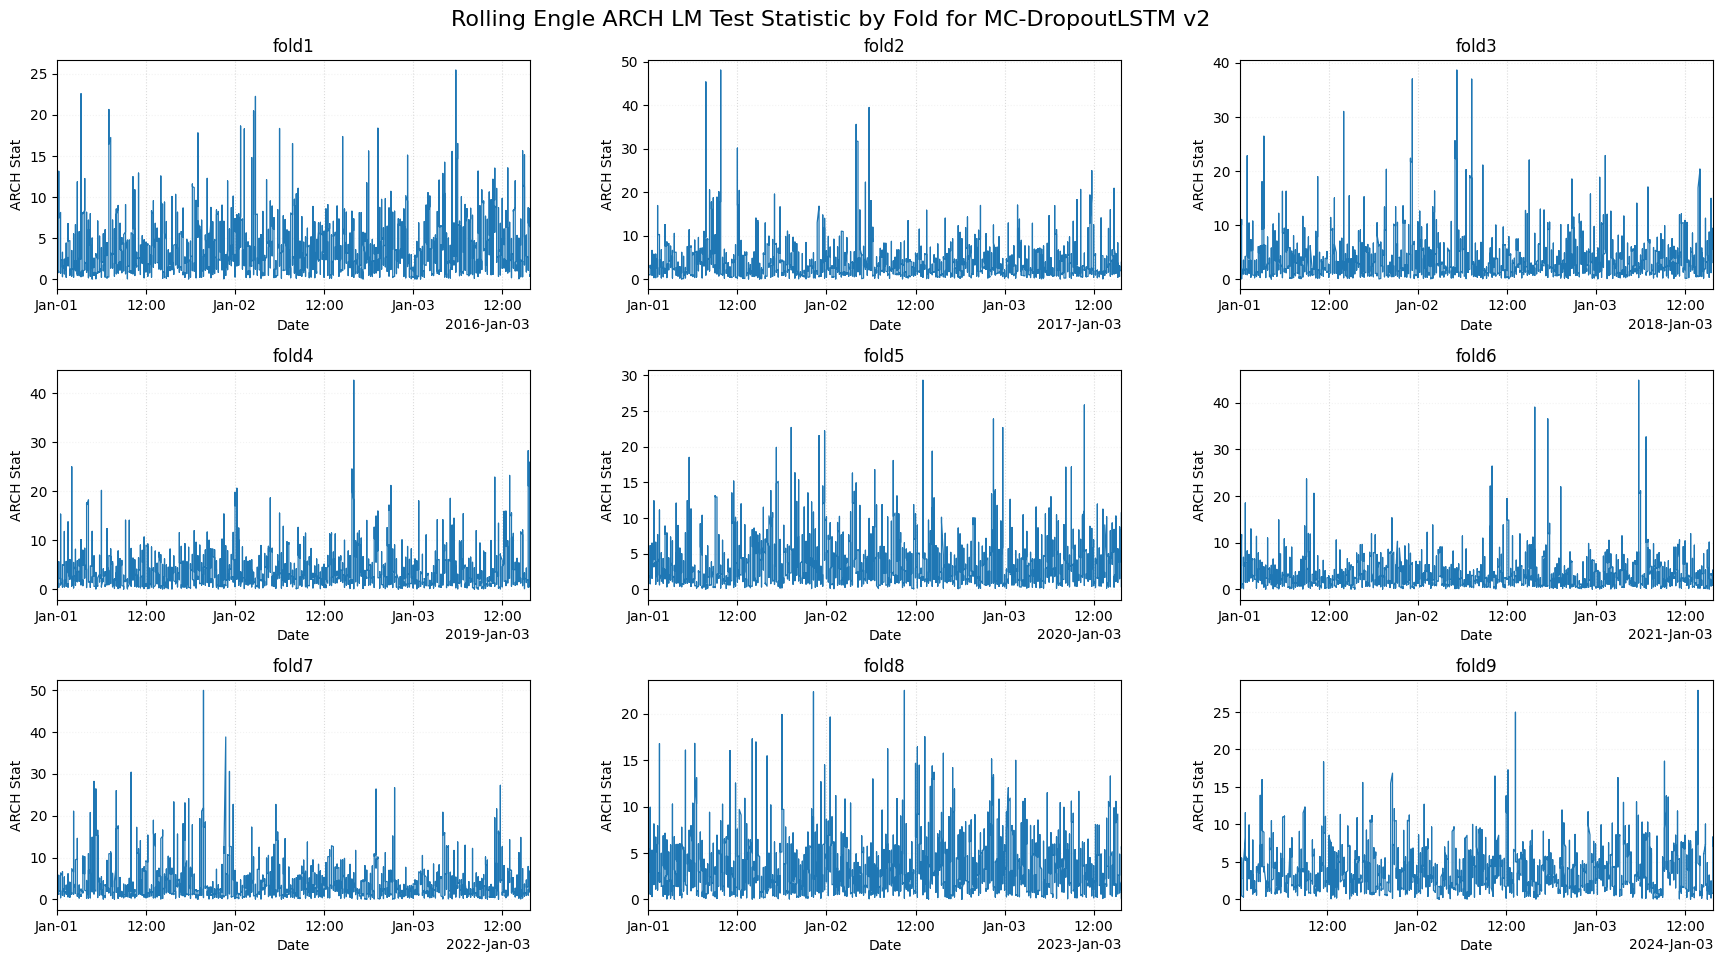

In [ ]:
# Code Cell: Rolling Engle’s ARCH Test Statistic by Fold
# Each subplot gets its OWN x- and y-axes computed from that fold’s data
# (independent limits + readable YYYY-MM ticks)

import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.stats.diagnostic import het_arch
import numpy as np

# 1) Load combined results dataframe
OPTUNA_DIR = "/mnt/d/Colab/Summer Project/Final/New Project/study/optuna/20250731_154655"
results_path = os.path.join(OPTUNA_DIR, "results_df1.csv")
df = pd.read_csv(results_path, parse_dates=["timestamp"])

# 2) Rolling parameters
ROLL_WINDOW = 96   # 24 h of 15-min steps
LAGS        = 4

# Use only CV folds (exclude 'test') and sort by fold number
folds = sorted([s for s in df["split"].unique() if s.startswith("fold_")],
               key=lambda x: int(x.split("_")[-1]))

n_folds = len(folds)
cols = 3
rows = (n_folds + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 10), squeeze=False)
fig.suptitle("Rolling Engle ARCH LM Test Statistic by Fold for MC-DropoutLSTM v2", fontsize=16, y=0.98)

for idx, split in enumerate(folds):
    ax = axes[idx // cols][idx % cols]

    sub = (
        df[df["split"] == split]
        .set_index("timestamp")
        .sort_index()
    )

    resid = sub["residual"]

    # Rolling Engle ARCH statistic for this fold
    arch_stats = resid.rolling(window=ROLL_WINDOW, min_periods=ROLL_WINDOW).apply(
        lambda x: het_arch(x, nlags=LAGS)[0],
        raw=False
    )

    # Drop NaNs created by the rolling window
    valid = arch_stats.dropna()

    # Plot (if there is data)
    if not valid.empty:
        ax.plot(valid.index, valid.values, linewidth=0.9)

        # --- INDEPENDENT AXES PER SUBPLOT ---
        # X-axis limits from this fold’s data only
        x0, x1 = valid.index.min(), valid.index.max()
        ax.set_xlim(x0, x1)

        # Y-axis limits from this fold’s data only (with a small padding)
        y0, y1 = float(np.nanmin(valid.values)), float(np.nanmax(valid.values))
        if np.isfinite(y0) and np.isfinite(y1):
            pad = 0.05 * (y1 - y0) if y1 > y0 else 1.0
            ax.set_ylim(y0 - pad, y1 + pad)

        # Date ticks: auto + concise formatter to show YYYY-MM nicely
        locator = mdates.AutoDateLocator(minticks=5, maxticks=8)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

        # Light grid for readability
        ax.grid(True, axis='x', linestyle=':', alpha=0.45)
        ax.grid(True, axis='y', linestyle=':', alpha=0.15)
    else:
        ax.text(0.5, 0.5, "No rolling data", ha='center', va='center', transform=ax.transAxes)
        ax.set_xlim(sub.index.min(), sub.index.max())

    ax.set_title(split.replace("fold_", "fold"), pad=6)
    ax.set_xlabel("Date")
    ax.set_ylabel("ARCH Stat")
    ax.tick_params(axis='x', labelrotation=0)

# Remove any unused axes
for idx in range(n_folds, rows * cols):
    fig.delaxes(axes[idx // cols][idx % cols])

plt.subplots_adjust(left=0.07, right=0.99, top=0.93, bottom=0.08, wspace=0.25, hspace=0.35)
plt.show()

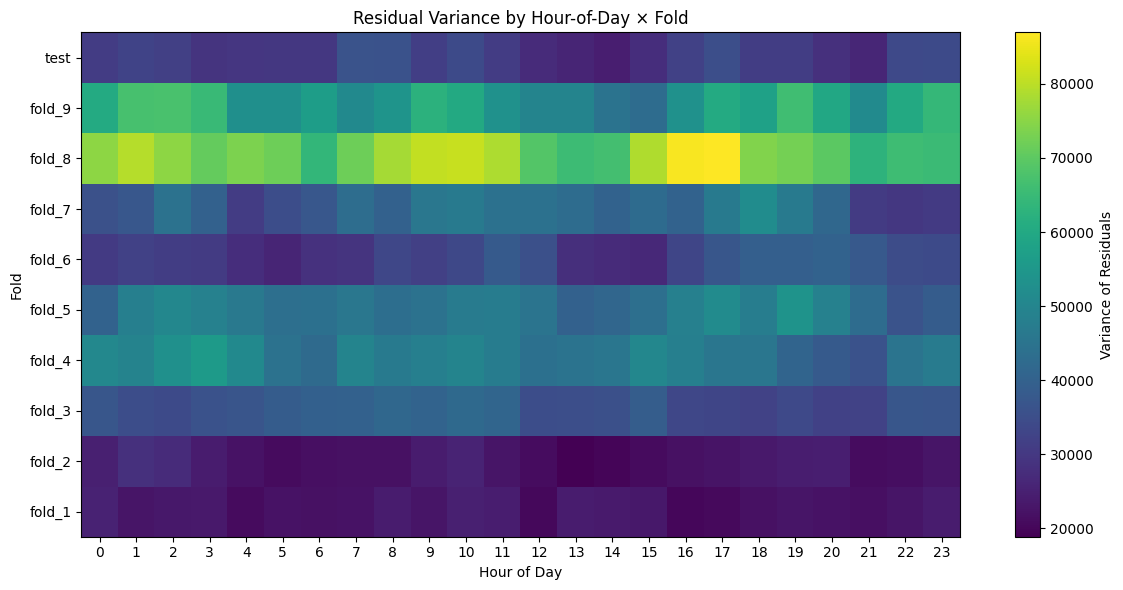

In [ ]:
# Code Cell: Heatmap of Residual-Variance by Hour-of-Day × Fold

import os
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load combined results dataframe
OPTUNA_DIR = "/mnt/d/Colab/Summer Project/Final/New Project/study/optuna/20250731_154655"
df = pd.read_csv(os.path.join(OPTUNA_DIR, "results_df1.csv"), parse_dates=["timestamp"])

# 2) Extract hour and compute variance of residuals by fold and hour
df["hour"] = df["timestamp"].dt.hour
pivot = (
    df
    .groupby(["split", "hour"])["residual"]
    .var()
    .unstack(level="hour")
    .fillna(0)
)

# 3) Plot heatmap
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(pivot.values, aspect="auto", origin="lower")

# 4) Configure axes
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Fold")
ax.set_title("Residual Variance by Hour-of-Day × Fold")

# 5) Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Variance of Residuals")

plt.tight_layout()
plt.show()

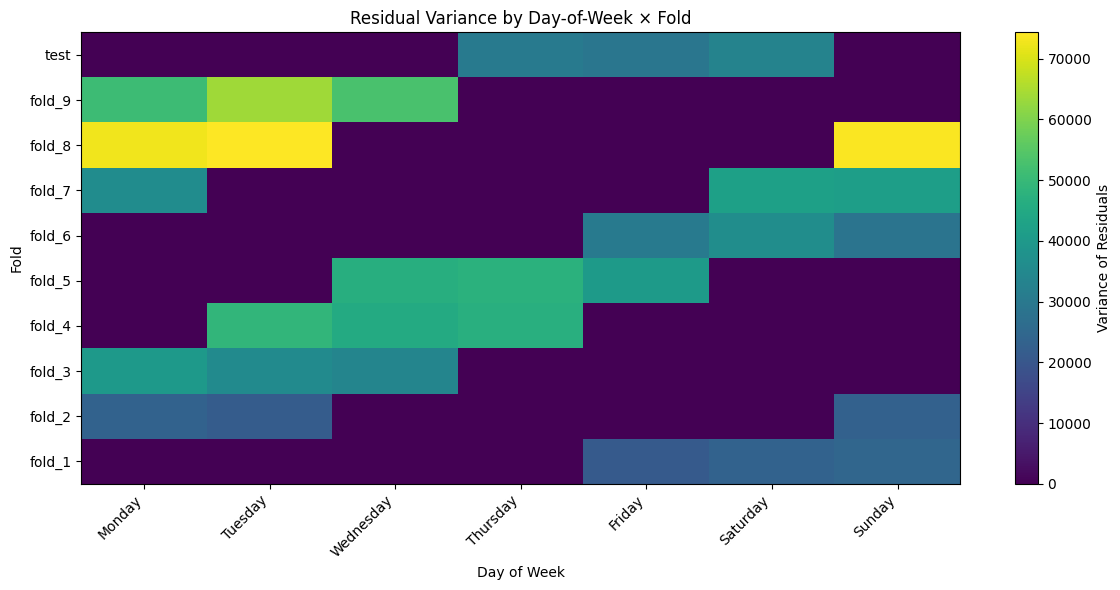

In [ ]:
# Code Cell: Heatmap of Residual-Variance by Day-of-Week × Fold

import os
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load combined results dataframe
OPTUNA_DIR = "/mnt/d/Colab/Summer Project/Final/New Project/study/optuna/20250731_154655"
df = pd.read_csv(os.path.join(OPTUNA_DIR, "results_df1.csv"), parse_dates=["timestamp"])

# 2) Extract day of week and compute variance of residuals by fold and day
df["day_of_week"] = df["timestamp"].dt.day_name()
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pivot = (
    df
    .groupby(["split", "day_of_week"])["residual"]
    .var()
    .unstack(level="day_of_week")
    .reindex(columns=order)
    .fillna(0)
)

# 3) Plot heatmap
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(pivot.values, aspect="auto", origin="lower")

# 4) Configure axes
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xticks(range(len(order)))
ax.set_xticklabels(order, rotation=45, ha="right")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Fold")
ax.set_title("Residual Variance by Day-of-Week × Fold")

# 5) Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Variance of Residuals")

plt.tight_layout()
plt.show()


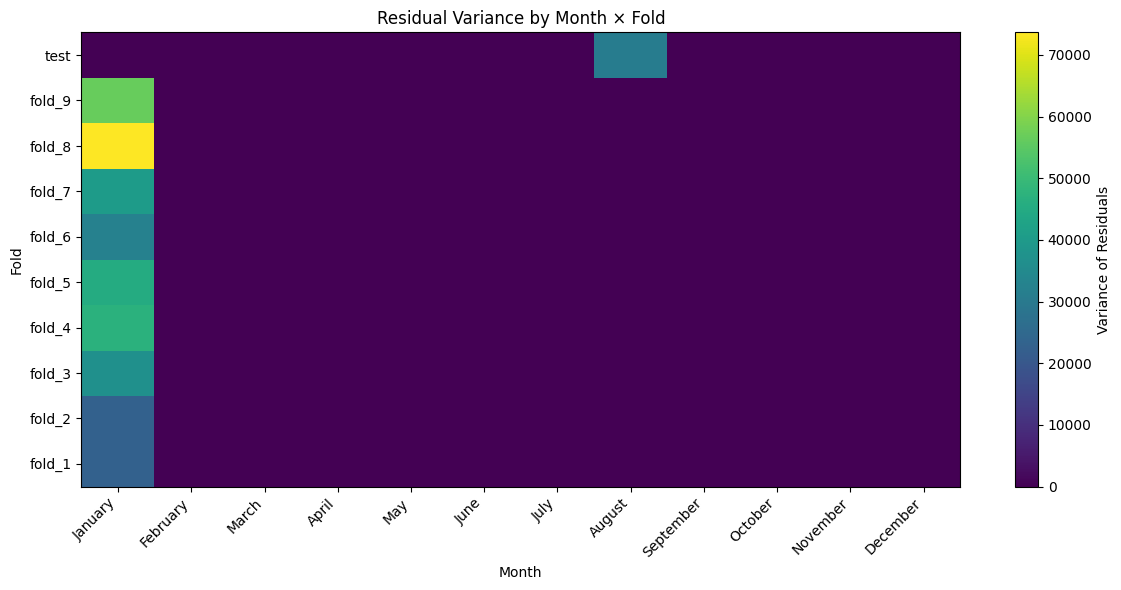

In [ ]:
# Code Cell: Heatmap of Residual-Variance by Month × Fold

import os
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load combined results dataframe
OPTUNA_DIR = "/mnt/d/Colab/Summer Project/Final/New Project/study/optuna/20250731_154655"
results_df = pd.read_csv(os.path.join(OPTUNA_DIR, "results_df1.csv"), parse_dates=["timestamp"])

# 2) Extract month and compute variance of residuals by fold and month
results_df["month"] = results_df["timestamp"].dt.month_name()
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
pivot = (
    results_df
    .groupby(["split", "month"])["residual"]
    .var()
    .unstack(level="month")
    .reindex(columns=month_order)
    .fillna(0)
)

# 3) Plot heatmap
fig, ax = plt.subplots(figsize=(12, 6))
cax = ax.imshow(pivot.values, aspect="auto", origin="lower")

# 4) Configure axes
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xticks(range(len(month_order)))
ax.set_xticklabels(month_order, rotation=45, ha="right")
ax.set_xlabel("Month")
ax.set_ylabel("Fold")
ax.set_title("Residual Variance by Month × Fold")

# 5) Add colorbar
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label("Variance of Residuals")

plt.tight_layout()
plt.show()


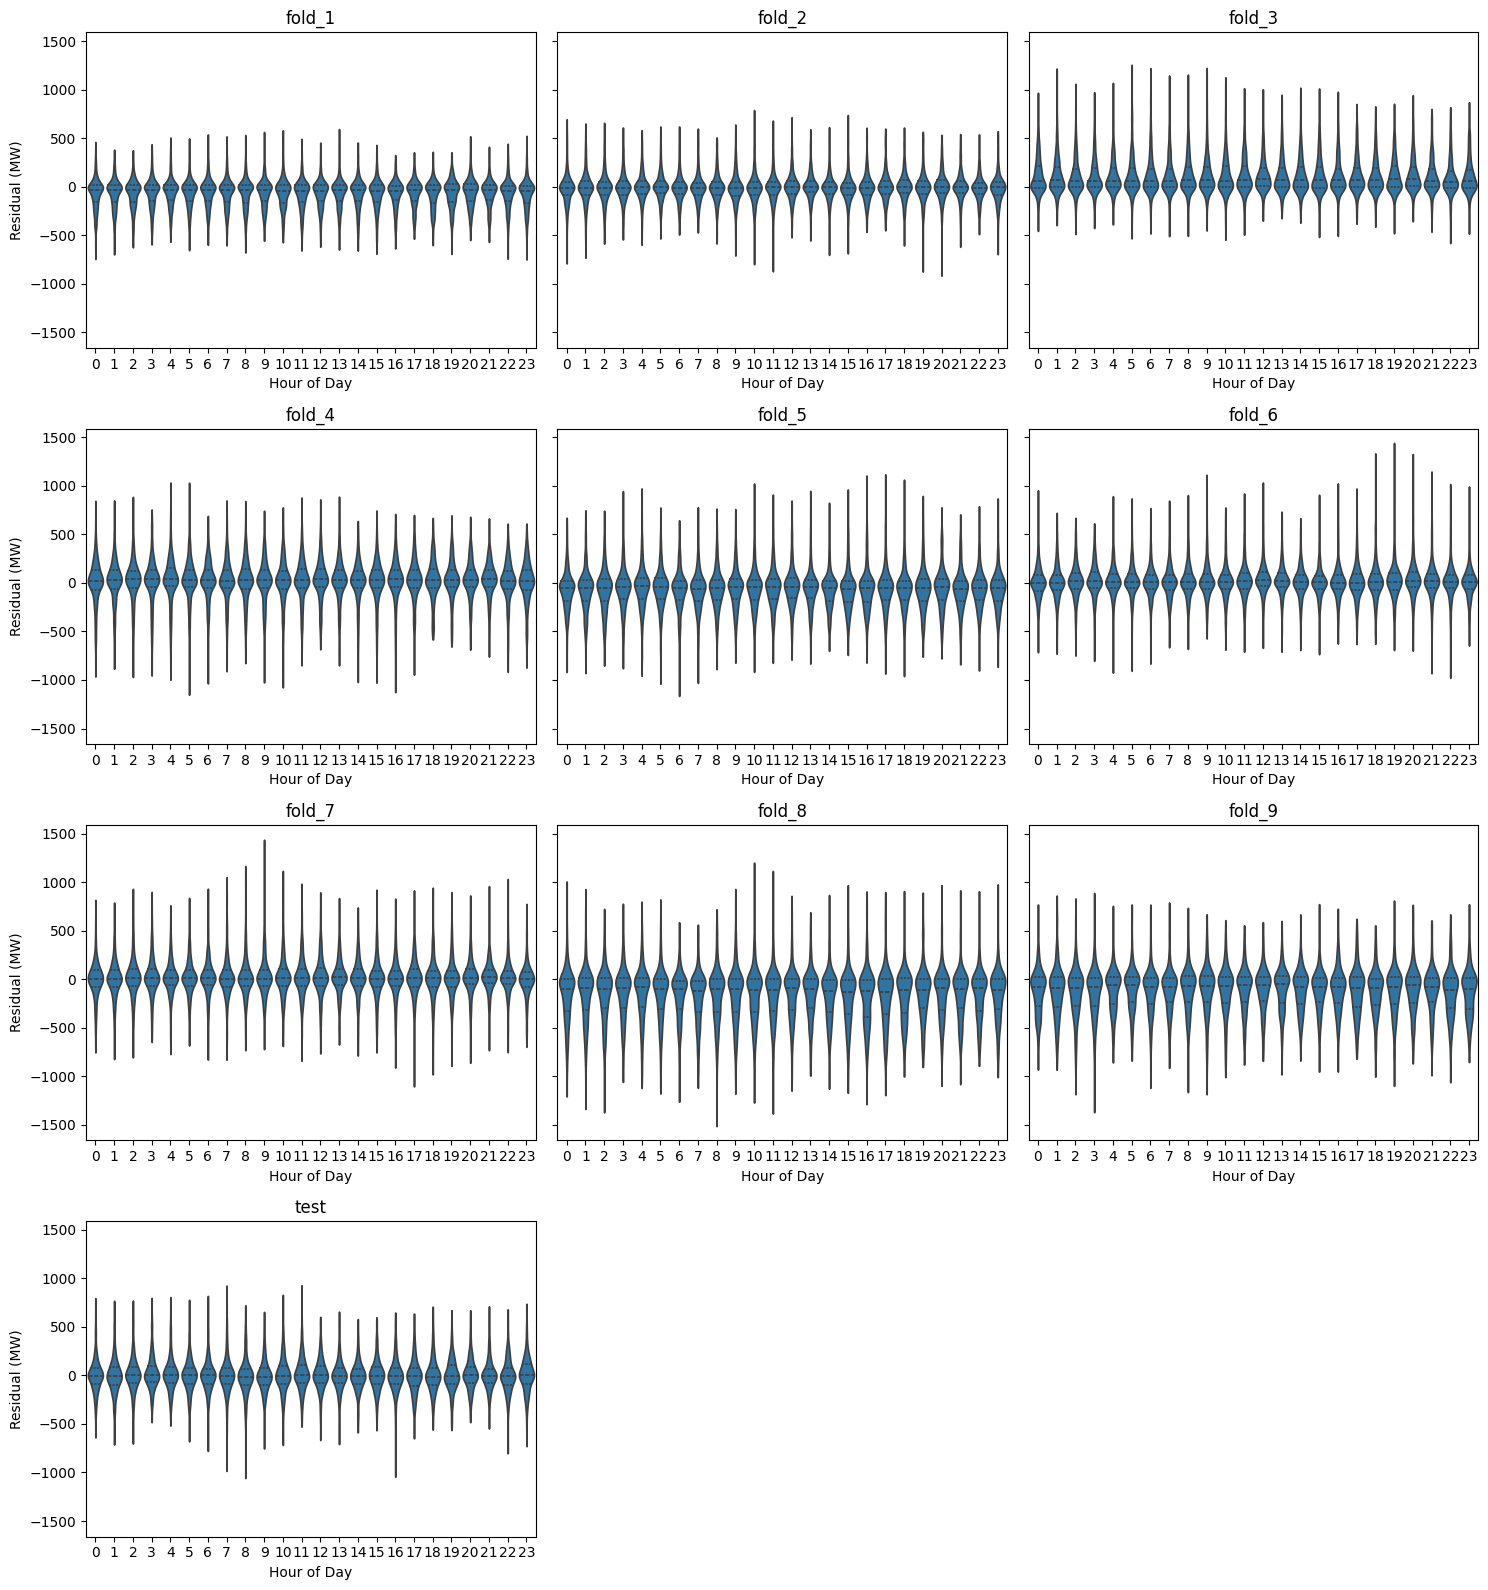

In [ ]:
# Code Cell: Error Distribution by Time-of-Day

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 0) Load results_df1 from disk
CSV_PATH = "/mnt/d/Colab/Summer Project/Final/New Project/study/optuna/20250731_154655/results_df1.csv"
results_df1 = pd.read_csv(CSV_PATH, parse_dates=["timestamp"])

# 1) Extract hour of day
results_df1["hour"] = results_df1["timestamp"].dt.hour

# 2) Prepare plotting grid
folds = sorted(results_df1["split"].unique())
n_folds = len(folds)
cols = 3
rows = (n_folds + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharey=True)
axes = axes.flatten()

# 3) Plot a violin for each fold, using density_norm instead of scale
for ax, fold in zip(axes, folds):
    df_fold = results_df1[results_df1["split"] == fold]
    sns.violinplot(
        x="hour",
        y="residual",
        data=df_fold,
        inner="quartile",
        ax=ax,
        density_norm='width',  # replaced scale='width'
        cut=0
    )
    ax.set_title(f"{fold}")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Residual (MW)")

# 4) Remove unused axes
for ax in axes[len(folds):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

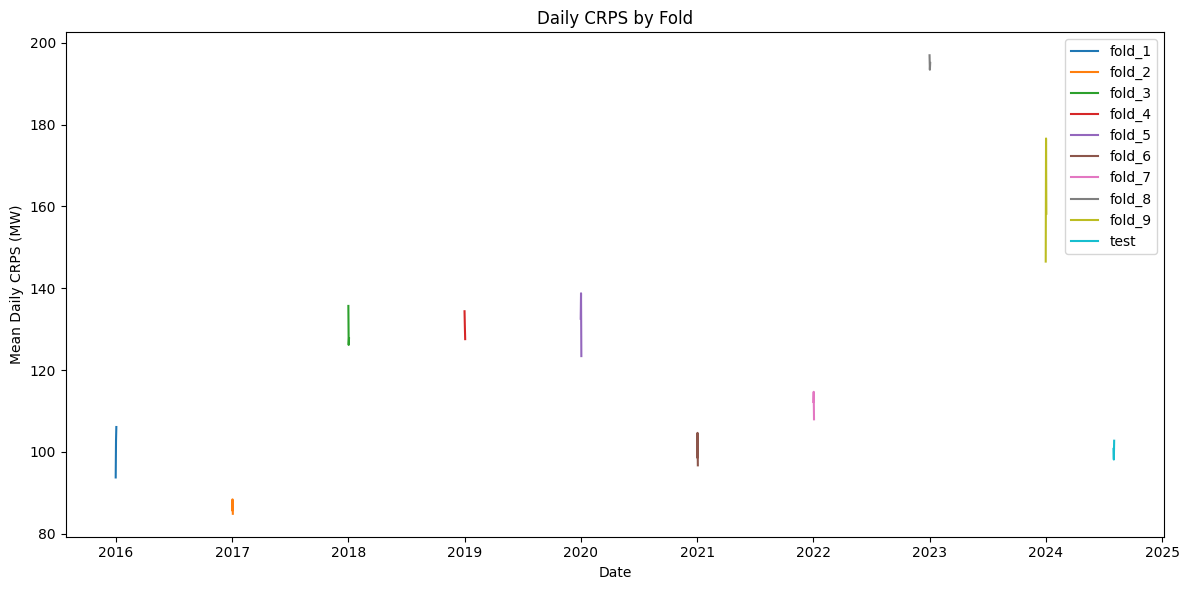

In [ ]:
# Code Cell: CRPS by Fold

import pandas as pd
import matplotlib.pyplot as plt
from properscoring import crps_gaussian

# 0) Load results_df1
CSV_PATH = "/mnt/d/Colab/Summer Project/Final/New Project/study/optuna/20250731_154655/results_df1.csv"
df = pd.read_csv(CSV_PATH, parse_dates=["timestamp"])

# 1) Compute CRPS per record (assume Gaussian predictive distribution)
df["crps"] = crps_gaussian(df["y_true"], df["y_pred_mean"], df["uncertainty"])

# 2) Aggregate CRPS over time by fold (e.g. daily average)
df["date"] = df["timestamp"].dt.date
crps_by_date = df.groupby(["split", "date"])["crps"].mean().reset_index()

# 3) Plot one line per fold
folds = crps_by_date["split"].unique()
plt.figure(figsize=(12, 6))
for fold in folds:
    sub = crps_by_date[crps_by_date["split"] == fold]
    plt.plot(sub["date"], sub["crps"], label=fold)
plt.xlabel("Date")
plt.ylabel("Mean Daily CRPS (MW)")
plt.title("Daily CRPS by Fold")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Code Cell: New CV folds & test split for “2019-01-01” → “2025-04-30”
import pandas as pd
from pandas.tseries.offsets import DateOffset

# 1) Define your window
window_start = pd.Timestamp("2019-01-01 00:00:00")
window_end   = pd.Timestamp("2025-04-30 00:00:00")
cv_end       = pd.Timestamp("2024-08-01 00:00:00")   # end of CV, start of final test

# 2) Reuse your frequency parameters
val_horizon   = DateOffset(years=1)
step          = pd.Timedelta(minutes=15)
horizon       = 4 * step
horizon_steps = int(horizon / step)  # = 4
seq_len       = 96                   # 1-day lookback

# 3) Build growing-train, rolling-1yr-val folds inside [window_start, cv_end)
folds_v2 = []
train_start_v2 = window_start
train_end_v2   = train_start_v2 + DateOffset(years=2) - step

while True:
    val_start_v2      = train_end_v2 + step
    tentative_end_v2  = val_start_v2 + val_horizon - step
    val_end_v2        = min(tentative_end_v2, cv_end - step)
    folds_v2.append({
        "train_start": train_start_v2,
        "train_end":   train_end_v2,
        "val_start":   val_start_v2,
        "val_end":     val_end_v2
    })
    if val_end_v2 >= cv_end - step:
        break
    train_end_v2 = val_end_v2

# 4) Convert to timestamp splits and filter edges
splits_v2 = []
min_ts, max_ts = df_sub.index.min(), df_sub.index.max()

for f in folds_v2:
    idx_tr = df_sub.loc[f["train_start"]:f["train_end"]].index
    idx_val= df_sub.loc[f["val_start"]:f["val_end"]].index

    tr_v2 = [
        t for t in idx_tr
        if (t - seq_len*step) >= min_ts and (t + horizon) <= max_ts
    ]
    vl_v2 = [
        t for t in idx_val
        if (t - seq_len*step) >= min_ts and (t + horizon) <= max_ts
    ]
    splits_v2.append((pd.DatetimeIndex(tr_v2), pd.DatetimeIndex(vl_v2)))

# 5) Map timestamp splits to integer positions
splits_v2_pos = [
    (df_sub.index.get_indexer(tr), df_sub.index.get_indexer(vl))
    for tr, vl in splits_v2
]

# 6) Define final test timestamps & positions
test_ts_v2  = df_sub.loc[cv_end:window_end].index
test_pos_v2 = df_sub.index.get_indexer(test_ts_v2)

# 7) Report
print(f"Generated {len(splits_v2)} CV folds between {window_start.date()} and {cv_end.date()}")
print(f"Final test window from {cv_end.date()} to {window_end.date()}: {len(test_ts_v2)} samples")

Generated 4 CV folds between 2019-01-01 and 2024-08-01
Final test window from 2024-08-01 to 2025-04-30: 26113 samples


In [ ]:
# Code Cell a: MC-Dropout LSTM v2 CV Evaluation (new window, larger batches + mixed precision)
import numpy as np
import torch
from torch.utils.data import DataLoader, BatchSampler, SequentialSampler
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

# precompute quantiles
z80, z95 = norm.ppf(0.90), norm.ppf(0.975)

cv_rmses = []
cv_cov80 = []
cv_cov95 = []

for fold_i, (train_pos, val_pos) in enumerate(splits_v2_pos, start=1):
    # build datasets
    train_ds = HDF5WindowDatasetv2(H5_PATH_SUB, train_pos, SEQ_LEN, HORIZON, TARGET_COL)
    val_ds   = HDF5WindowDatasetv2(H5_PATH_SUB, val_pos,   SEQ_LEN, HORIZON, TARGET_COL)

    # loaders with bigger batches and persistent workers
    train_loader = DataLoader(
        train_ds,
        batch_sampler=BatchSampler(SequentialSampler(train_ds),
                                   batch_size=1024,  # ↑ increased
                                   drop_last=False),
        collate_fn=pad_collate,
        num_workers=8,
        pin_memory=True,
        persistent_workers=True
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=1024,  # ↑ increased
        shuffle=False,
        collate_fn=pad_collate,
        num_workers=8,
        pin_memory=True,
        persistent_workers=True
    )

    # init & train with mixed precision
    model = MCDropoutLSTMv2(
        input_size=len(common_top20),
        hidden_size=best_params["hidden_size"],
        num_layers=best_params["num_layers"],
        dropout=best_params["dropout_rate"],
        lr=best_params["learning_rate"]
    )
    model.hparams.weight_decay = best_params["weight_decay"]
    if best_params["lr_scheduler"] == "step":
        model.lr_scheduler, model.lr_scheduler_params = (
            torch.optim.lr_scheduler.StepLR, {"step_size": 10, "gamma": 0.1}
        )
    elif best_params["lr_scheduler"] == "cosine":
        model.lr_scheduler, model.lr_scheduler_params = (
            torch.optim.lr_scheduler.CosineAnnealingLR, {"T_max": 50}
        )

    trainer = pl.Trainer(
        max_epochs=50,
        accelerator="gpu",
        devices=1,
        precision=32,               # mixed-precision
        enable_checkpointing=False,
        enable_progress_bar=False
    )
    trainer.fit(model, train_loader)

    # MC-dropout inference on validation
    model.eval()
    means_list, stds_list, true_list = [], [], []
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(model.device)
            mean_pred, std_pred = mc_dropout_predict(model, Xb, n_samples=50)
            means_list.append(mean_pred)
            stds_list.append(std_pred)
            true_list.append(yb.numpy())

    means = np.concatenate(means_list)
    stds  = np.concatenate(stds_list)
    trues = np.concatenate(true_list)

    # metrics
    rmse  = np.sqrt(mean_squared_error(trues, means))
    cov80 = np.mean(np.abs(trues - means) <= z80 * stds)
    cov95 = np.mean(np.abs(trues - means) <= z95 * stds)

    cv_rmses.append(rmse)
    cv_cov80.append(cov80)
    cv_cov95.append(cov95)
    print(f"Fold {fold_i} → RMSE={rmse:.3f}, Cov80={cov80:.3f}, Cov95={cov95:.3f}")

# aggregate CV metrics
CV_RMSE_μ = np.mean(cv_rmses)
CV_RMSE_σ = np.std(cv_rmses)
CV_Cov80  = np.mean(cv_cov80)
CV_Cov95  = np.mean(cv_cov95)

print(f"\nMC-Dropout LSTM v2 CV → RMSE: {CV_RMSE_μ:.3f} ± {CV_RMSE_σ:.3f}")
print(f"Coverage 80%: {CV_Cov80:.3f}, 95%: {CV_Cov95:.3f}")

In [ ]:
# Code Cell b: MC-Dropout LSTM v2 Test Evaluation (new window, with out-of-range filtering)
import numpy as np
import torch
from torch.utils.data import DataLoader, BatchSampler, SequentialSampler
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

# precompute quantiles
z80, z95 = norm.ppf(0.90), norm.ppf(0.975)

# 1) Build final train+val positions
all_train_pos = np.unique(
    np.concatenate([t for t, _ in splits_v2_pos] + [v for _, v in splits_v2_pos])
)

# 2) Filter test positions to avoid overrunning the HDF5 target array
max_pos = len(df_sub)
valid_test_pos_v2 = test_pos_v2[test_pos_v2 + HORIZON < max_pos]

# 3) Create datasets
train_ds = HDF5WindowDatasetv2(
    h5_path       = H5_PATH_SUB,
    indices       = all_train_pos,
    seq_len       = SEQ_LEN,
    horizon_steps = HORIZON,
    target_col_name=TARGET_COL
)
test_ds = HDF5WindowDatasetv2(
    h5_path       = H5_PATH_SUB,
    indices       = valid_test_pos_v2,
    seq_len       = SEQ_LEN,
    horizon_steps = HORIZON,
    target_col_name=TARGET_COL
)

# 4) DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_sampler=BatchSampler(SequentialSampler(train_ds), batch_size=256, drop_last=False),
    collate_fn=pad_collate,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_ds,
    batch_size=256,
    shuffle=False,
    collate_fn=pad_collate,
    num_workers=4,
    pin_memory=True
)

# 5) Instantiate & retrain on full CV range
model = MCDropoutLSTMv2(
    input_size=len(common_top20),
    hidden_size=best_params["hidden_size"],
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout_rate"],
    lr=best_params["learning_rate"]
)
model.hparams.weight_decay = best_params["weight_decay"]
if best_params["lr_scheduler"] == "step":
    model.lr_scheduler, model.lr_scheduler_params = (
        torch.optim.lr_scheduler.StepLR, {"step_size": 10, "gamma": 0.1}
    )
elif best_params["lr_scheduler"] == "cosine":
    model.lr_scheduler, model.lr_scheduler_params = (
        torch.optim.lr_scheduler.CosineAnnealingLR, {"T_max": 50}
    )

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    enable_checkpointing=False,
    enable_progress_bar=False
)
trainer.fit(model, train_loader)

# 6) MC-dropout inference on test set
model.eval()
means_list, stds_list, true_list = [], [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(model.device)
        mean_pred, std_pred = mc_dropout_predict(model, Xb, n_samples=50)
        means_list.append(mean_pred)
        stds_list.append(std_pred)
        true_list.append(yb.numpy())

means = np.concatenate(means_list)
stds  = np.concatenate(stds_list)
trues = np.concatenate(true_list)

# 7) Compute Test RMSE and coverage
Test_RMSE  = np.sqrt(mean_squared_error(trues, means))
Test_Cov80 = np.mean(np.abs(trues - means) <= z80 * stds)
Test_Cov95 = np.mean(np.abs(trues - means) <= z95 * stds)

print(f"MC-Dropout LSTM v2 Test → RMSE: {Test_RMSE:.3f}")
print(f"Coverage 80%: {Test_Cov80:.3f}, 95%: {Test_Cov95:.3f}")

In [ ]:
# Code Cell: Append MC-Dropout LSTM v2 metrics to df_forecast_metrics2
df_forecast_metrics2.loc["MC-Dropout LSTM v2"] = {
    "CV_RMSE_μ": CV_RMSE_μ,
    "CV_RMSE_σ": CV_RMSE_σ,
    "CV_Cov80%": CV_Cov80,
    "CV_Cov95%": CV_Cov95,
    "Test_RMSE": Test_RMSE,
    "Test_Cov80%": Test_Cov80,
    "Test_Cov95%": Test_Cov95
}

# Display the updated metrics table
df_forecast_metrics2

Method    CV_RMSE_μ   CV_RMSE_σ  CV_Cov80%  CV_Cov95%  \
0         Persistence   121.375040   19.195047        NaN        NaN   
1         ARIMA‑GARCH  1154.519825  359.324060   0.033954   0.051578   
2       Exp‑Smoothing  1221.778140  435.478652   0.957199   0.999969   
3     MC‑Dropout LSTM   842.640816  150.559306   0.005649   0.008687   
4  MC-Dropout LSTM v2   137.356501   23.512673   0.034599   0.052658   

     Test_RMSE  Test_Cov80%  Test_Cov95%  
0   143.335481          NaN          NaN  
1  1485.120622     0.018765     0.028798  
2  1491.230407     0.962739     0.999962  
3  1005.623842     0.008388     0.012754  
4   247.846032     0.236087     0.339461

In [ ]:
print(df_forecast_metrics2)

               Method    CV_RMSE_μ   CV_RMSE_σ  CV_Cov80%  CV_Cov95%  \
0         Persistence   121.375040   19.195047        NaN        NaN   
1         ARIMA‑GARCH  1154.519825  359.324060   0.033954   0.051578   
2       Exp‑Smoothing  1221.778140  435.478652   0.957199   0.999969   
3     MC‑Dropout LSTM   842.640816  150.559306   0.005649   0.008687   
4  MC-Dropout LSTM v2   137.356501   23.512673   0.034599   0.052658   

     Test_RMSE  Test_Cov80%  Test_Cov95%  
0   143.335481          NaN          NaN  
1  1485.120622     0.018765     0.028798  
2  1491.230407     0.962739     0.999962  
3  1005.623842     0.008388     0.012754  
4   247.846032     0.236087     0.339461  


In [ ]:
# Code Cell: Generate MC_Dropout_LSTM_v2 Predictions and Add to df_res

import os
import numpy as np
import torch
from torch.utils.data import DataLoader, SequentialSampler, BatchSampler

# 1) Load your retrained model checkpoint
model_pt = os.path.join(OUT_DIR, "mc_dropout_lstm_v2_full_state.pt")
model = MCDropoutLSTMv2(
    input_size   = len(common_top20),
    hidden_size  = 256,
    num_layers   = 3,
    dropout      = 0.3,
    lr           = 0.0003
)
model.hparams.weight_decay = 0.001
model.load_state_dict(torch.load(model_pt, map_location="cpu"))
model.to(DEVICE).eval()

# 2) Build index positions for df_res timestamps in df_sub
all_ts  = df_res.index
all_pos = df_sub.index.get_indexer(all_ts)

# 3) Filter for valid windows (need SEQ_LEN lookback and HORIZON ahead)
max_pos = len(df_sub)
valid_mask = (all_pos >= SEQ_LEN) & (all_pos + HORIZON < max_pos)
valid_ts  = all_ts[valid_mask]
valid_pos = all_pos[valid_mask]

# 4) Create dataset + loader for inference
infer_ds = HDF5WindowDatasetv2(
    h5_path        = H5_PATH_SUB,
    indices        = valid_pos,
    seq_len        = SEQ_LEN,
    horizon_steps  = HORIZON,
    target_col_name= TARGET_COL
)
infer_loader = DataLoader(
    infer_ds,
    batch_sampler=BatchSampler(SequentialSampler(infer_ds), batch_size=256, drop_last=False),
    collate_fn=pad_collate,
    num_workers=4,
    pin_memory=True
)

# 5) Run MC-dropout inference to get mean predictions
all_means = []
with torch.no_grad():
    for Xb, _ in infer_loader:
        Xb = Xb.to(DEVICE)
        means, _ = mc_dropout_predict(model, Xb, n_samples=50)
        # means is already a NumPy array, so append directly
        all_means.append(means)

mean_preds = np.concatenate(all_means)

# 6) Add predictions column to df_res
df_res["MC_Dropout_LSTM_v2"] = np.nan
df_res.loc[valid_ts, "MC_Dropout_LSTM_v2"] = mean_preds

print("✅ Added MC_Dropout_LSTM_v2 predictions to df_res")

✅ Added MC_Dropout_LSTM_v2 predictions to df_res


In [ ]:
# Code Cell: Assign seasons via pandas boolean masking (no warnings)


# Extract month from the DateTimeIndex
m = df_res_cleaned.index.month

# Initialize and assign in one go using .loc
df_res_cleaned.loc[:, "season"] = ""
df_res_cleaned.loc[m.isin([12, 1, 2]),  "season"] = "Winter"
df_res_cleaned.loc[m.isin([3, 4, 5]),   "season"] = "Spring"
df_res_cleaned.loc[m.isin([6, 7, 8]),   "season"] = "Summer"
df_res_cleaned.loc[m.isin([9, 10, 11]), "season"] = "Autumn"

# Verify
df_res_cleaned["season"].value_counts()

season
Spring    58749
Winter    57696
Summer    52992
Autumn    52416
Name: count, dtype: int64

In [ ]:
# Code Cell: Compute RMSE by season for each method

methods = ["Persistence", "ARIMA_GARCH", "Exp_Smoothing", "MC_Dropout_LSTM_v2"]

season_err = {}
for m in methods:
    rmse = (
        df_res_cleaned
        .groupby("season")[f"err_sq_{m}"]
        .mean()
        .pipe(np.sqrt)
    )
    season_err[m] = rmse

error_by_season = pd.DataFrame(season_err)

Text(0, 0.5, 'CDF')

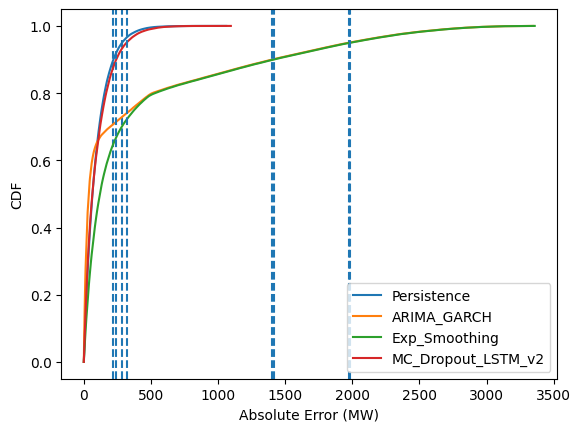

In [ ]:
plt.figure()
for m in methods:
    data = np.sort(df_res_cleaned[f"err_abs_{m}"].dropna())
    p = np.linspace(0, 1, len(data))
    plt.plot(data, p, label=m)
    # annotate 90th and 95th percentiles
    for q in [90, 95]:
        plt.axvline(np.percentile(data, q), linestyle="--")
plt.legend()
plt.xlabel("Absolute Error (MW)")
plt.ylabel("CDF")

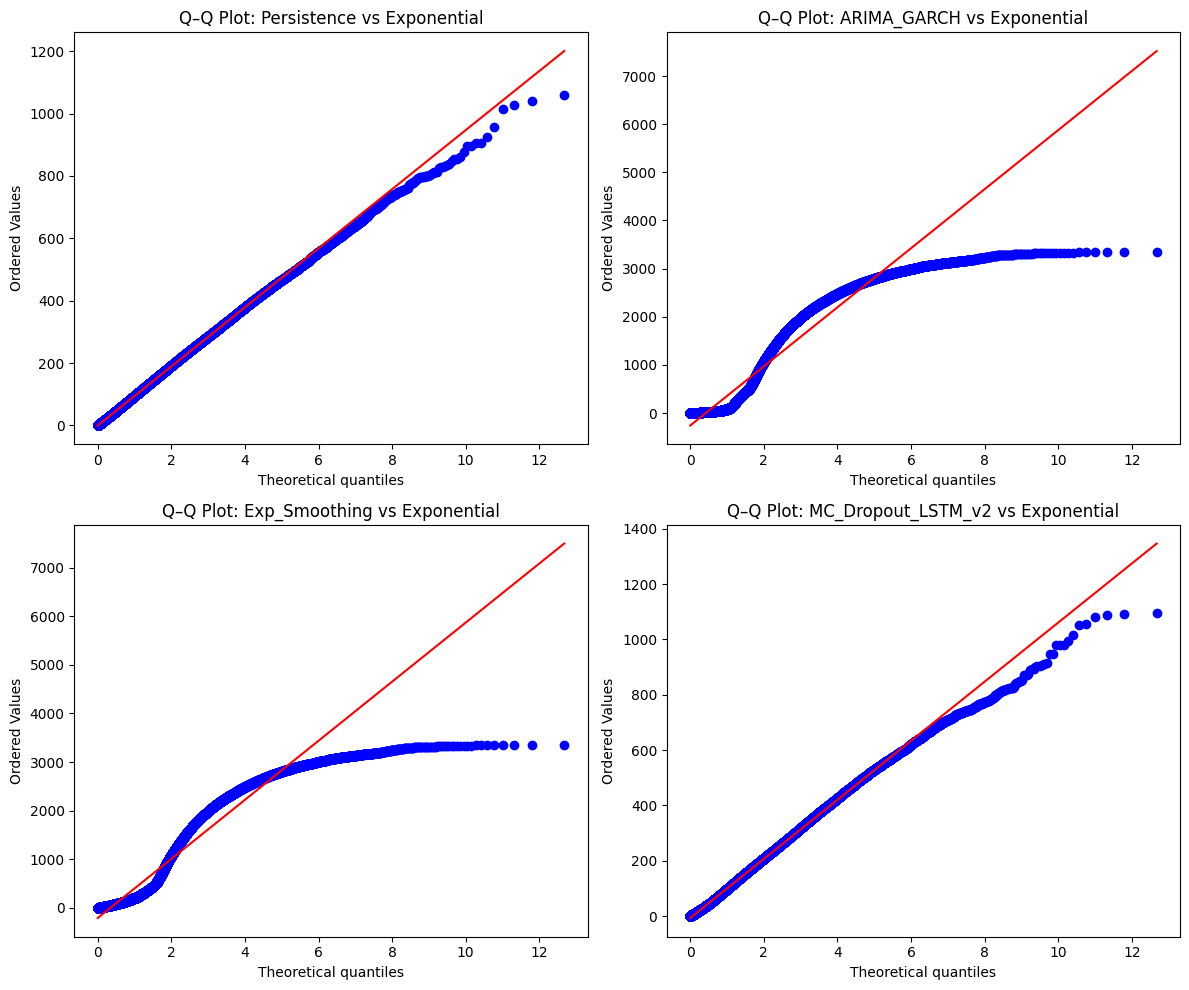

In [ ]:
# Code Cell: Q–Q plots against exponential distribution in a 2×2 grid
import scipy.stats as st
import matplotlib.pyplot as plt

methods = ["Persistence", "ARIMA_GARCH", "Exp_Smoothing", "MC_Dropout_LSTM_v2"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, m in zip(axes, methods):
    data = df_res_cleaned[f"err_abs_{m}"].dropna()
    st.probplot(data, dist="expon", plot=ax)
    ax.set_title(f"Q–Q Plot: {m} vs Exponential")

plt.tight_layout()
plt.show()

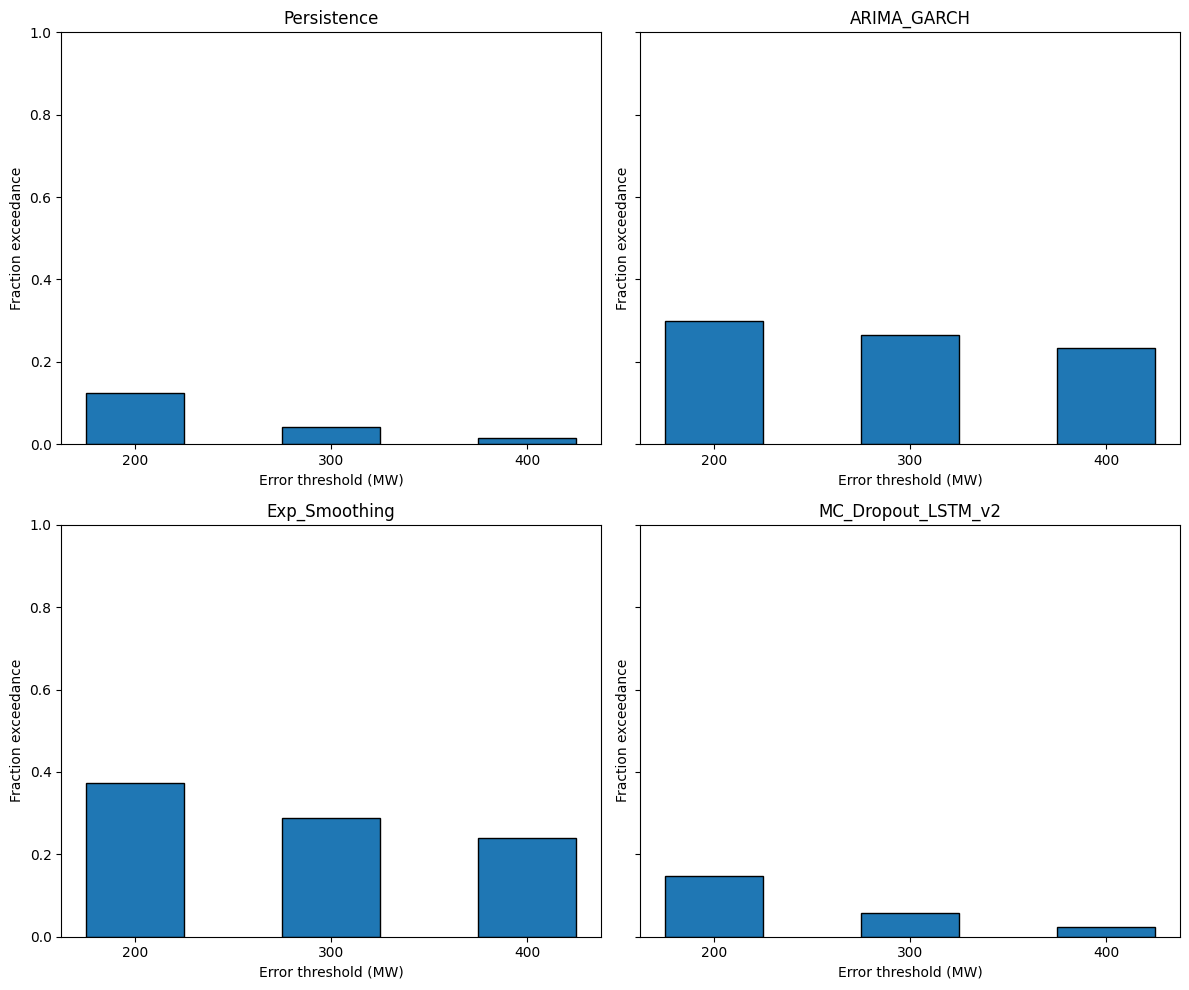

In [ ]:
# Code Cell: Bar‐plot of “% of errors > X MW” by method in a 2×2 grid
import matplotlib.pyplot as plt

thresholds = [200, 300, 400]
methods = ["Persistence", "ARIMA_GARCH", "Exp_Smoothing", "MC_Dropout_LSTM_v2"]

# compute fraction exceedances
frac = {
    m: [(df_res_cleaned[f"err_abs_{m}"] > t).mean() for t in thresholds]
    for m in methods
}

# create 2×2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()

for ax, m in zip(axes, methods):
    ax.bar(thresholds, frac[m], width=50, edgecolor='k')
    ax.set_title(m)
    ax.set_xlabel("Error threshold (MW)")
    ax.set_ylabel("Fraction exceedance")
    ax.set_xticks(thresholds)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
d = df_res_cleaned["err_sq_ARIMA_GARCH"] - df_res_cleaned["err_sq_MC_Dropout_LSTM_v2"]

In [ ]:
# Diebold–Mariano comparisons on df_res_cleaned
pairs = [
    ("MC_Dropout_LSTM_v2", "Persistence"),
    ("MC_Dropout_LSTM_v2", "ARIMA_GARCH"),
    ("MC_Dropout_LSTM_v2", "Exp_Smoothing"),
    ("Persistence",         "ARIMA_GARCH"),
]

results = []
for m1, m2 in pairs:
    stat, p = diebold_mariano(
        df_res_cleaned["y_true"],
        df_res_cleaned[m1],
        df_res_cleaned[m2],
        h=4,
        power=2
    )
    results.append({
        "Model 1": m1,
        "Model 2": m2,
        "DM Stat": stat,
        "p-value": p
    })

df_dm = pd.DataFrame(results)
heatmap_data = df_dm.pivot(index="Model 1", columns="Model 2", values="p-value")

print("Diebold–Mariano Test Results:")
display(df_dm.set_index(["Model 1", "Model 2"])[["DM Stat", "p-value"]])

Diebold–Mariano Test Results:


DM Stat  p-value
Model 1            Model 2                          
MC_Dropout_LSTM_v2 Persistence    12.840378      0.0
                   ARIMA_GARCH   -65.494510      0.0
                   Exp_Smoothing -67.050572      0.0
Persistence        ARIMA_GARCH   -65.336592      0.0